### Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_squared_log_error as rmsle
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf , plot_predict
from pmdarima.arima import auto_arima
import joblib
import itertools as it

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (20,15)
plt.rcParams['font.size'] = 20

### Loading the data

In [4]:
data = pd.read_excel('Hackathon_Information_Data.xlsx',sheet_name = 'Data')
data.columns = ['Country','Date','Value']
data.Date = pd.to_datetime(data.Date)
data.head()

,Country,Date,Value
0,Canada,2019-01-01,2.215572e+06
1,Canada,2019-02-01,2.090147e+06
2,Canada,2019-03-01,6.633213e+06
3,Canada,2019-04-01,2.067832e+06
4,Canada,2019-05-01,2.317593e+06


In [53]:
countries = ['Canada','China','Germany','Italy','USA']
Dates = pd.date_range(start = '2022-05-01' , periods = 15,freq = 'MS')

forecast_df = pd.DataFrame(
    columns=countries,
    index=Dates)
forecast_df.head()

,Canada,China,Germany,Italy,USA
2022-05-01,NaN,NaN,NaN,NaN,NaN
2022-06-01,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN


# Canada Country Analysis

### Data Preparation

In [35]:
df_canada=data[data.Country == 'Canada'].drop('Country',axis = 1).set_index('Date').astype(int)
df_canada.head()

,Value
Date,
2019-01-01,2215572
2019-02-01,2090147
2019-03-01,6633213
2019-04-01,2067832
2019-05-01,2317592


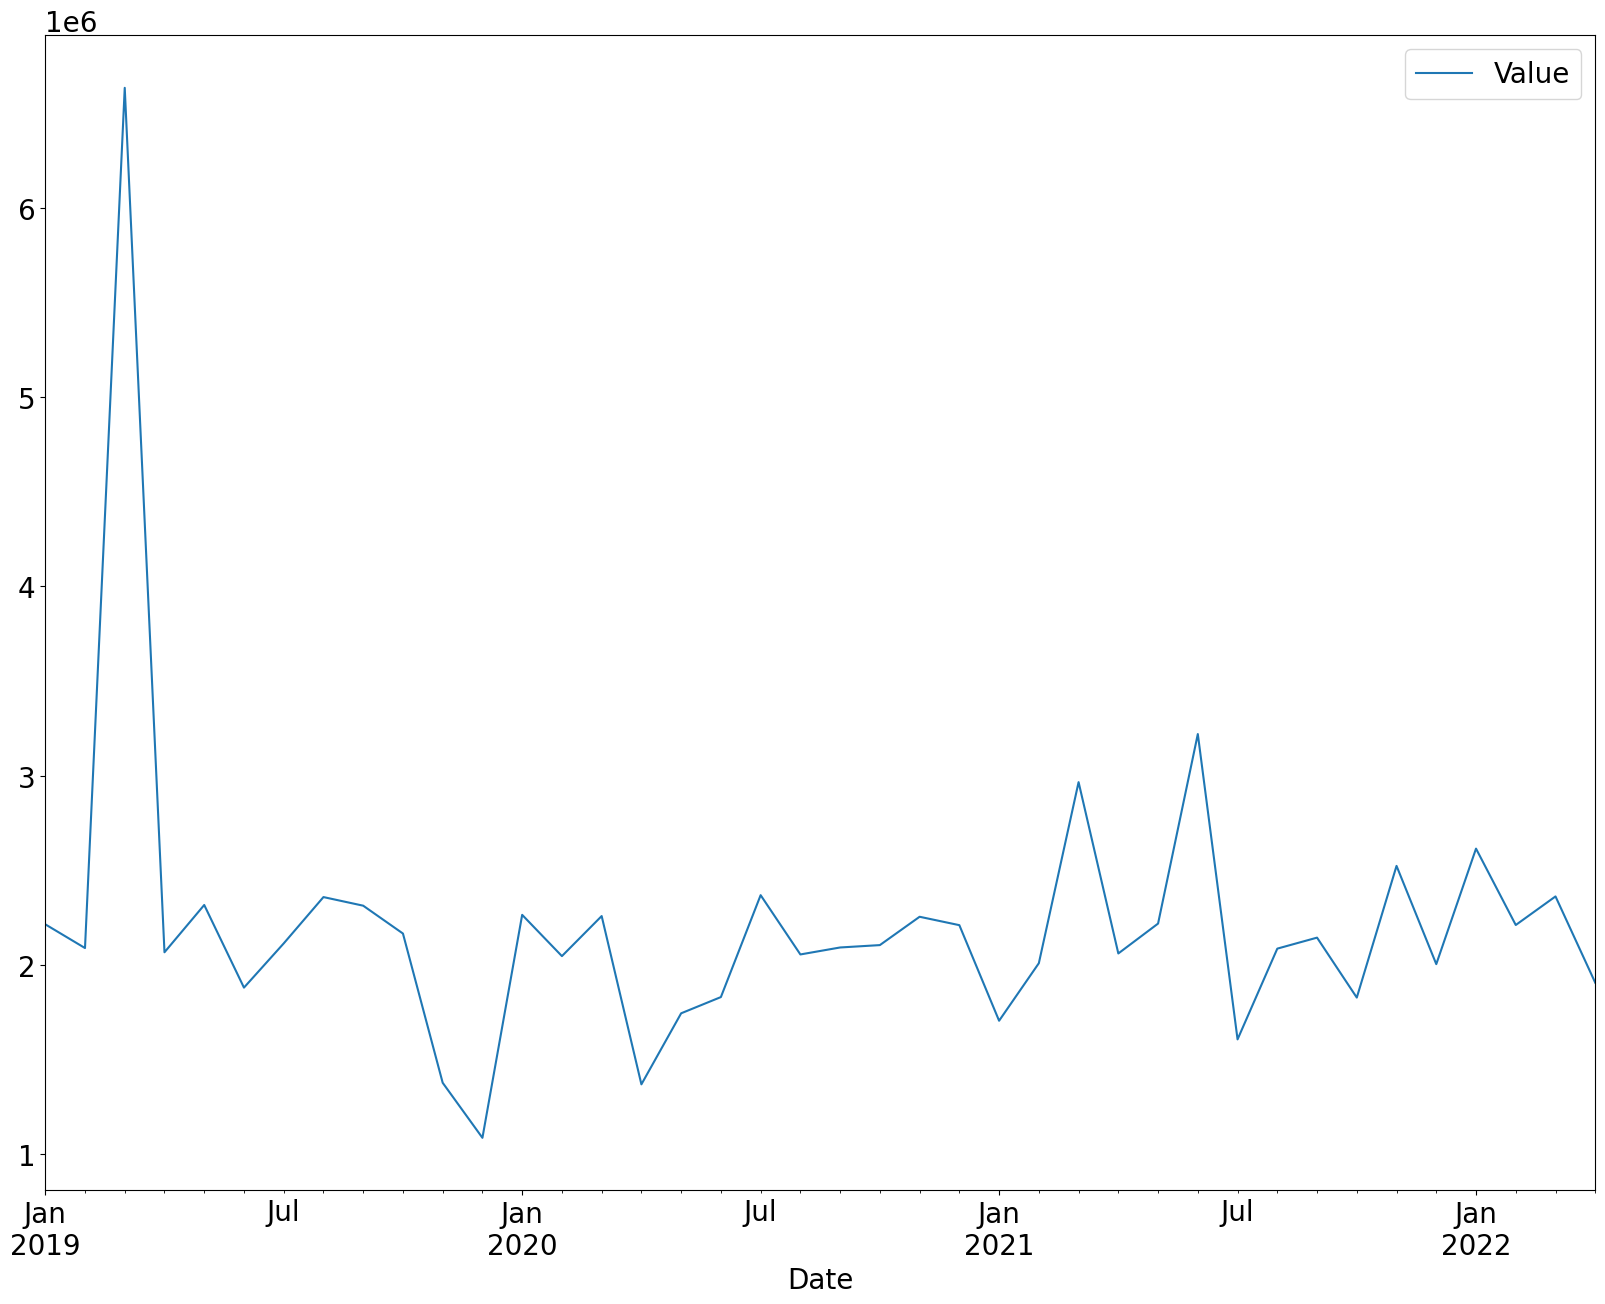

In [36]:
df_canada.plot()
plt.show()

<AxesSubplot:>

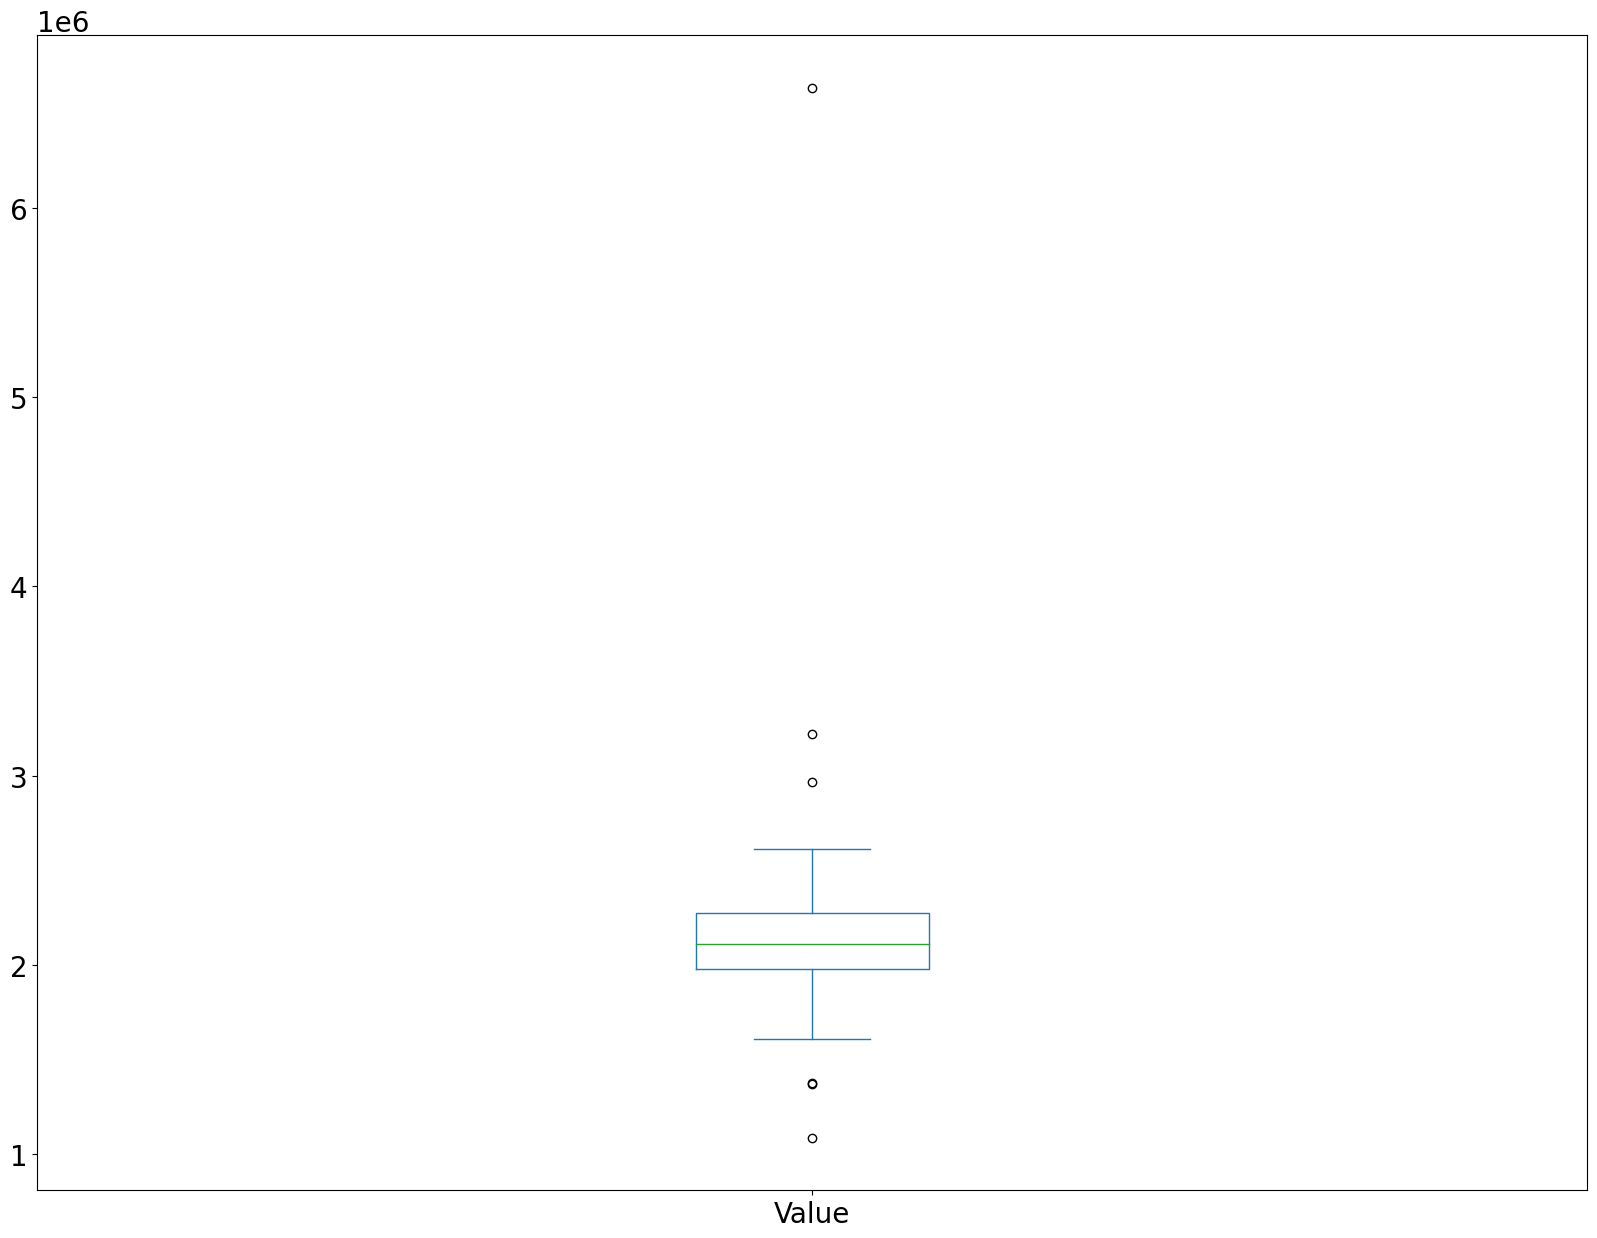

In [37]:
df_canada['Value'].plot(kind = 'box')

#### IQR  function to bound the outliers

In [38]:
def IQR(data , col):
    low , high = data[col].quantile(q = [0.25 , 0.75])
    iqr = high - low
    upper_range = high + 1.5*(iqr)
    lower_range = low - 1.5*(iqr)
    
    data[data[col] > upper_range] = upper_range
    data[data[col] < lower_range] = lower_range  

<AxesSubplot:>

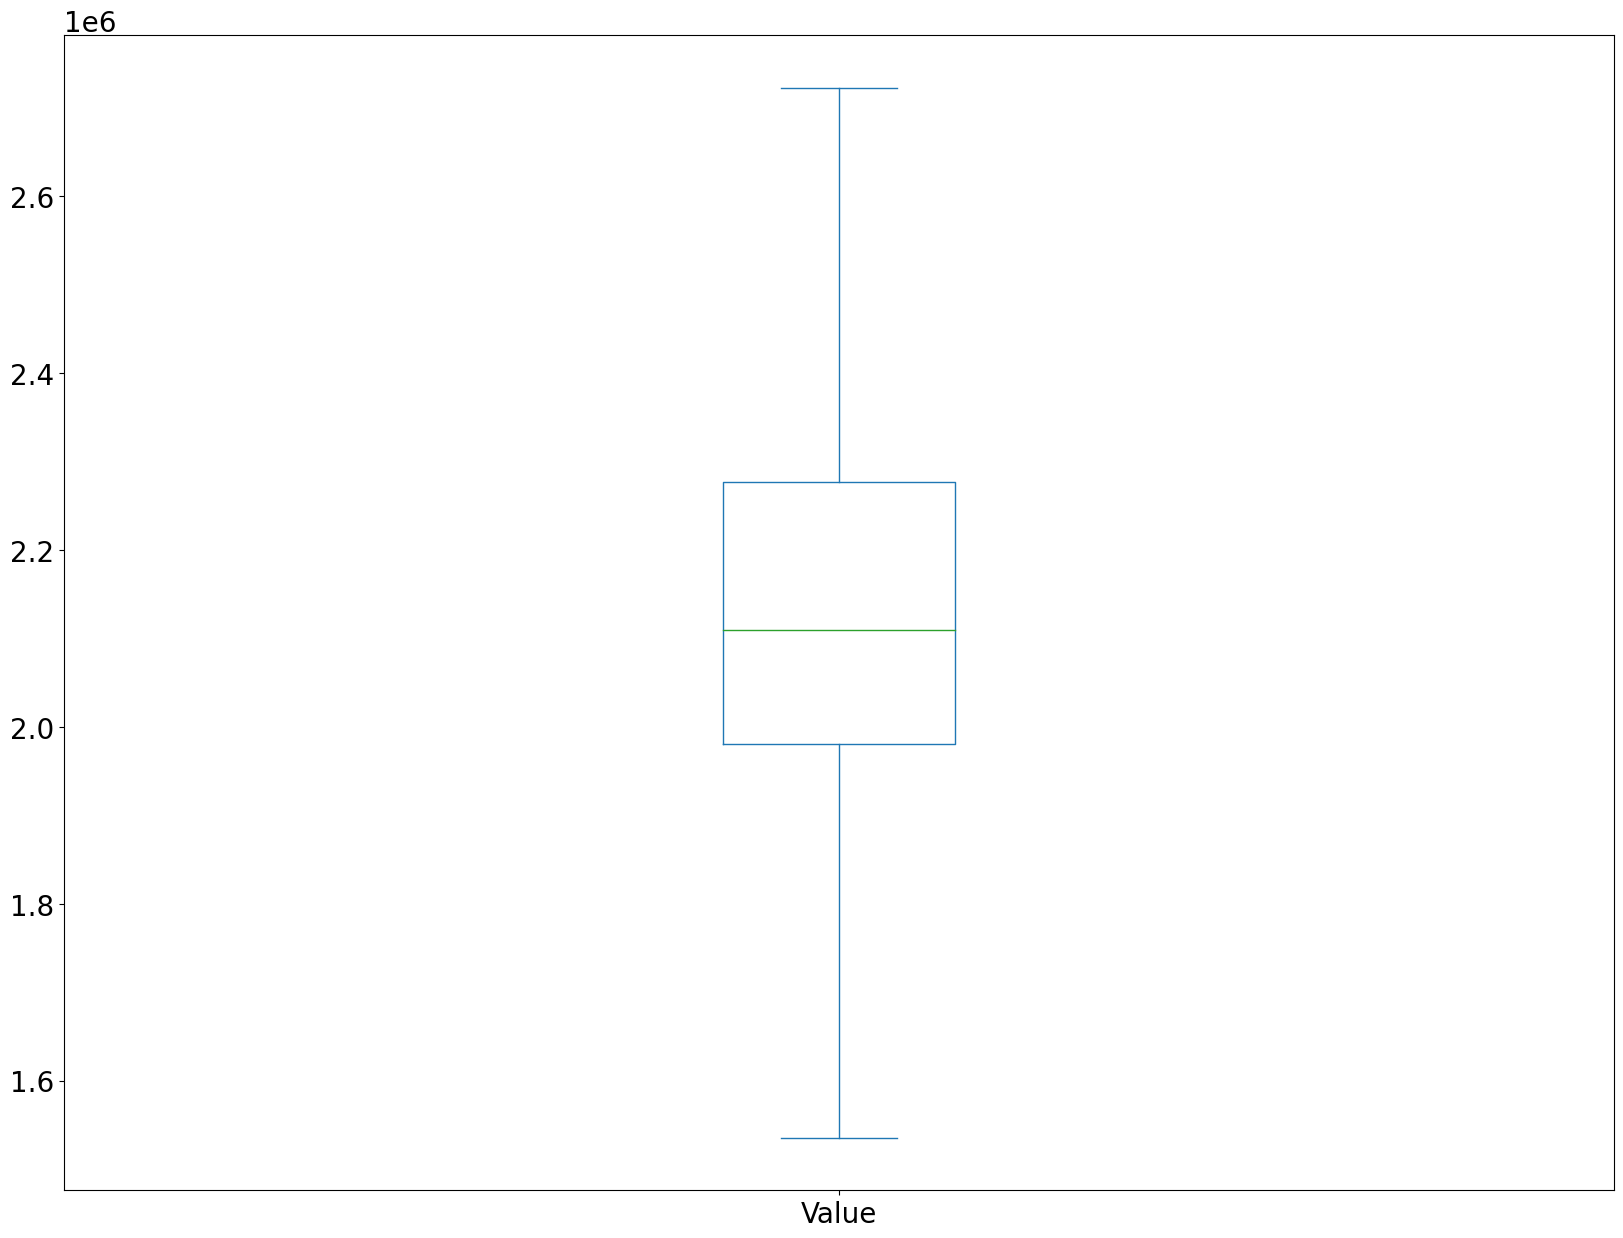

In [39]:
IQR(df_canada ,  'Value')
df_canada['Value'].plot(kind = 'box')

### Seasonal Decomposition Of Data

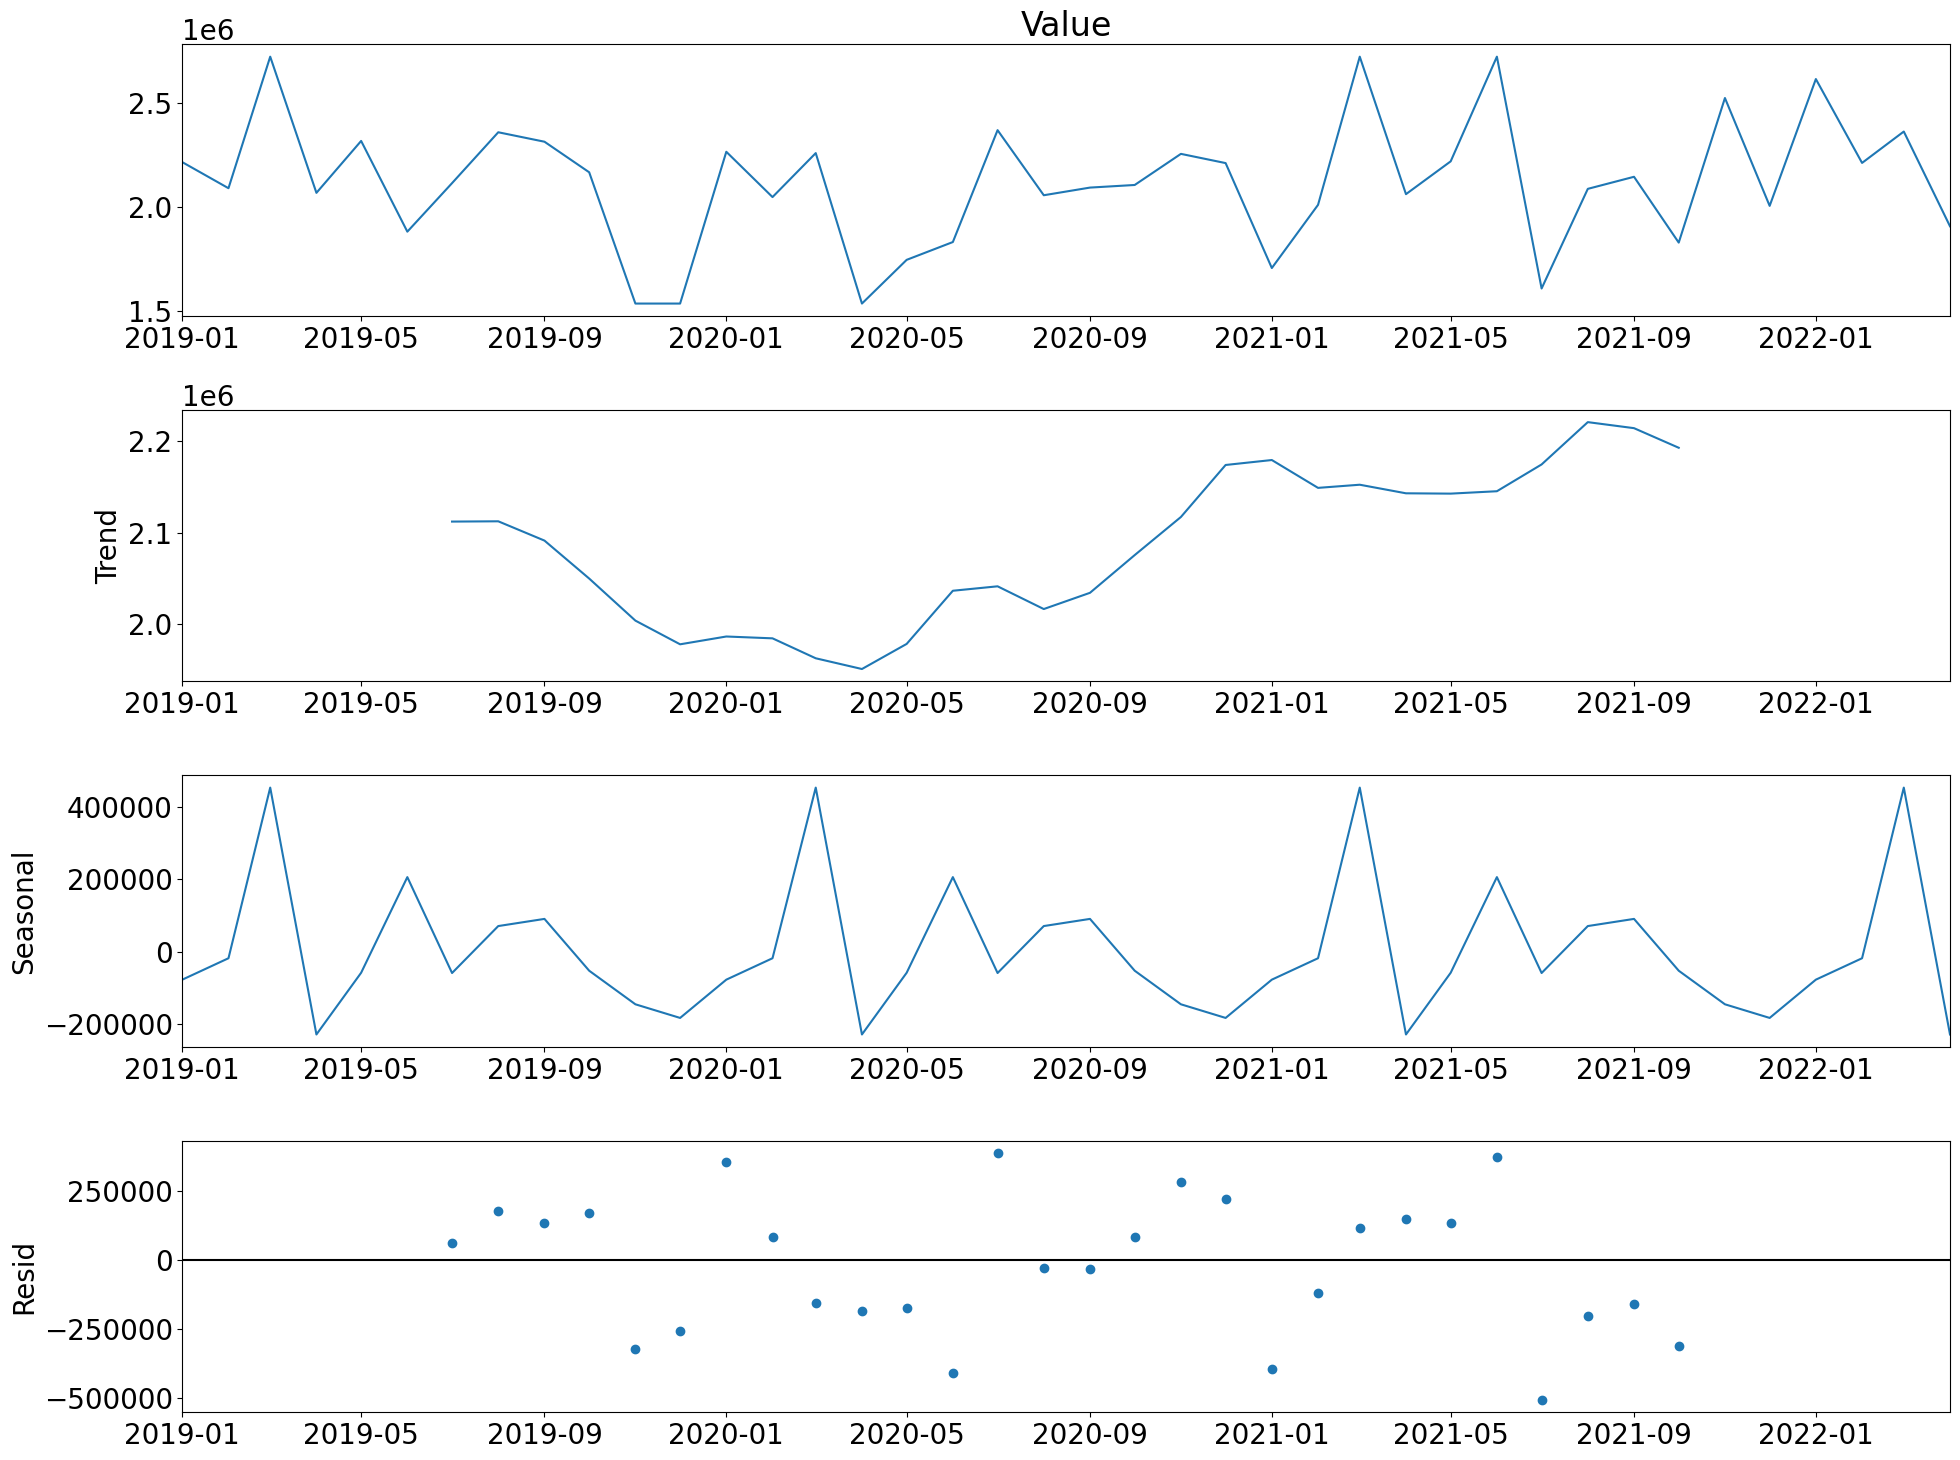

In [40]:
# Since there is no seasonality in the data we use additive model
decomposition = seasonal_decompose(df_canada['Value'] , model = 'additive')

# Lets plot the trend
decomposition.plot()
plt.show()

### Check For Stationarity :-  A D-Fuller Test

In [41]:
# A D-Fuller Test

result = sts.adfuller(df_canada['Value'])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -6.420451025504612
n_lags: 0
p_value: 1.7970045344864507e-08
Critical Values :
1% , -3.610399601308181
Critical Values :
5% , -2.939108945868946
Critical Values :
10% , -2.6080629651545038


**Since p_value < 0.05 We reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Stationary**

### Auto Correlation Function
#### ACF is a statistical representation used to analyze the degree of similarity between a time series and a lagged version of itself.

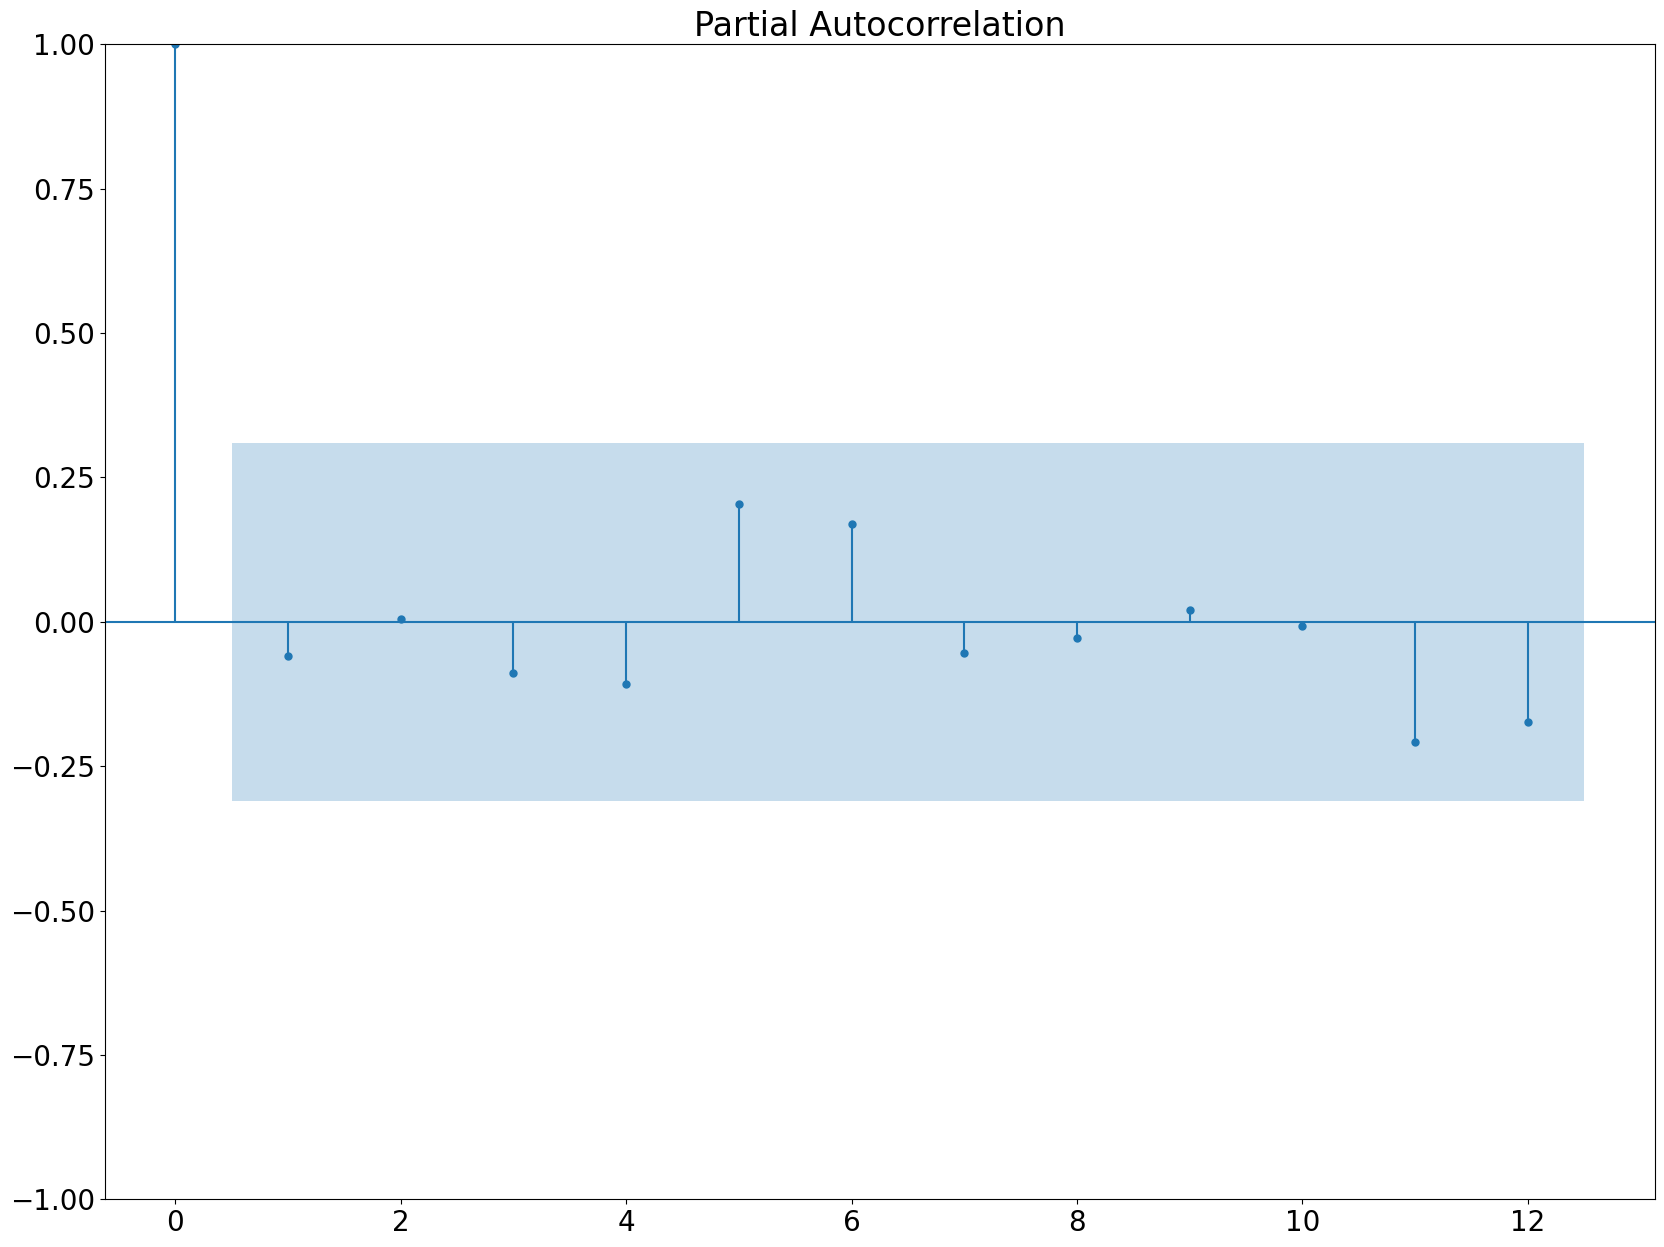

In [42]:
plot_pacf(df_canada['Value'] , lags = 12)
plt.show()

**We can see that there is no possible degree of similarity.....Lets get the Return values**

### Creating Returns and Plotting ACF

#### Formula to calculate returns

### $ Return_{t} = \frac{value_{t} - value_{t-1}}{value_{t-1}} * 100 $

In [43]:
df_canada['Return'] = df_canada['Value'].pct_change(1).mul(100)
df_canada.head()

,Value,Return
Date,,
2019-01-01,2215572,NaN
2019-02-01,2090147,-5.661066
2019-03-01,2722923,30.274234
2019-04-01,2067832,-24.058374
2019-05-01,2317592,12.078351


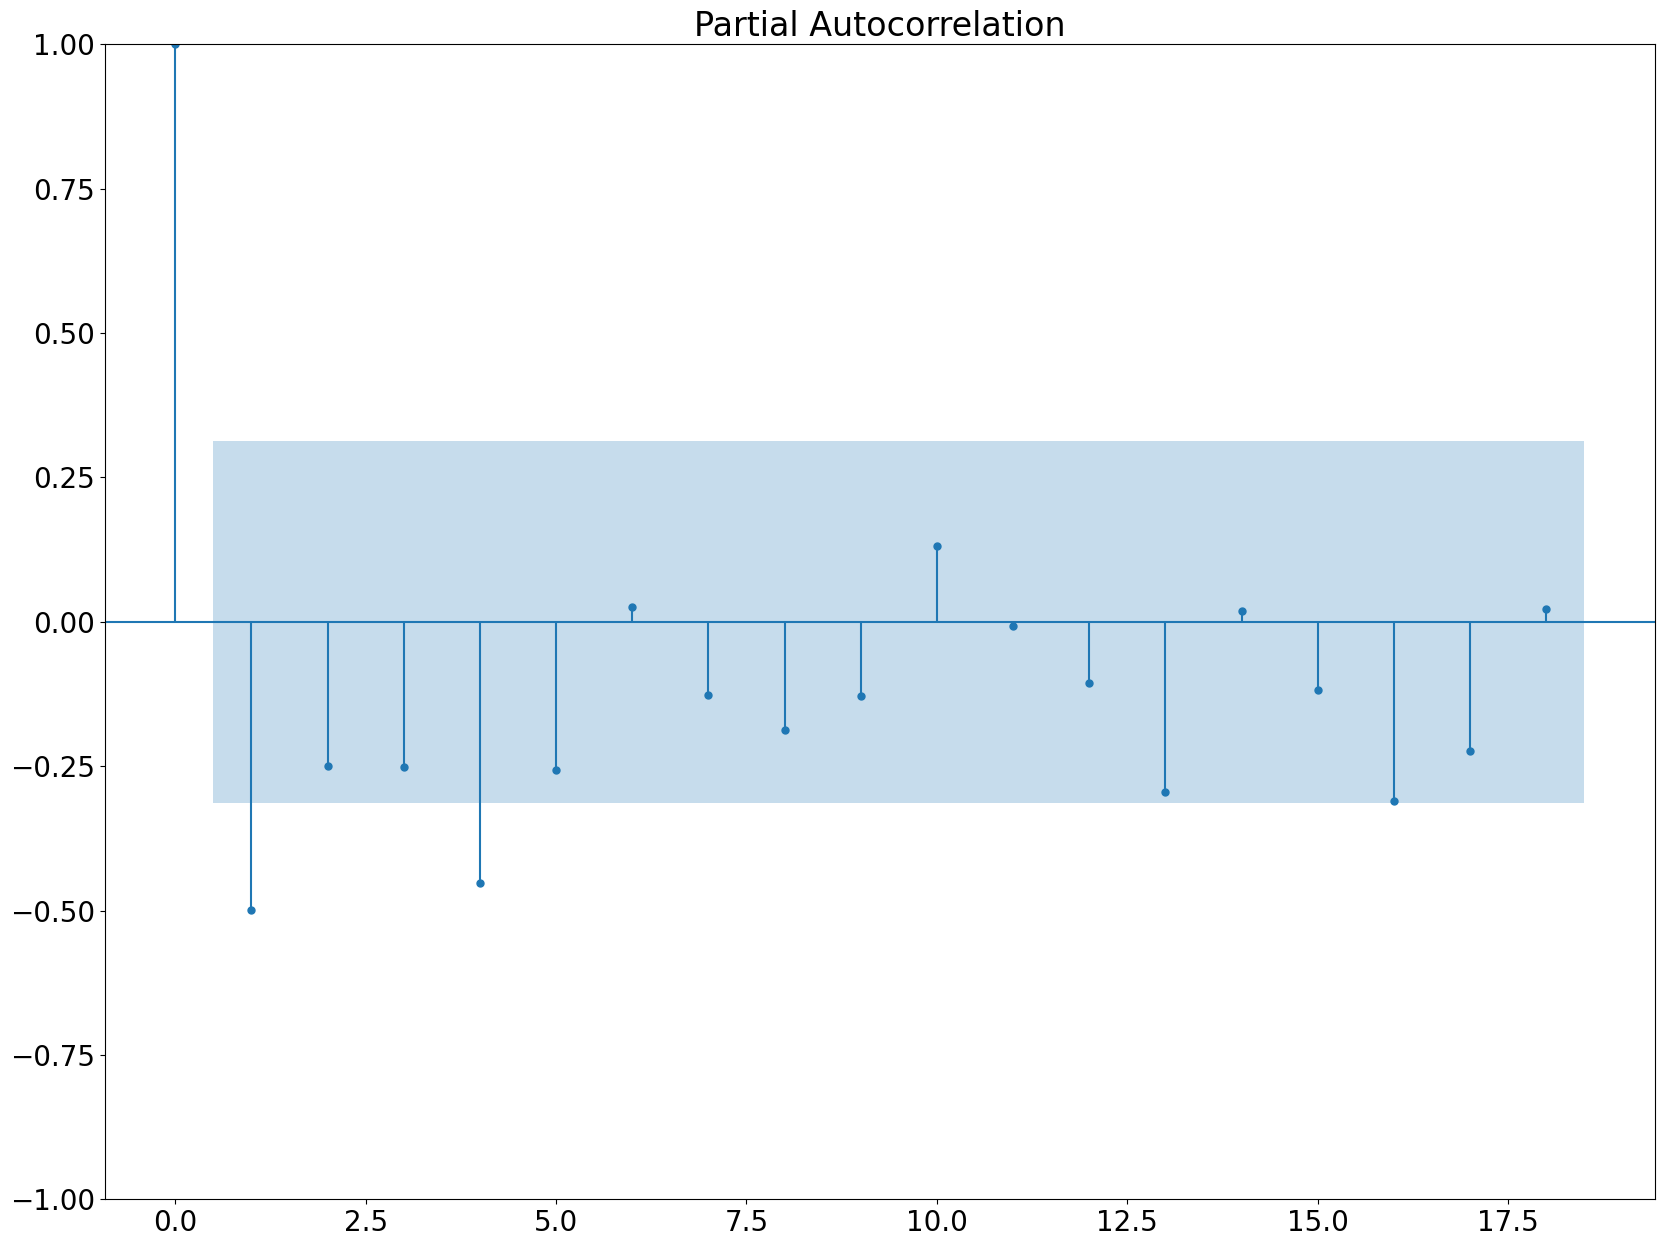

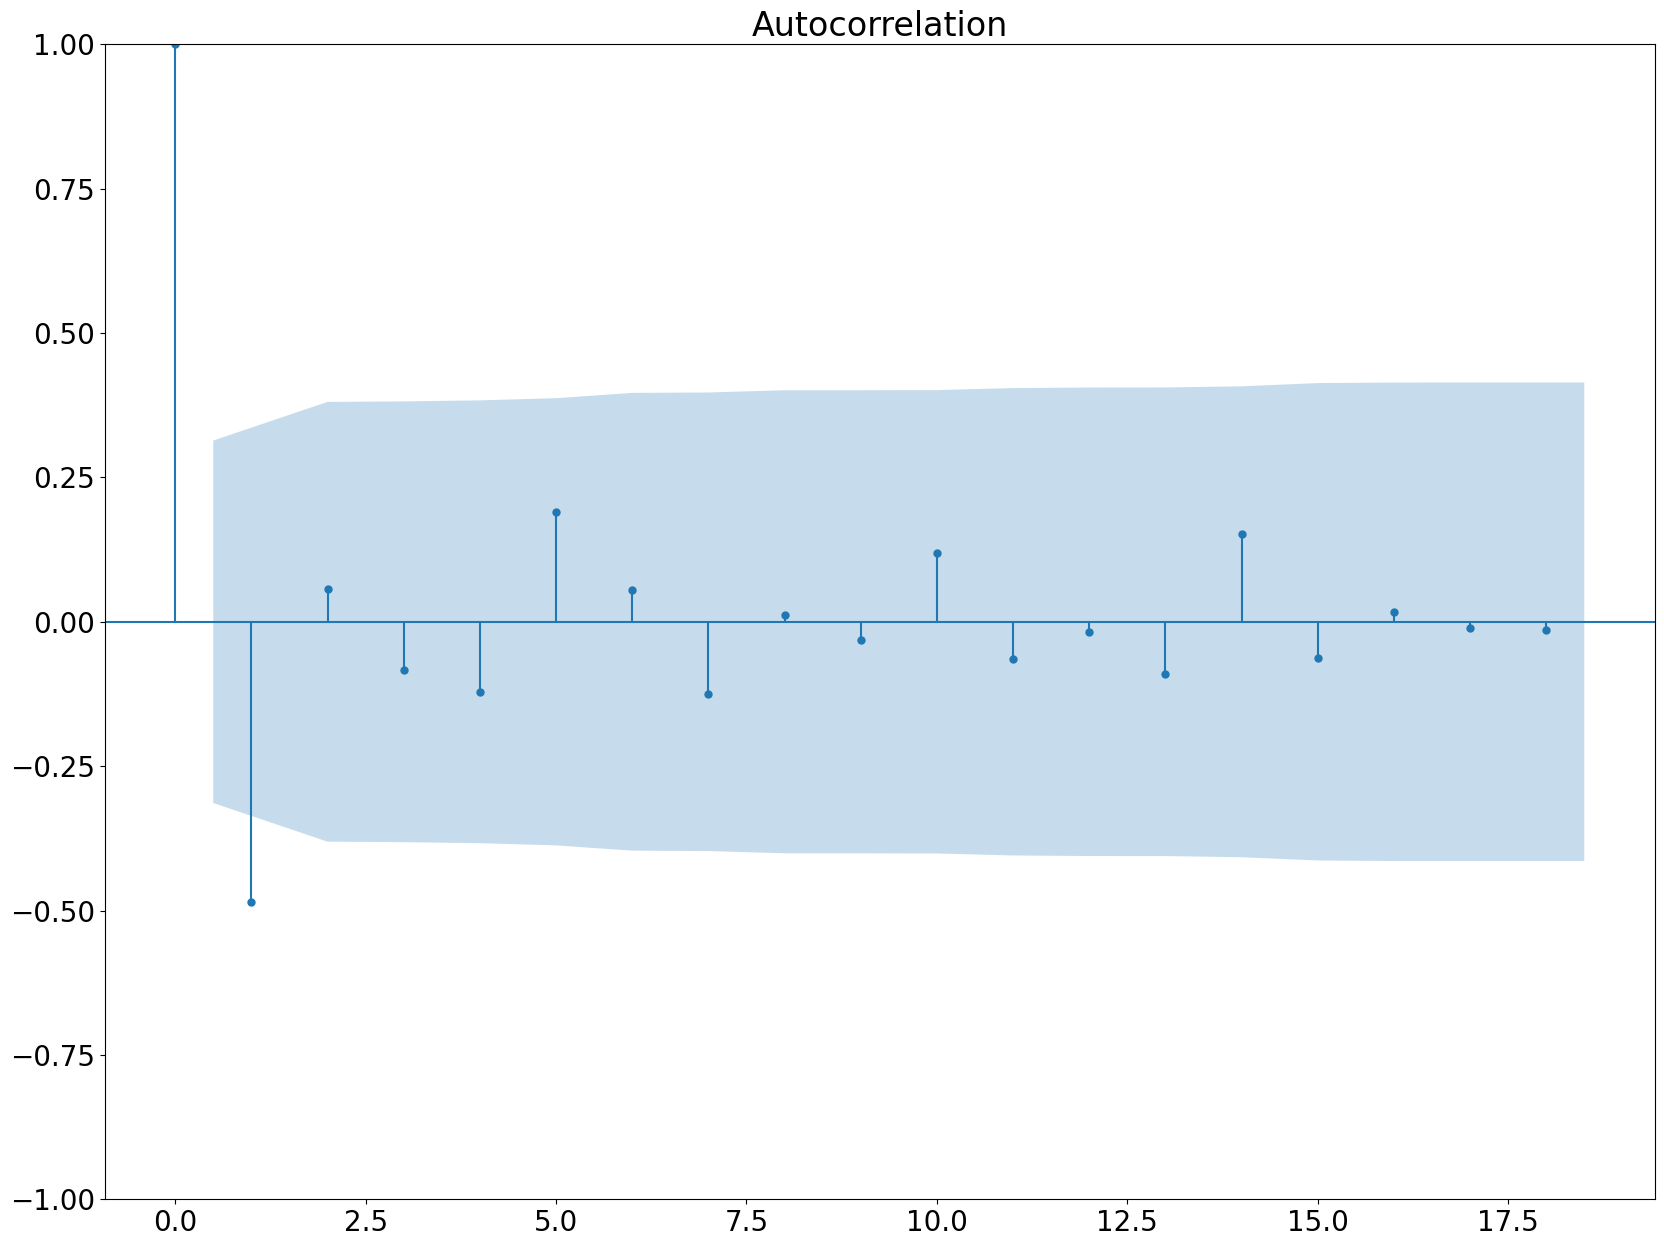

In [44]:
plot_pacf(df_canada['Return'][1:] , lags = 18)
plot_acf(df_canada['Return'][1:] , lags = 18)
plt.show()

**By see the pacf and acf plots we can have these pairs of orders for ARIMA model :-
(1,0,0) , (1,0,1) , (4,0,0) , (4,0,1), (0,0,1)**

### Finding The Suitable Model

In [45]:
auto_model = auto_arima(df_canada['Return'][1:])
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -164.161
Date:                Fri, 09 Dec 2022   AIC                            334.321
Time:                        23:55:07   BIC                            339.312
Sample:                    02-01-2019   HQIC                           336.112
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2840      0.493      4.636      0.000       1.318       3.250
ma.L1         -0.8474      0.107     -7.919      0.000      -1.057      -0.638
sigma2       256.7556     60.866      4.218      0.000     137.460     376.051
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.92   Prob(JB):                         0.80
Heteroskedasticity (H):               0.77   Skew:                            -0.26
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
orders = orders = [(1,0,0) , (1,0,1) , (4,0,0) , (4,0,1), (0,0,1)]

for order in orders:
    ar,ma = order[0] , order[-1]
    arima = ARIMA(df_canada['Return'][1:] , order = (ar,0,ma))
    results = arima.fit()
    print(f'ARIMA{order} has LLF = {results.llf} and AIC = {results.aic}')

ARIMA(1, 0, 0) has LLF = -168.9749216487104 and AIC = 343.9498432974208
ARIMA(1, 0, 1) has LLF = -164.16045248854522 and AIC = 336.32090497709044
ARIMA(4, 0, 0) has LLF = -163.20164926340402 and AIC = 338.40329852680804
ARIMA(4, 0, 1) has LLF = -162.37577348174707 and AIC = 338.75154696349415
ARIMA(0, 0, 1) has LLF = -164.16056529760036 and AIC = 334.3211305952007


**We can choose the model that has high LLF and low AIC value** \
**After some analysis lets choose ARIMA(4,0,0)**

In [47]:
arima_canada = ARIMA(df_canada['Return'][1:] , order =(4,0,0))
results_canada = arima_canada.fit()

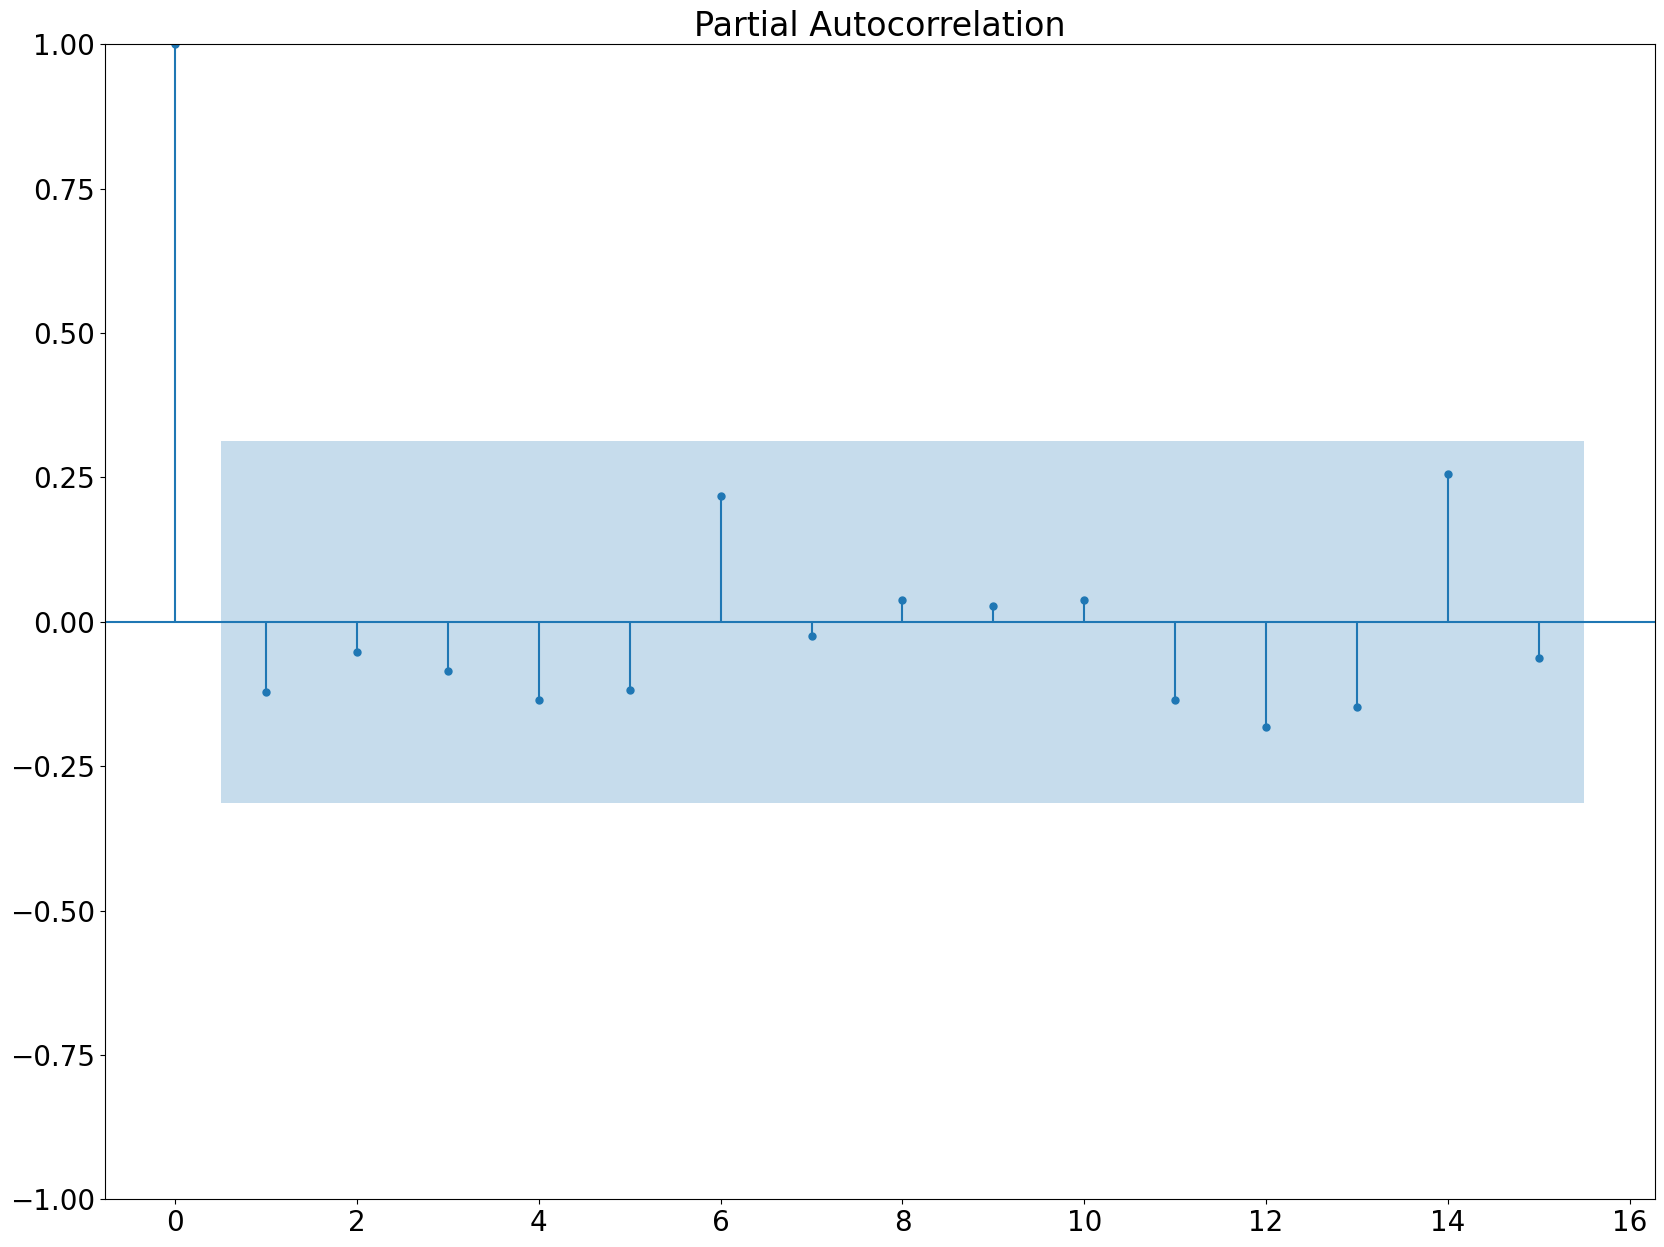

In [48]:
# Plot the residual to check is there any degree of similarities in it

plot_pacf(results_canada.resid , lags = 15)
plt.show()

# We can proceed since there are no lags

### Forecasting Future Values

In [49]:
# Lets forecast for next 15 months
returns = results_canada.forecast(steps = 15).values.tolist()

# Store the data values for calculating values from forecast values
values = df_canada['Value'].values.tolist()
len(values)

40

**Formula to calculate original values from returns**

**$ value_{t} = (value_{t-1}*\frac{return}{100}) + value_{t-1} $**

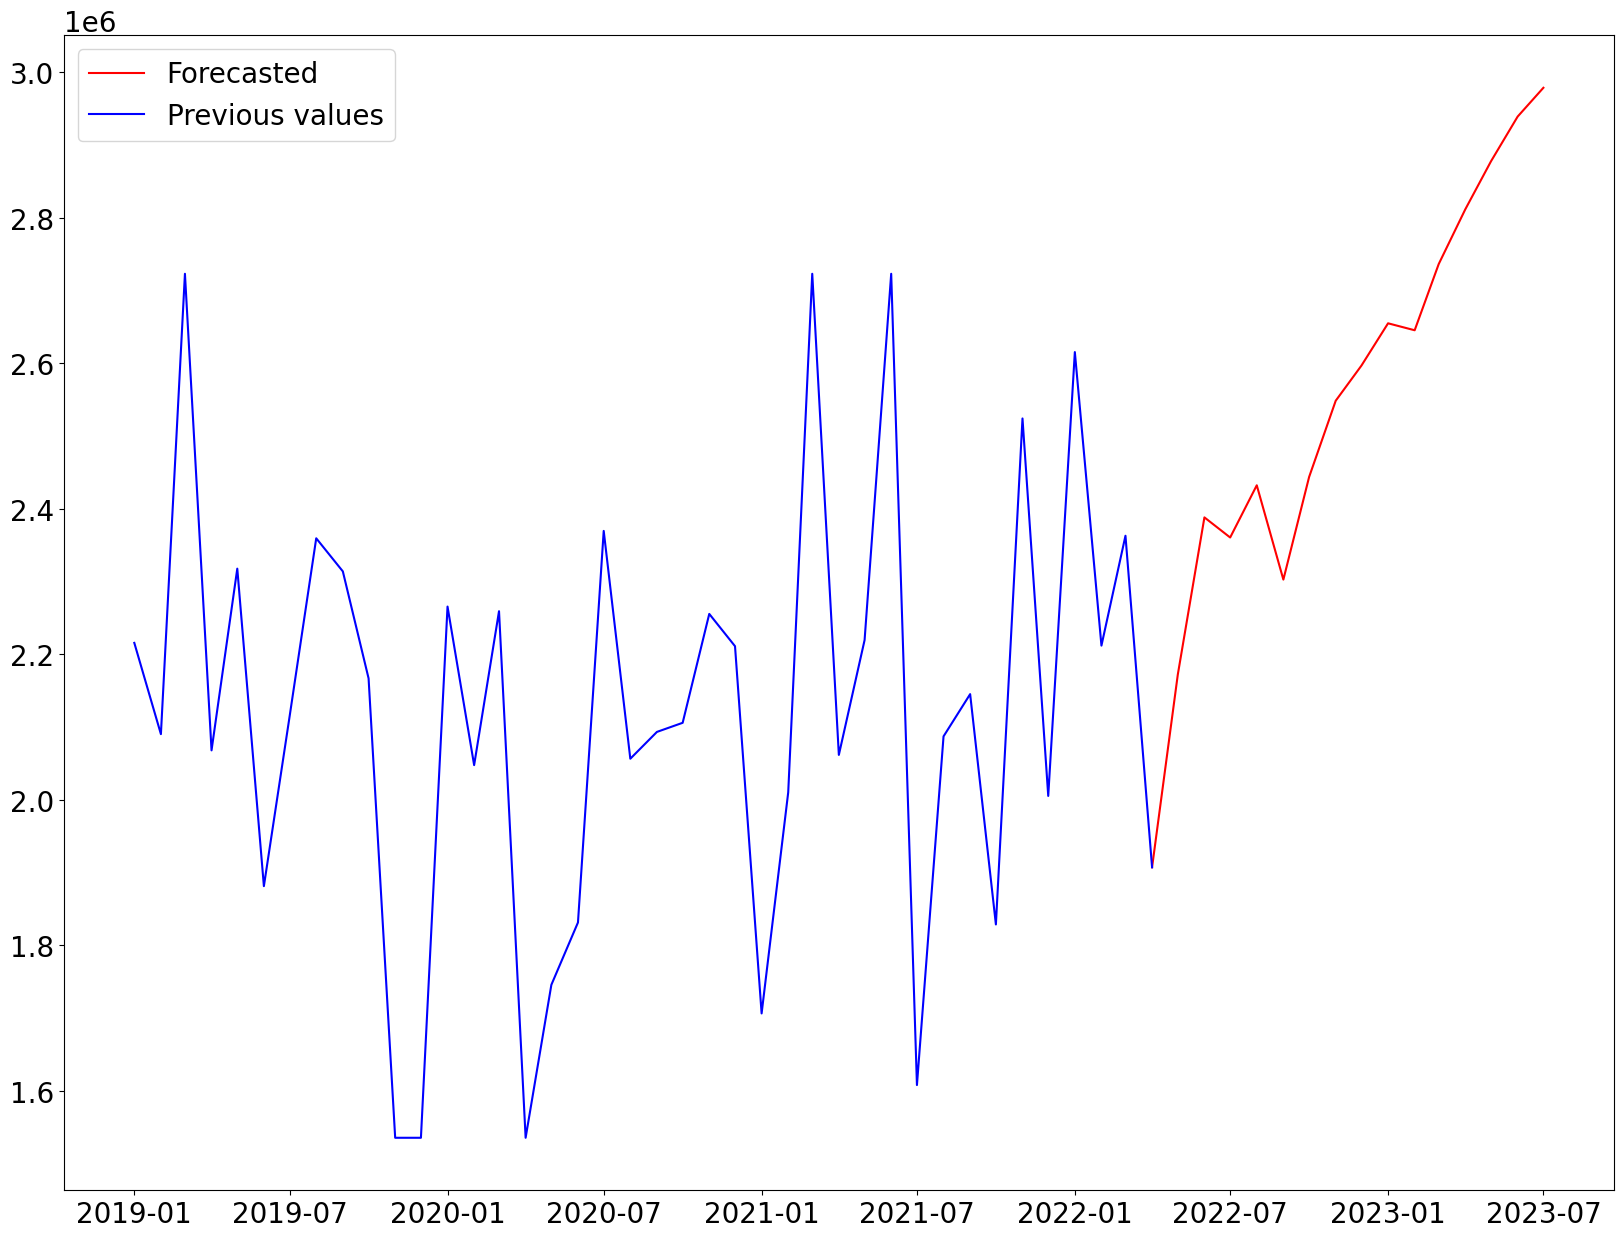

In [50]:
# Lets convert all the returns into values and add it to the data values list

for ret in returns:
    ret = ret/100
    last = values[-1]
    res = (last*ret)+last
    values.append(round(res))
    
dates = pd.date_range('2022-04-01' , periods = 16 , freq = 'MS')
    
# Plot the data values
plt.plot(pd.DataFrame({'Date':dates , 'Value':values[39:]}).set_index('Date'), label = 'Forecasted' , color = 'red')
plt.plot(df_canada[['Value']], label = 'Previous values' ,color = 'blue')
plt.legend()
plt.show()

In [51]:
# forecast_df['Canada'] = values[40:]

In [21]:
# joblib.dump(results_canada ,  'Model_Canada.pkl')

# China Country Analysis

### Data Preparation

In [51]:
df_china=data[data.Country == 'China'].drop('Country',axis = 1).set_index('Date').astype(int)
df_china.head()

,Value
Date,
2019-01-01,6788150
2019-02-01,2946702
2019-03-01,10384100
2019-04-01,6349899
2019-05-01,6910464


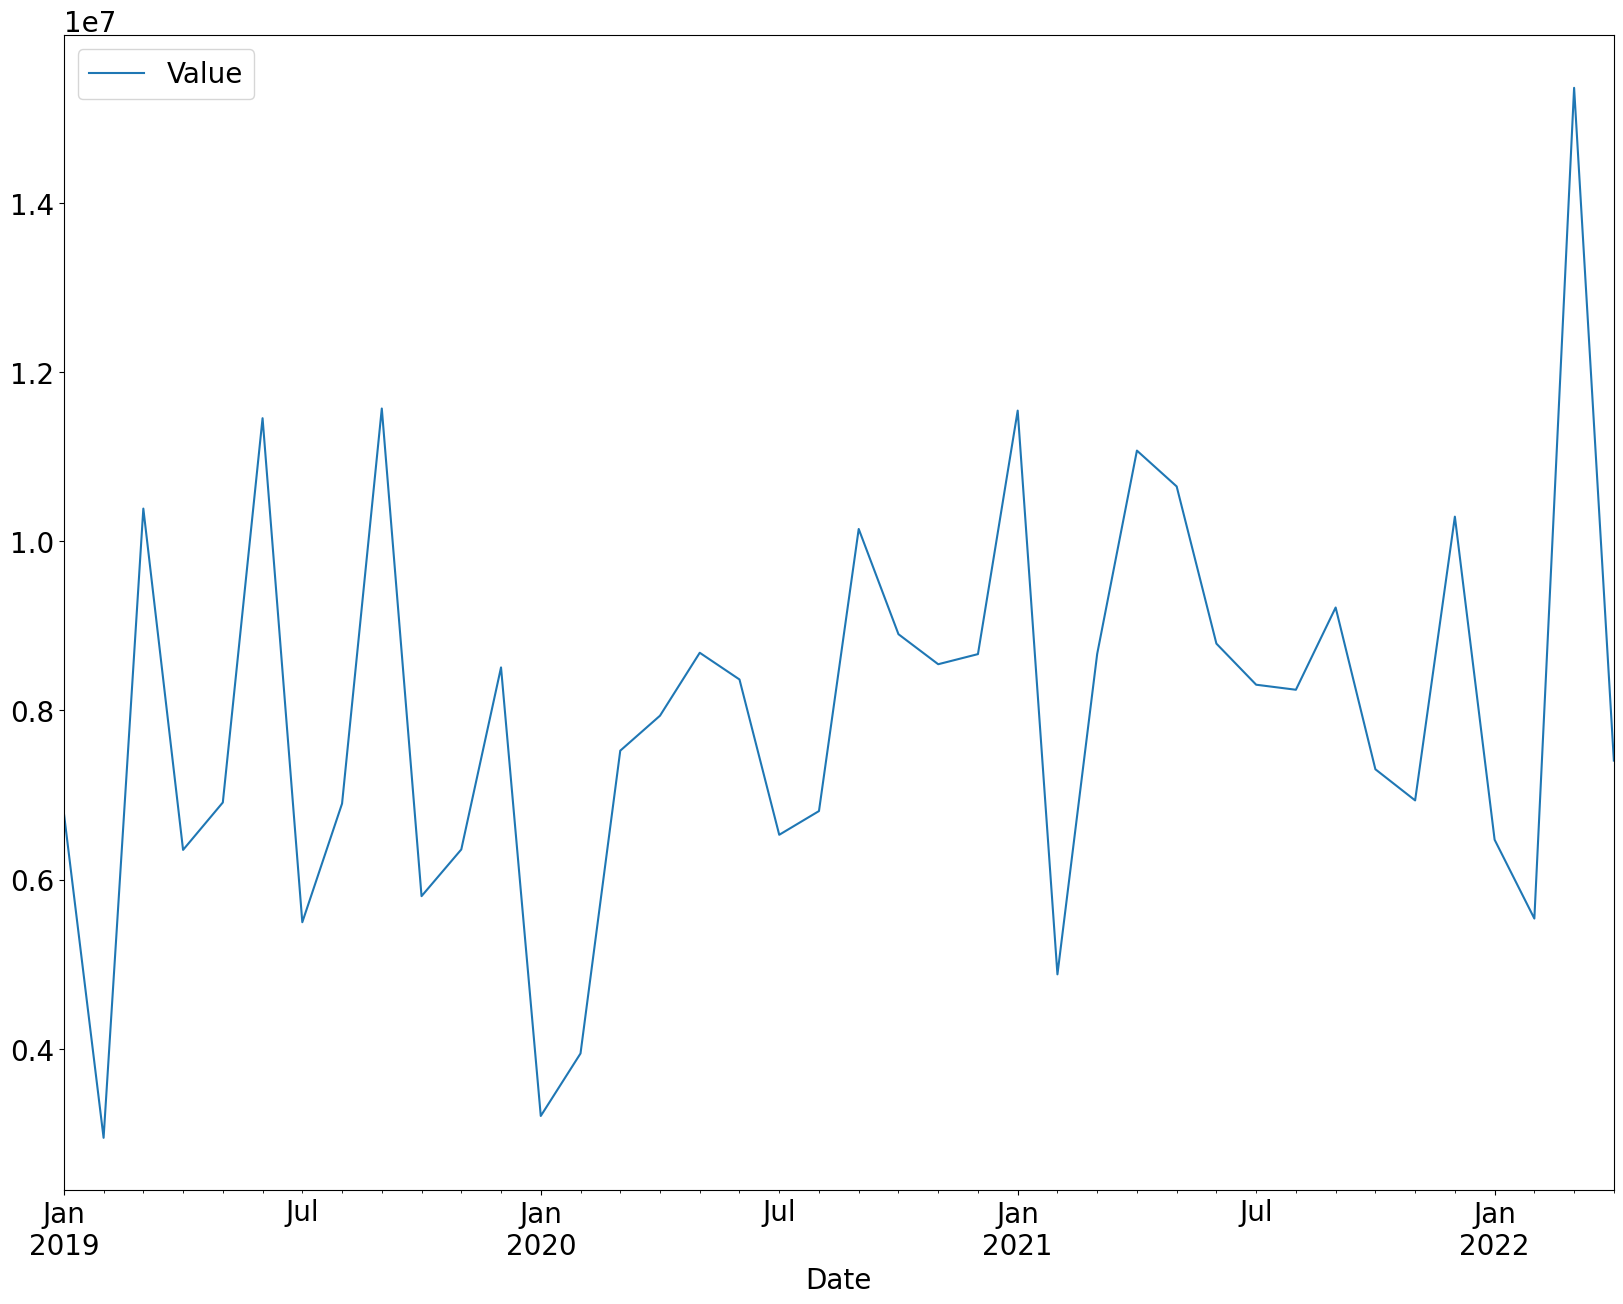

In [52]:
df_china.plot()
plt.show()

<AxesSubplot:>

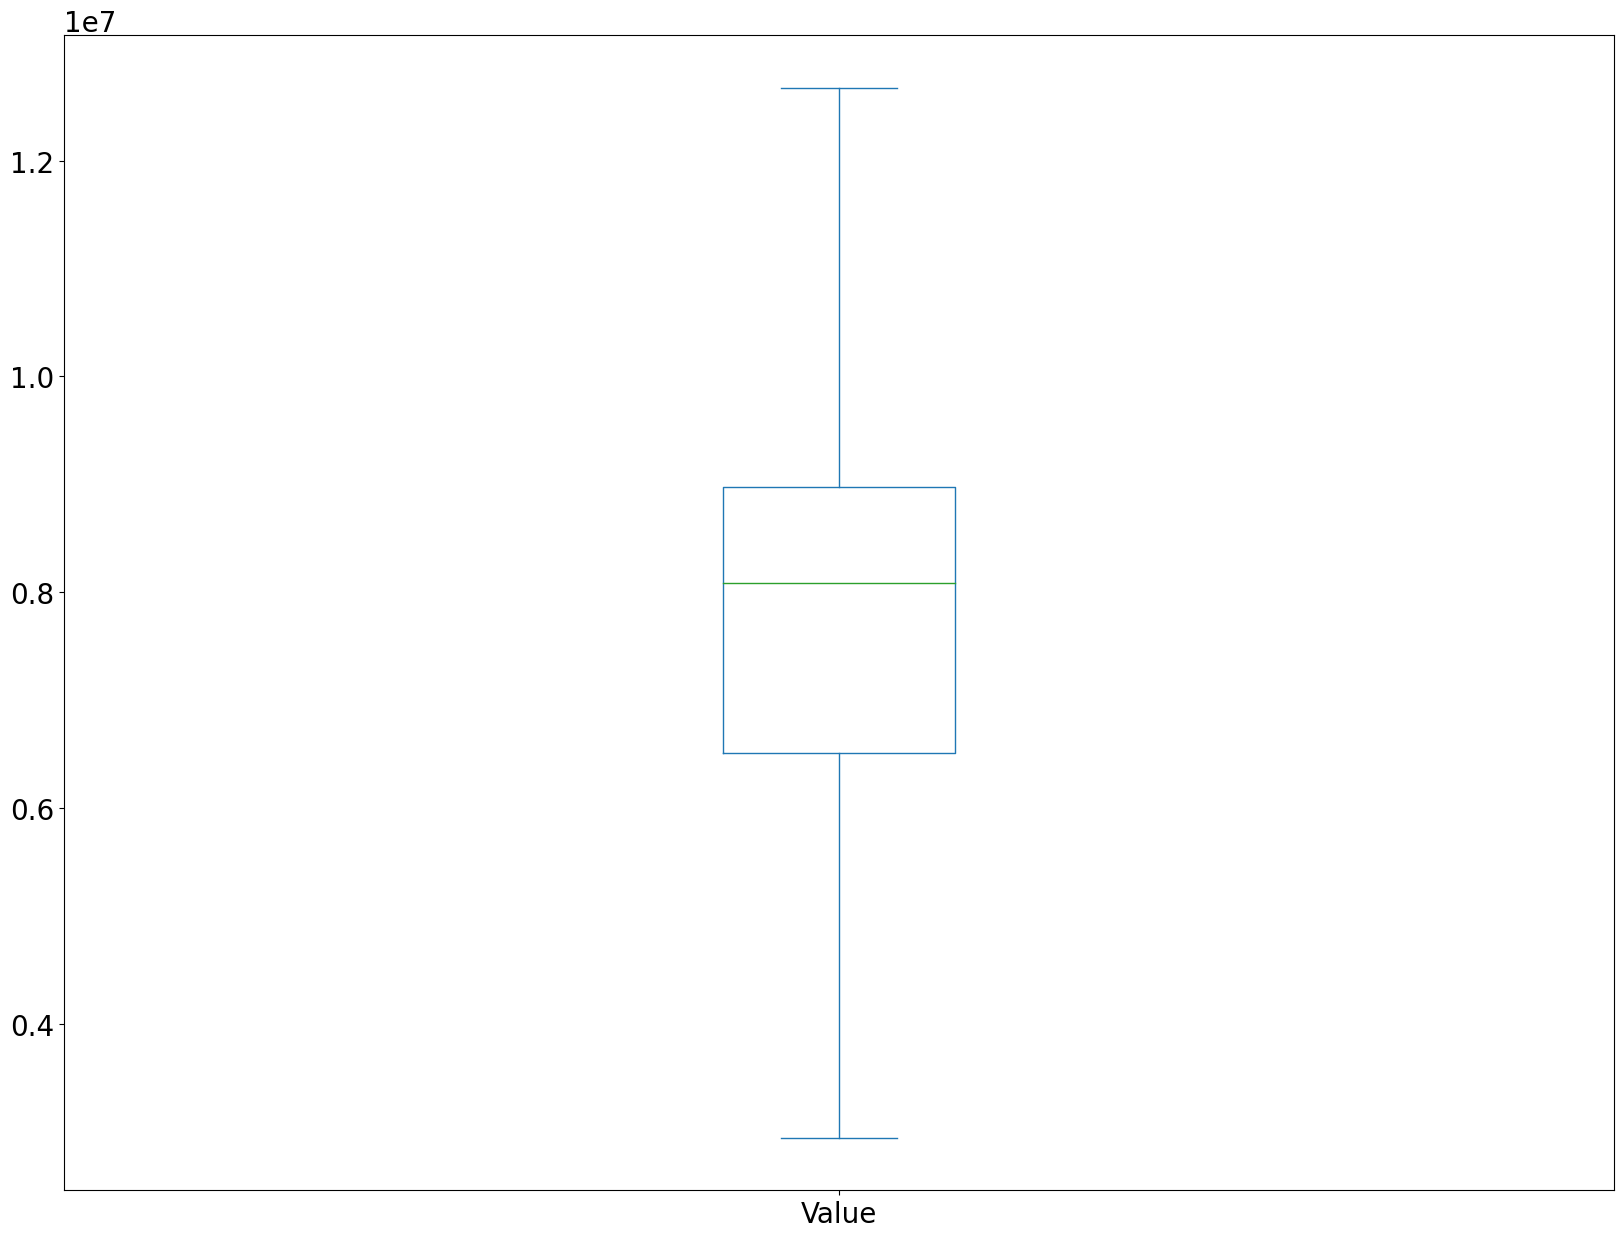

In [53]:
# Bounding the outlier

IQR(df_china ,  'Value')
df_china['Value'].plot(kind = 'box')

### Seasonal Decomposition Of Data

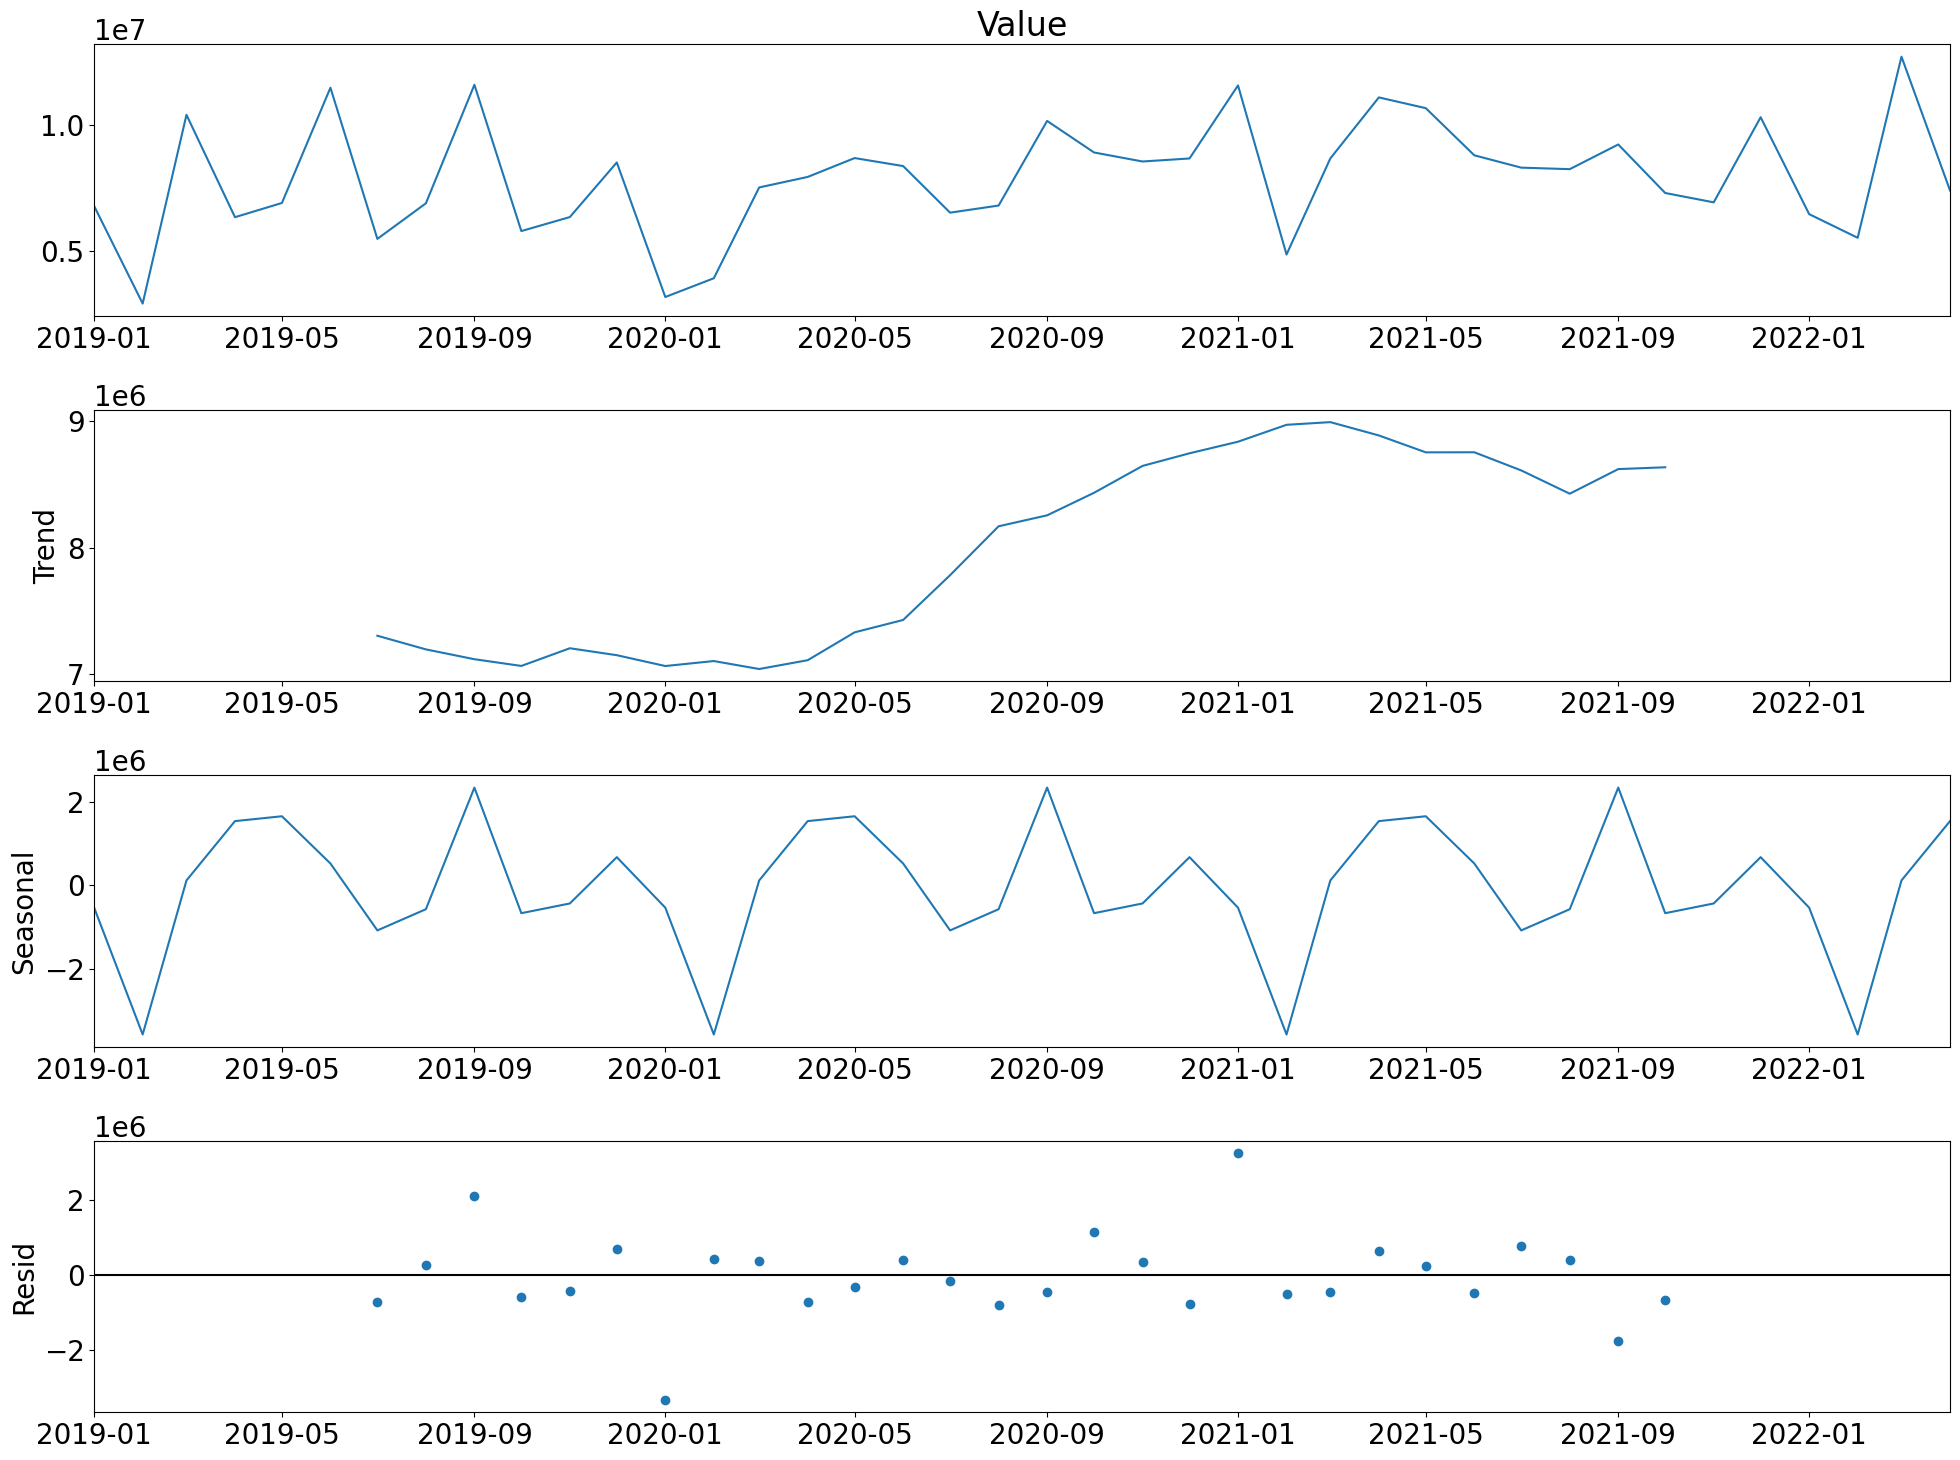

In [54]:
decomposition = seasonal_decompose(df_china['Value'] , model = 'additive')
decomposition.plot()

plt.show()

### Check For Stationarity :-  A D-Fuller Test

In [55]:
# AD-Fuller Test

result = sts.adfuller(df_china['Value'])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -2.355803031849356
n_lags: 2
p_value: 0.15460104166366323
Critical Values :
1% , -3.6209175221605827
Critical Values :
5% , -2.9435394610388332
Critical Values :
10% , -2.6104002410518627


**Since p_value > 0.05 We can't reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Non-Stationary**
**Let's take the Difference of the values**

**Formula to calculate difference from original values**

**$ diff_{t} = value_{t} - value_{t-1} $**

In [56]:
df_china['Diff_Value'] = df_china['Value'].diff()
df_china.head()

,Value,Diff_Value
Date,,
2019-01-01,6788150,NaN
2019-02-01,2946702,-3841448.0
2019-03-01,10384100,7437398.0
2019-04-01,6349899,-4034201.0
2019-05-01,6910464,560565.0


In [28]:
result = sts.adfuller(df_china['Diff_Value'][1:])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -11.711465999759803
n_lags: 1
p_value: 1.4854849350232471e-21
Critical Values :
1% , -3.6209175221605827
Critical Values :
5% , -2.9435394610388332
Critical Values :
10% , -2.6104002410518627


**Since p_value < 0.05 We reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Stationary**

### Auto Correlation Function

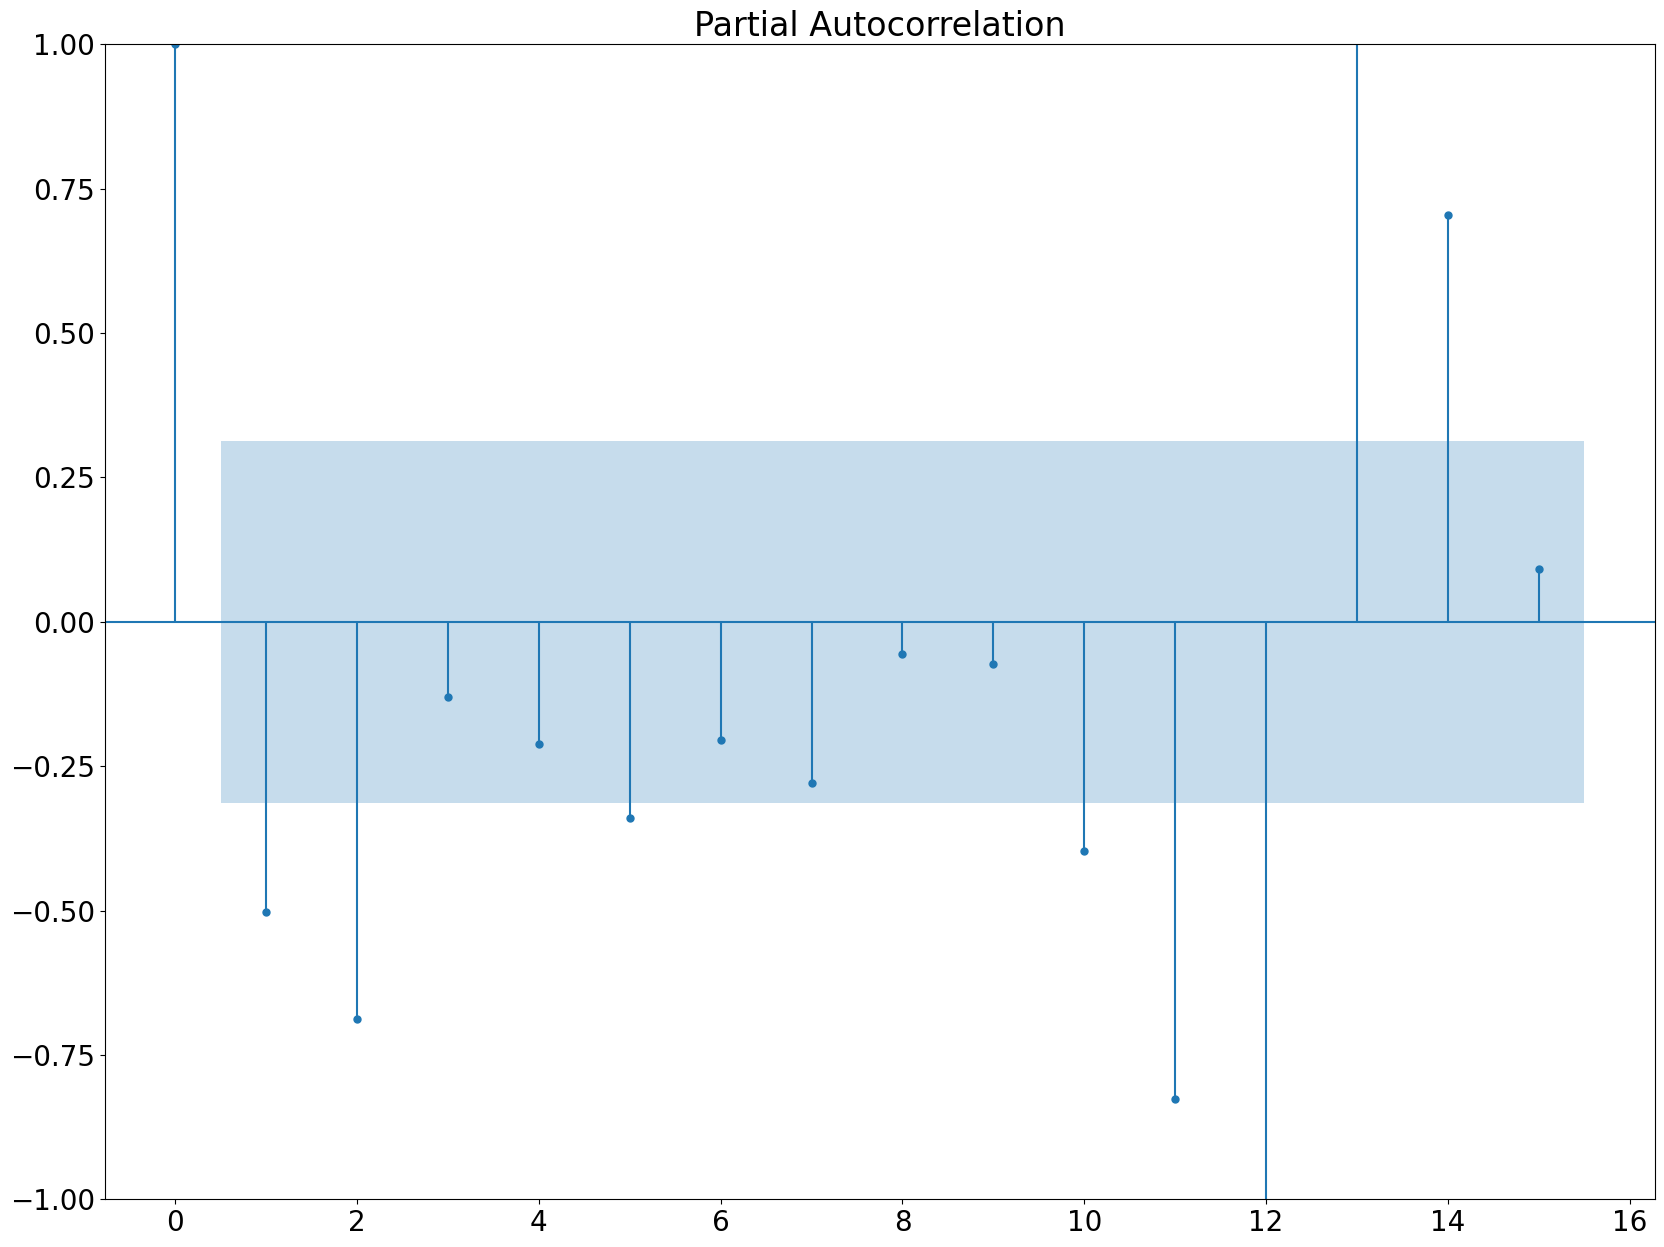

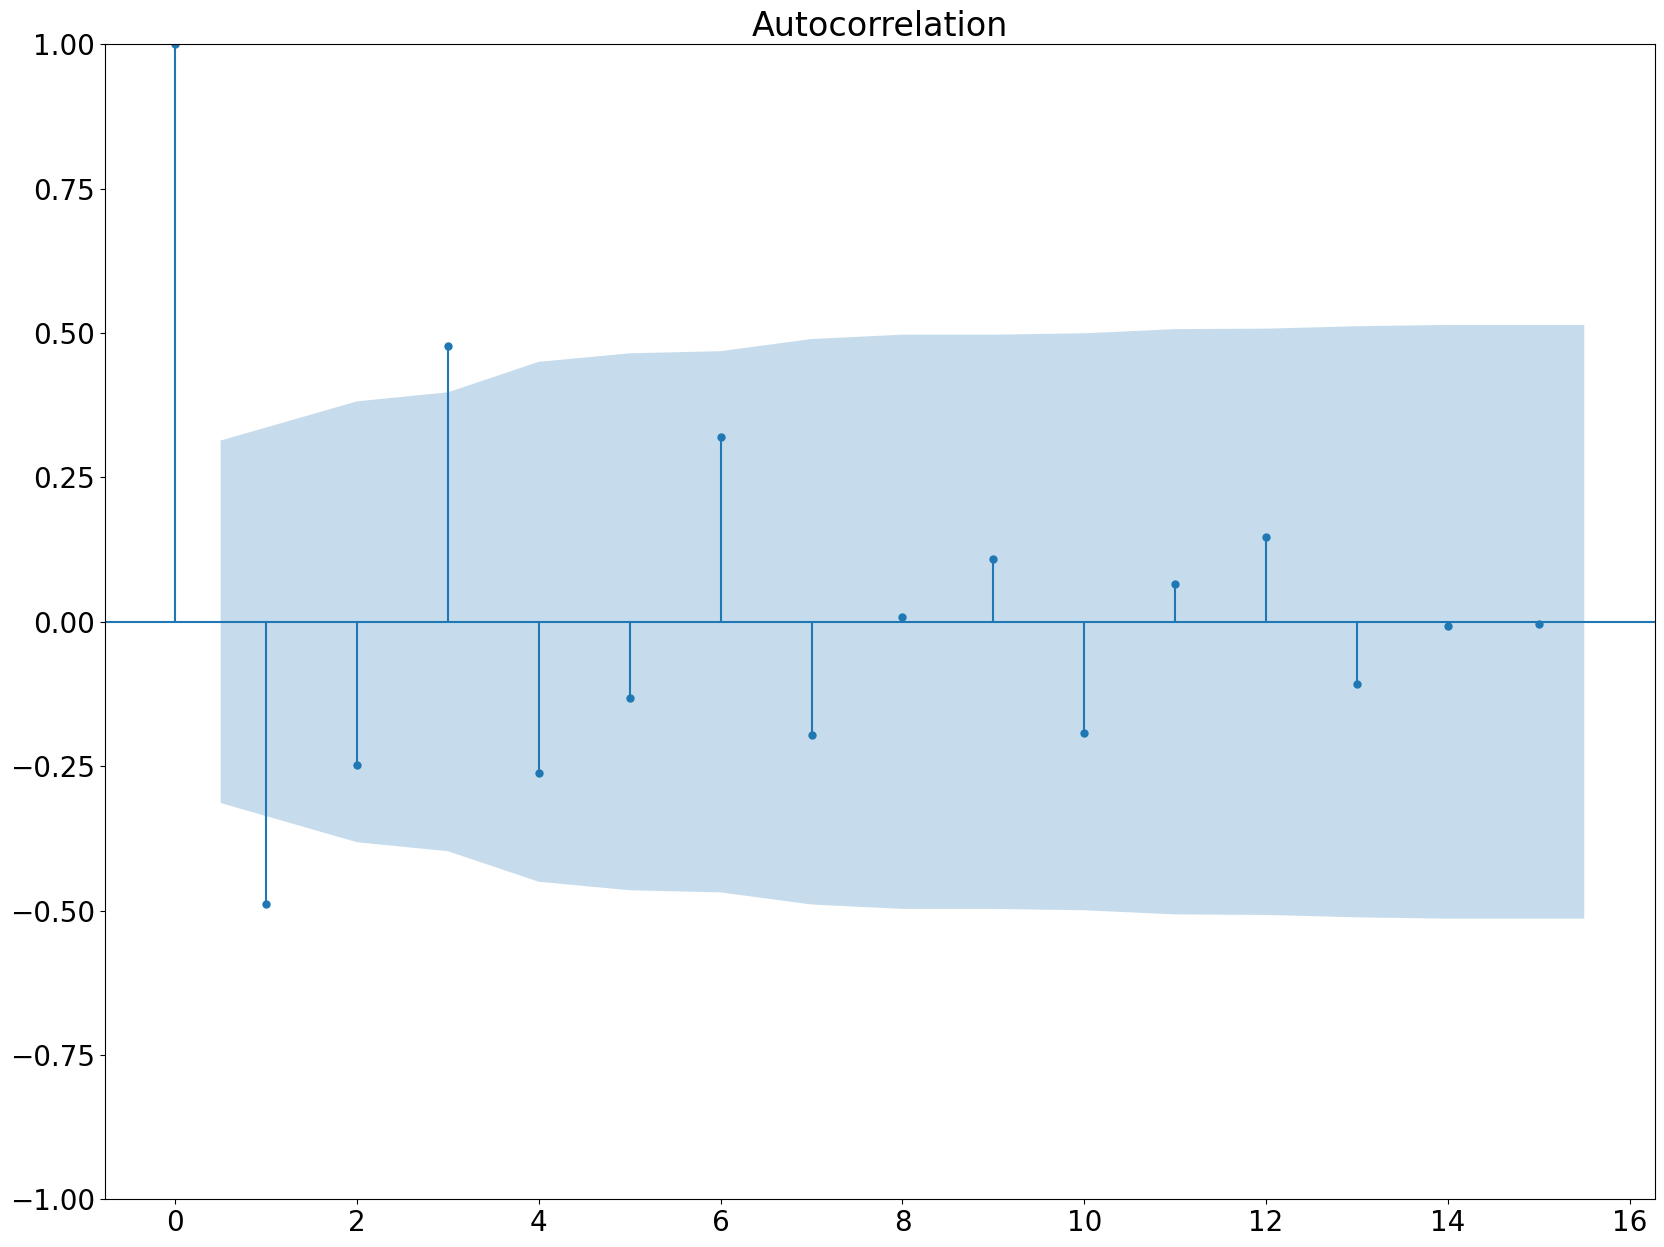

In [29]:
plot_pacf(df_china['Diff_Value'][1:] ,  lags = 15)
plot_acf(df_china['Diff_Value'][1:] ,  lags = 15)
plt.show()

**By see the pacf and acf plots we can have these pairs of orders for ARIMA model :- \
(1,0,1),(2,0,1),(2,0,0), (1,0,0),(0,0,1),(0,0,3),(1,0,3),(2,0,3), \
         (5,0,0), (10,0,0),(11,0,0), (12,0,0), \
         (5,0,1),(5,0,3),(10,0,1),(10,0,3),(11,0,1),(11,0,3),(12,0,1),(12,0,3)**

### Finding The Suitable Model

In [30]:
orders = [(1,0,1) , (1,0,3) , (2,0,1) , (2,0,3)]

for ar,ma in it.product([0,1,2,5,10,11,12],[0,1,3]):
    arima = ARIMA(df_china['Diff_Value'][1:] , order = (ar,0,ma))
    results = arima.fit()
    print(f'ARIMA{ar,0,ma} has LLF = {results.llf} and AIC = {results.aic}')

ARIMA(0, 0, 0) has LLF = -694.2761233832615 and AIC = 1392.552246766523
ARIMA(0, 0, 1) has LLF = -629.1059457663044 and AIC = 1264.211891532609
ARIMA(0, 0, 3) has LLF = -626.8334891879155 and AIC = 1263.666978375831
ARIMA(1, 0, 0) has LLF = -636.0050753117027 and AIC = 1278.0101506234055
ARIMA(1, 0, 1) has LLF = -628.53950013062 and AIC = 1265.07900026124
ARIMA(1, 0, 3) has LLF = -625.6323833928849 and AIC = 1263.2647667857698
ARIMA(2, 0, 0) has LLF = -624.3962704524777 and AIC = 1256.7925409049553
ARIMA(2, 0, 1) has LLF = -624.3145777006852 and AIC = 1258.6291554013703
ARIMA(2, 0, 3) has LLF = -620.1188409564445 and AIC = 1254.237681912889
ARIMA(5, 0, 0) has LLF = -622.2488965246896 and AIC = 1258.4977930493792
ARIMA(5, 0, 1) has LLF = -621.5713674337233 and AIC = 1259.1427348674465
ARIMA(5, 0, 3) has LLF = -619.2326784464813 and AIC = 1258.4653568929625
ARIMA(10, 0, 0) has LLF = -620.0905941152942 and AIC = 1264.1811882305883
ARIMA(10, 0, 1) has LLF = -619.2122475484143 and AIC = 126

**We can choose ARIMA(2,0,3)**

In [31]:
arima_china = ARIMA(df_china['Diff_Value'][1:] , order = (2,0,3))
results_china = arima_china.fit()

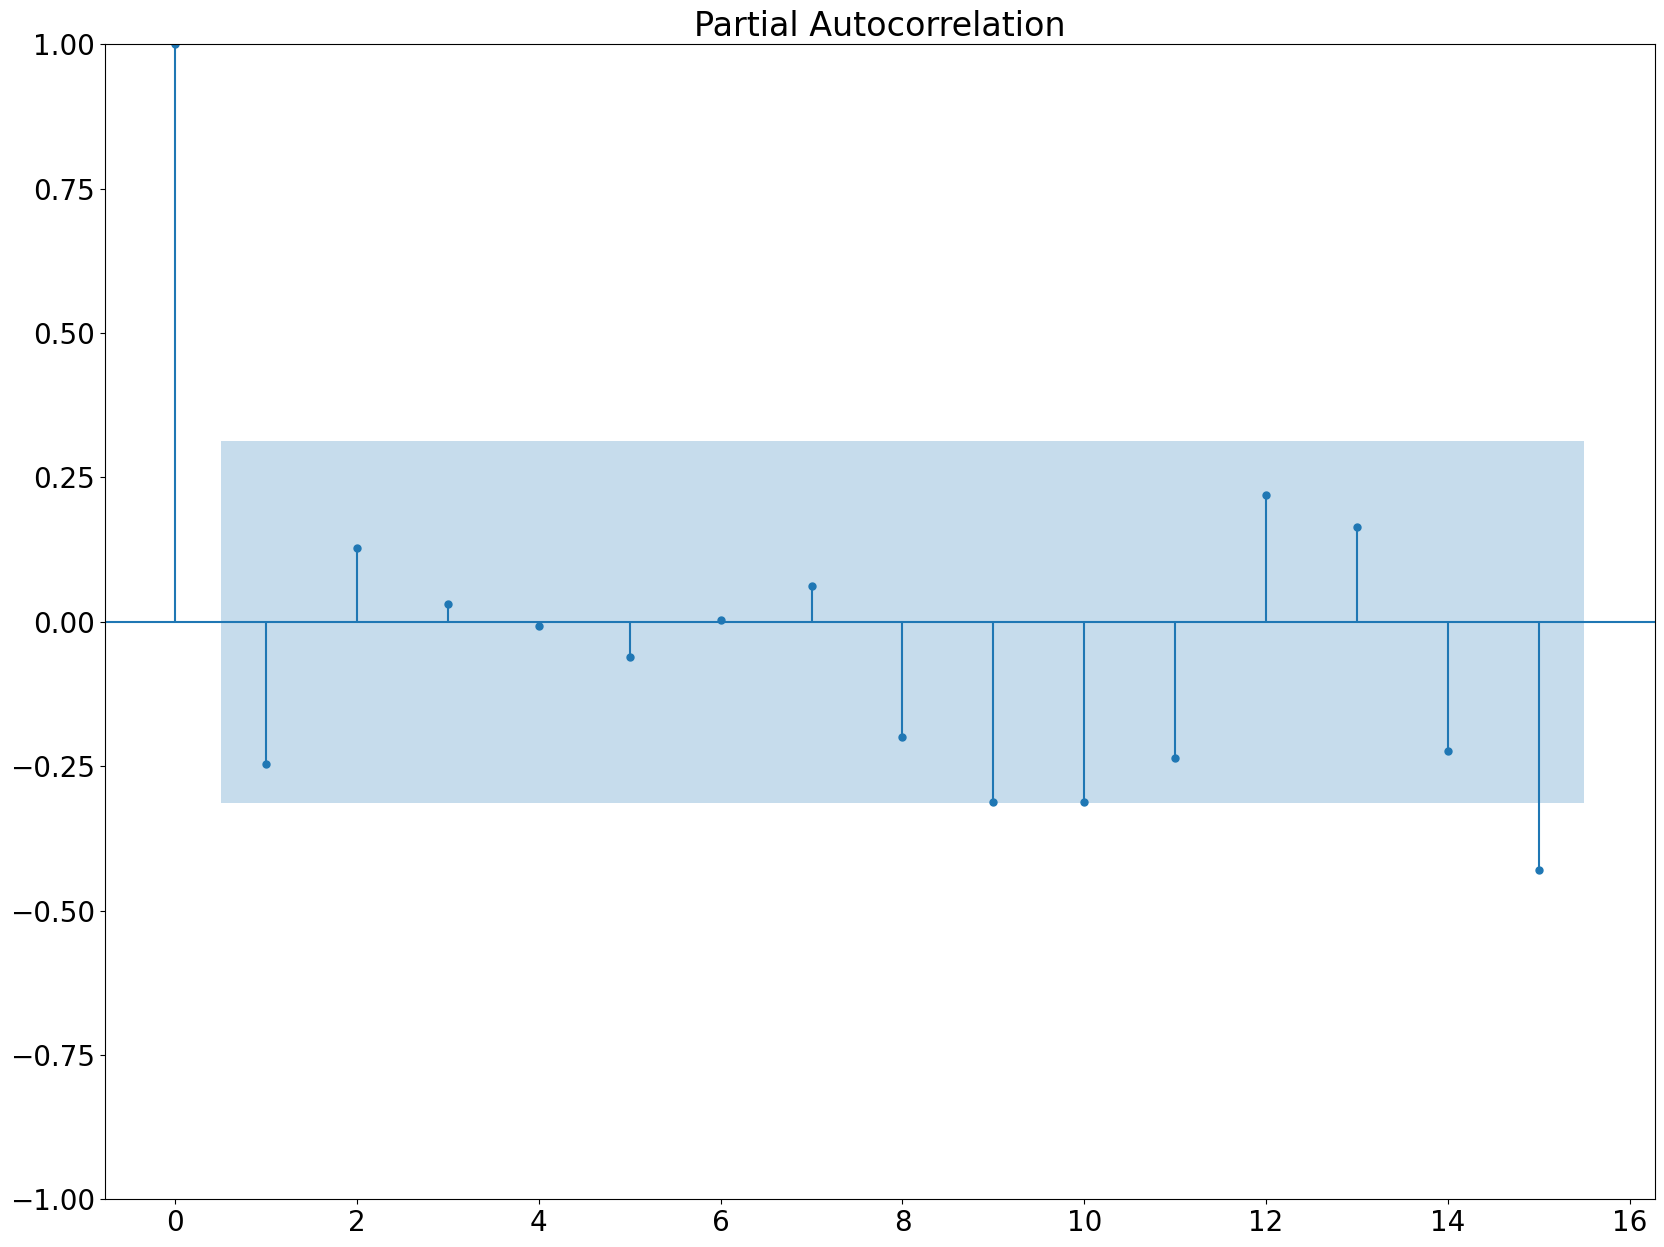

In [32]:
plot_pacf(results_china.resid , lags = 15)
plt.show()

#we can proceed since there are no lags

### Forecasting Future Values

In [33]:
# Lets forecast for next 15 months
differences = results_china.forecast(steps = 15).values.tolist()

# Store the data values for calculating values from forecast values
values = df_china['Value'].values.tolist()
len(values)

40

**Formula to calculate original values from differences**

**$ value_{t} = diff_{t} + value_{t-1} $**

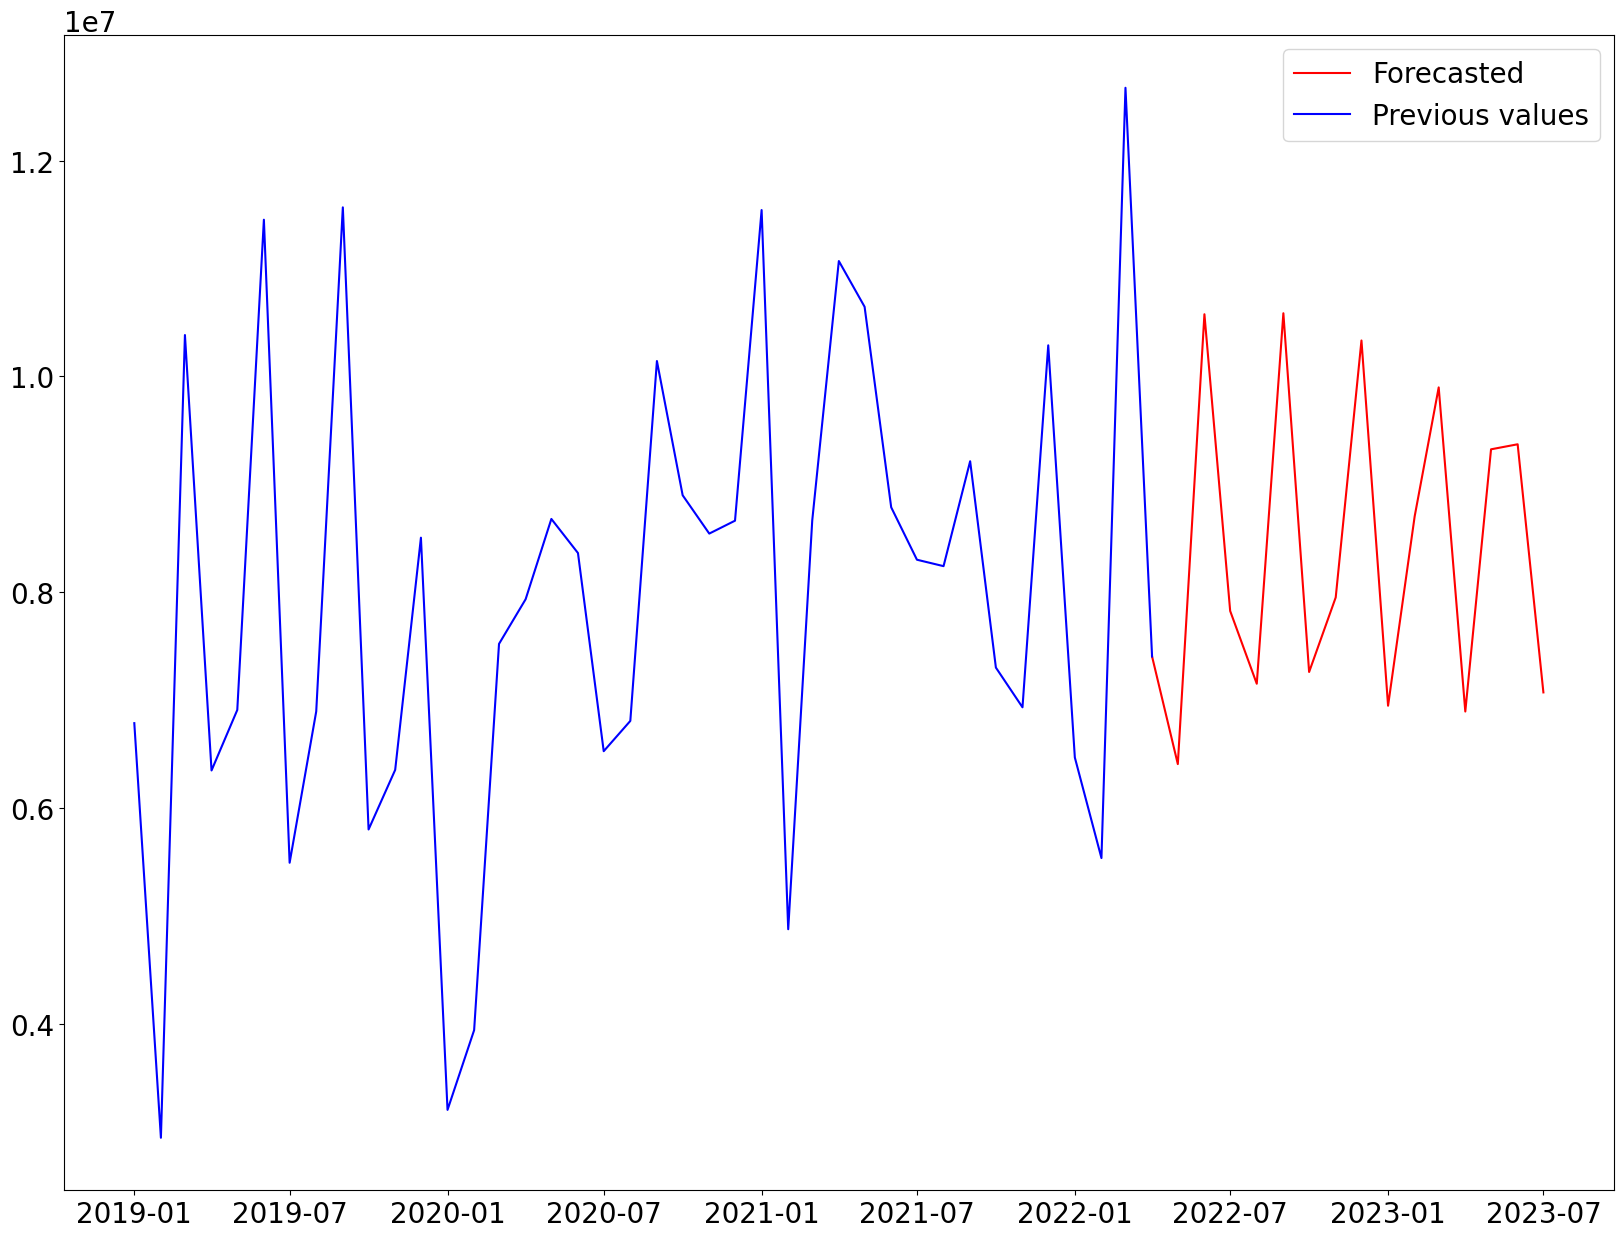

In [34]:
for diff in differences:
    val = diff + values[-1]
    values.append(round(val))
    
plt.plot(pd.DataFrame({'Date':dates , 'Value':values[39:]}).set_index('Date'), label = 'Forecasted' , color = 'red')
plt.plot(df_china[['Value']] , label = 'Previous values' ,color = 'blue')
plt.legend()
plt.show()

In [35]:
forecast_df['China'] = values[40:]

In [36]:
# joblib.dump(results_china , 'Model_China.pkl')

# Germany Country Analysis

### Data Preparation

In [58]:
df_germany=data[data.Country == 'Germany'].drop('Country',axis = 1).set_index('Date').astype(int)
df_germany.head()

,Value
Date,
2019-01-01,37362308
2019-02-01,23448750
2019-03-01,41479346
2019-04-01,26591457
2019-05-01,21957327


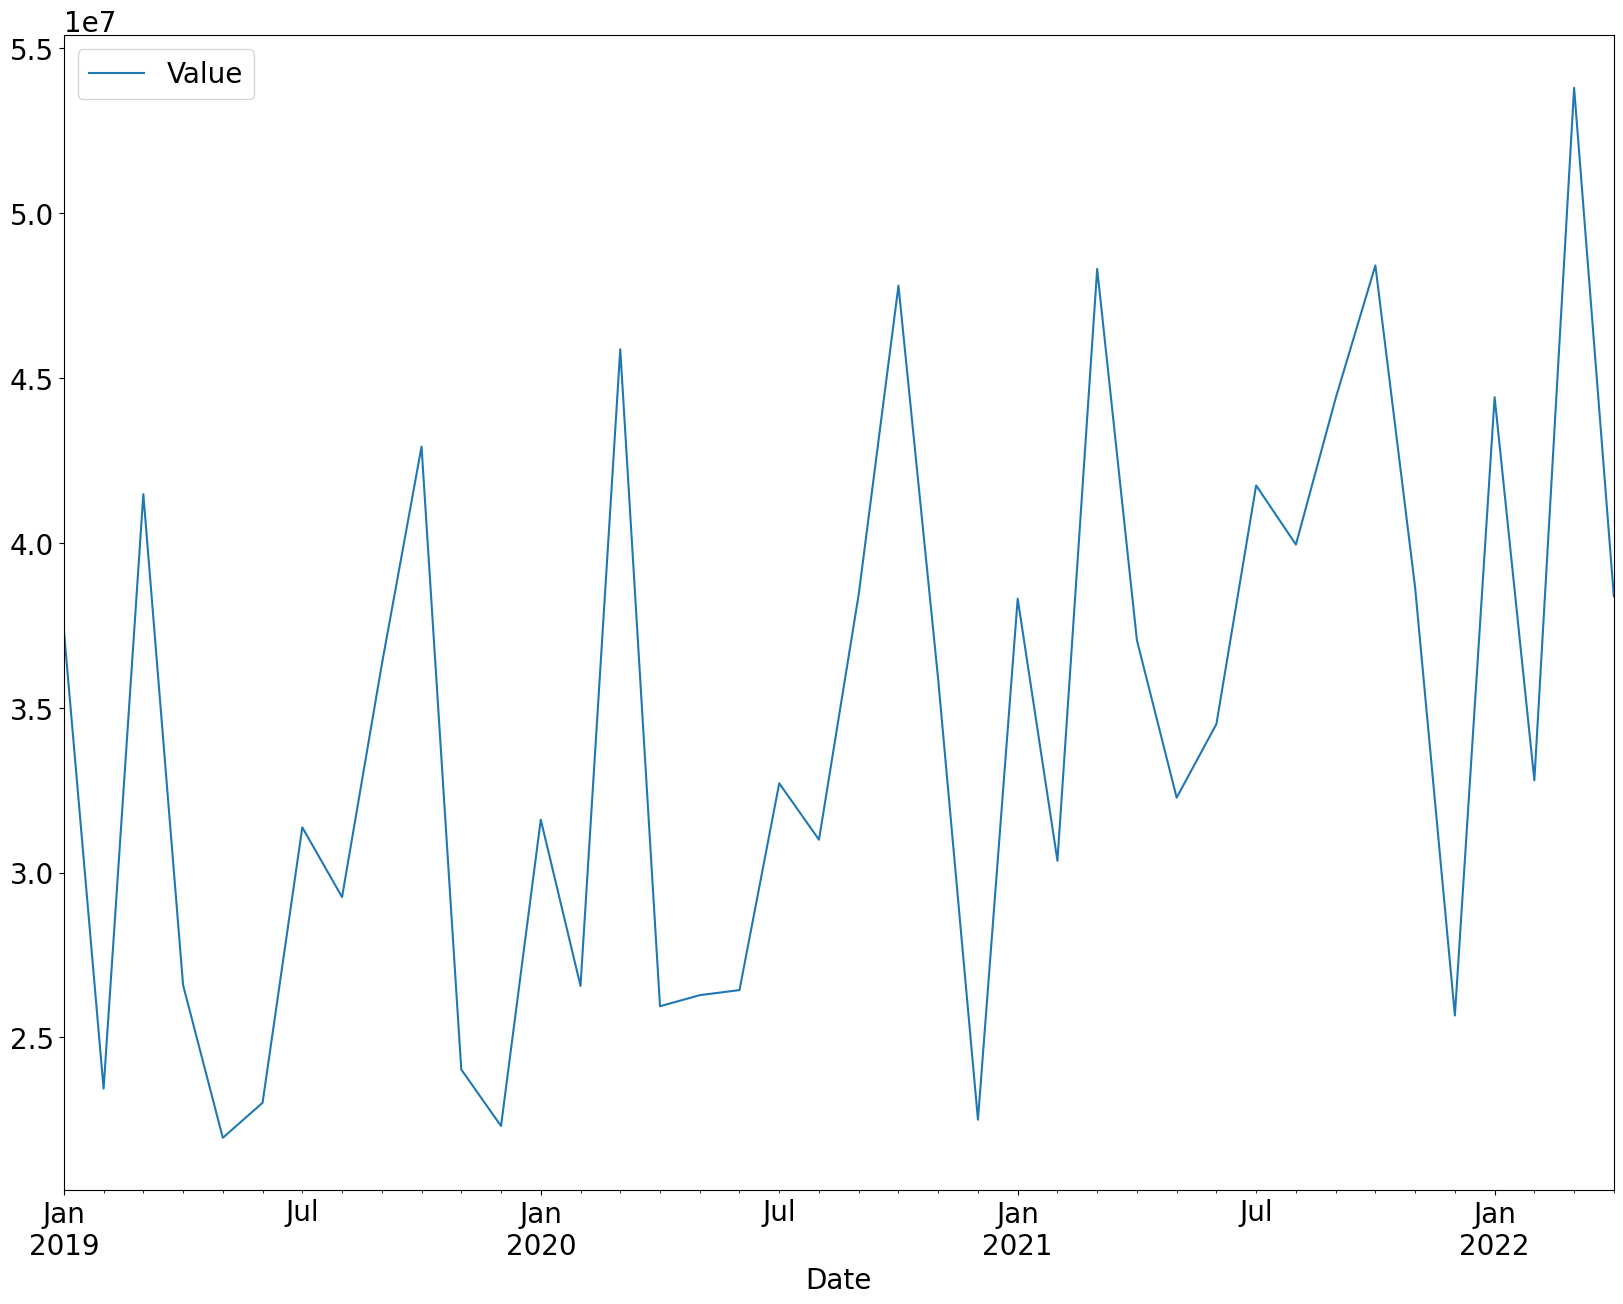

In [59]:
df_germany.plot()
plt.show()

<AxesSubplot:>

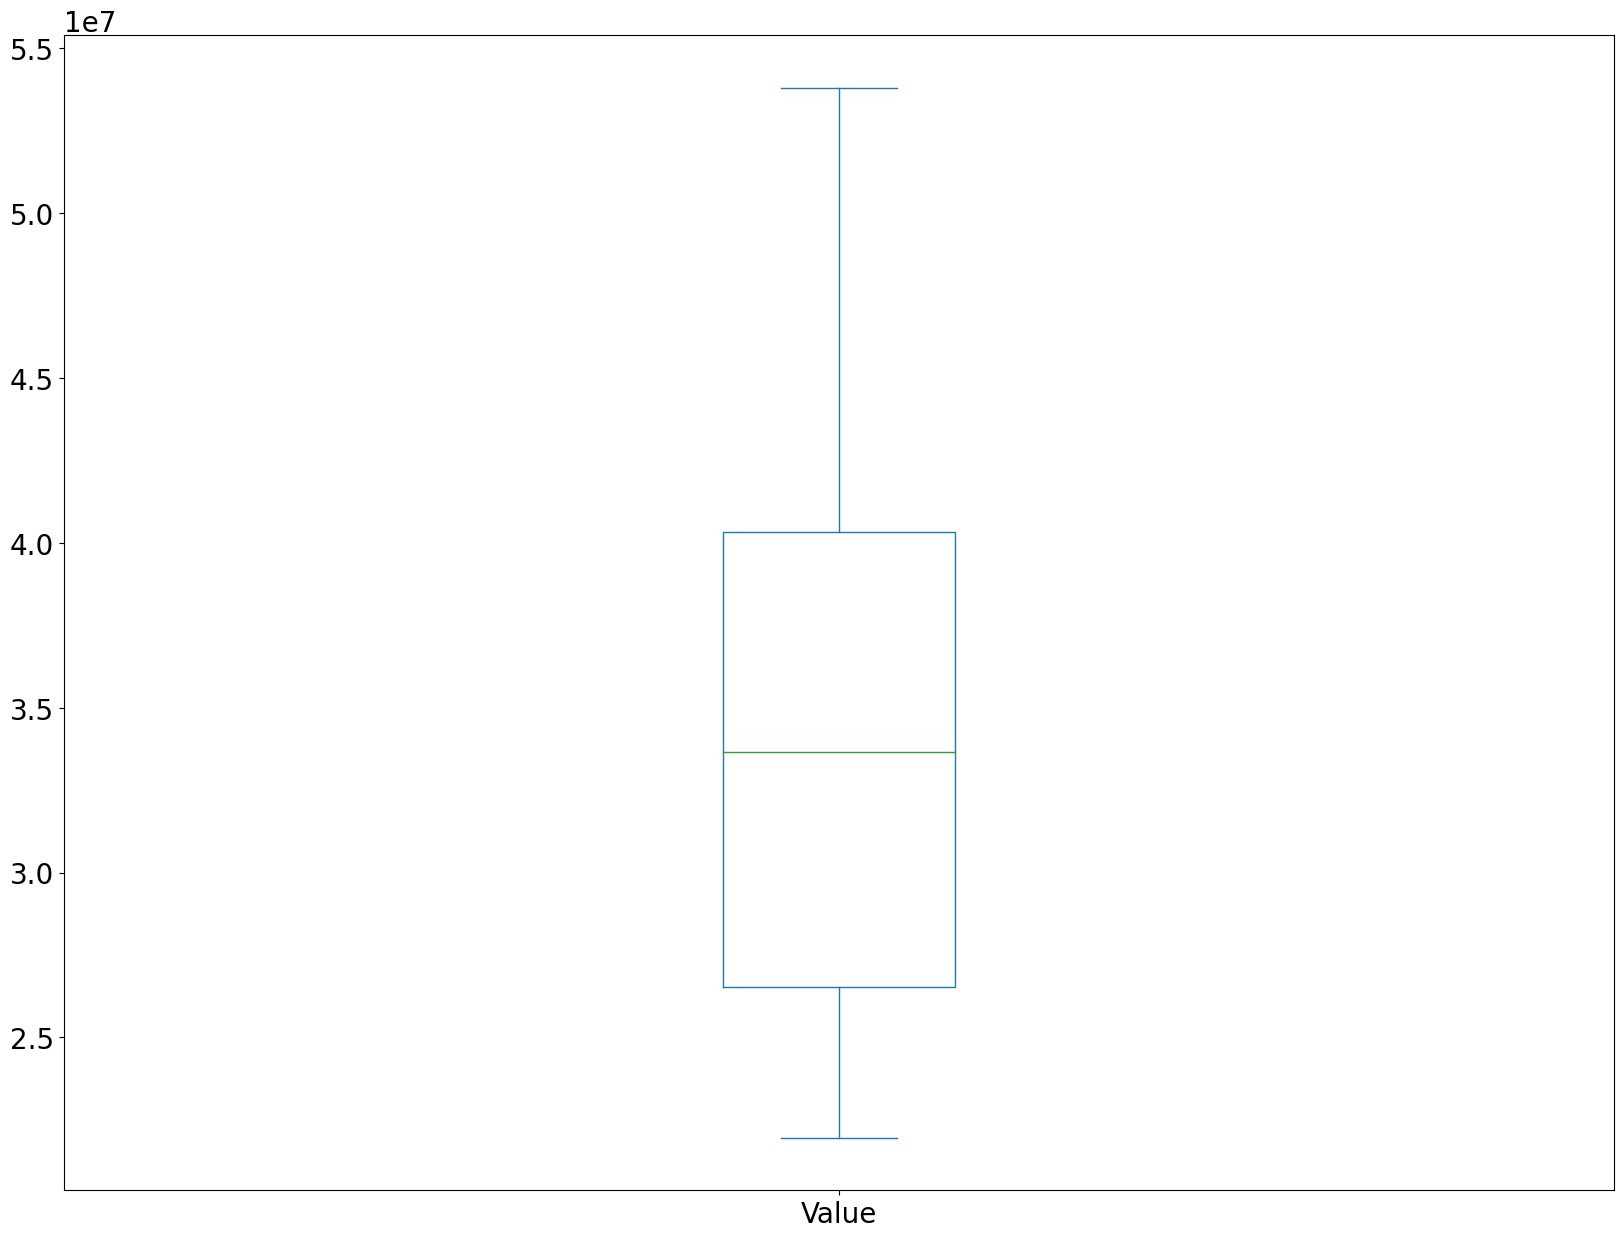

In [60]:
# Bounding the outliers

IQR(df_germany ,  'Value')
df_germany['Value'].plot(kind = 'box')

### Seasonal Decomposition Of Data

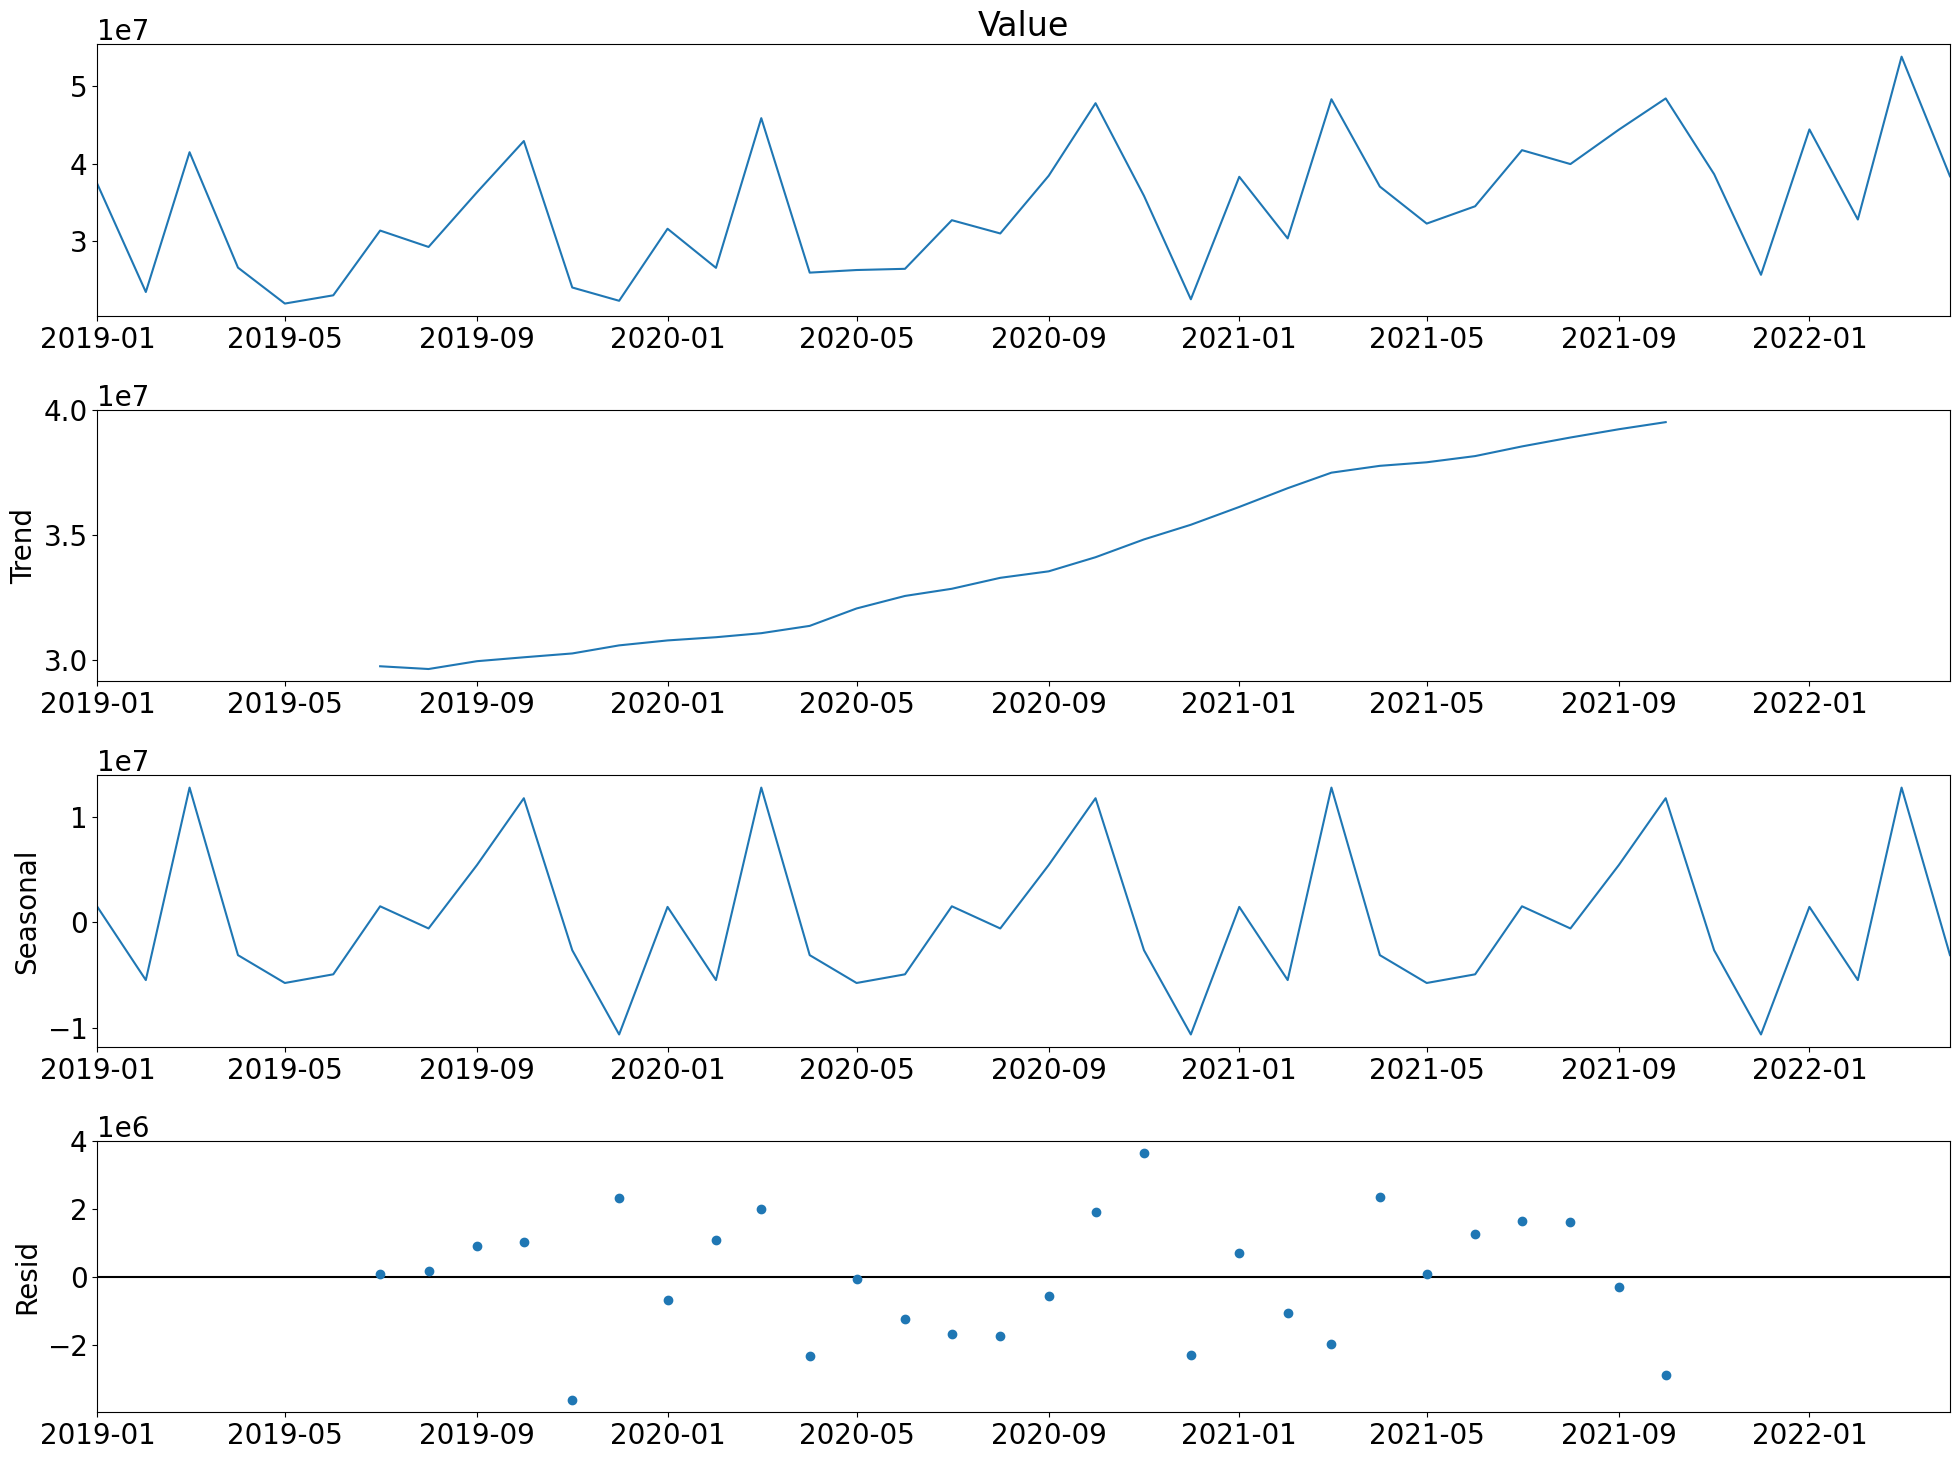

In [61]:
decomposition = seasonal_decompose(df_germany['Value'] , model = 'additive')
decomposition.plot()

plt.show()

### Check For Stationarity :-  A D-Fuller Test

In [62]:
result = sts.adfuller(df_germany['Value'])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -0.7093420524695137
n_lags: 6
p_value: 0.8443148731922288
Critical Values :
1% , -3.6461350877925254
Critical Values :
5% , -2.954126991123355
Critical Values :
10% , -2.6159676124885216


**Since p_value > 0.05 We can't reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Non-Stationary**
**Let's take the Returns of the values**
**Since Taking Difference didn't worked well on forecasting i choose to use Returns**

### Creating Returns and Plotting ACF

In [63]:
# Since Taking Difference didn't worked well on forecasting i choose to use Returns

In [64]:
df_germany['Return'] = df_germany['Value'].pct_change(1).mul(100)
df_germany.head()

,Value,Return
Date,,
2019-01-01,37362308.0,NaN
2019-02-01,23448750.0,-37.239557
2019-03-01,41479346.0,76.893634
2019-04-01,26591457.0,-35.892294
2019-05-01,21957327.0,-17.427138


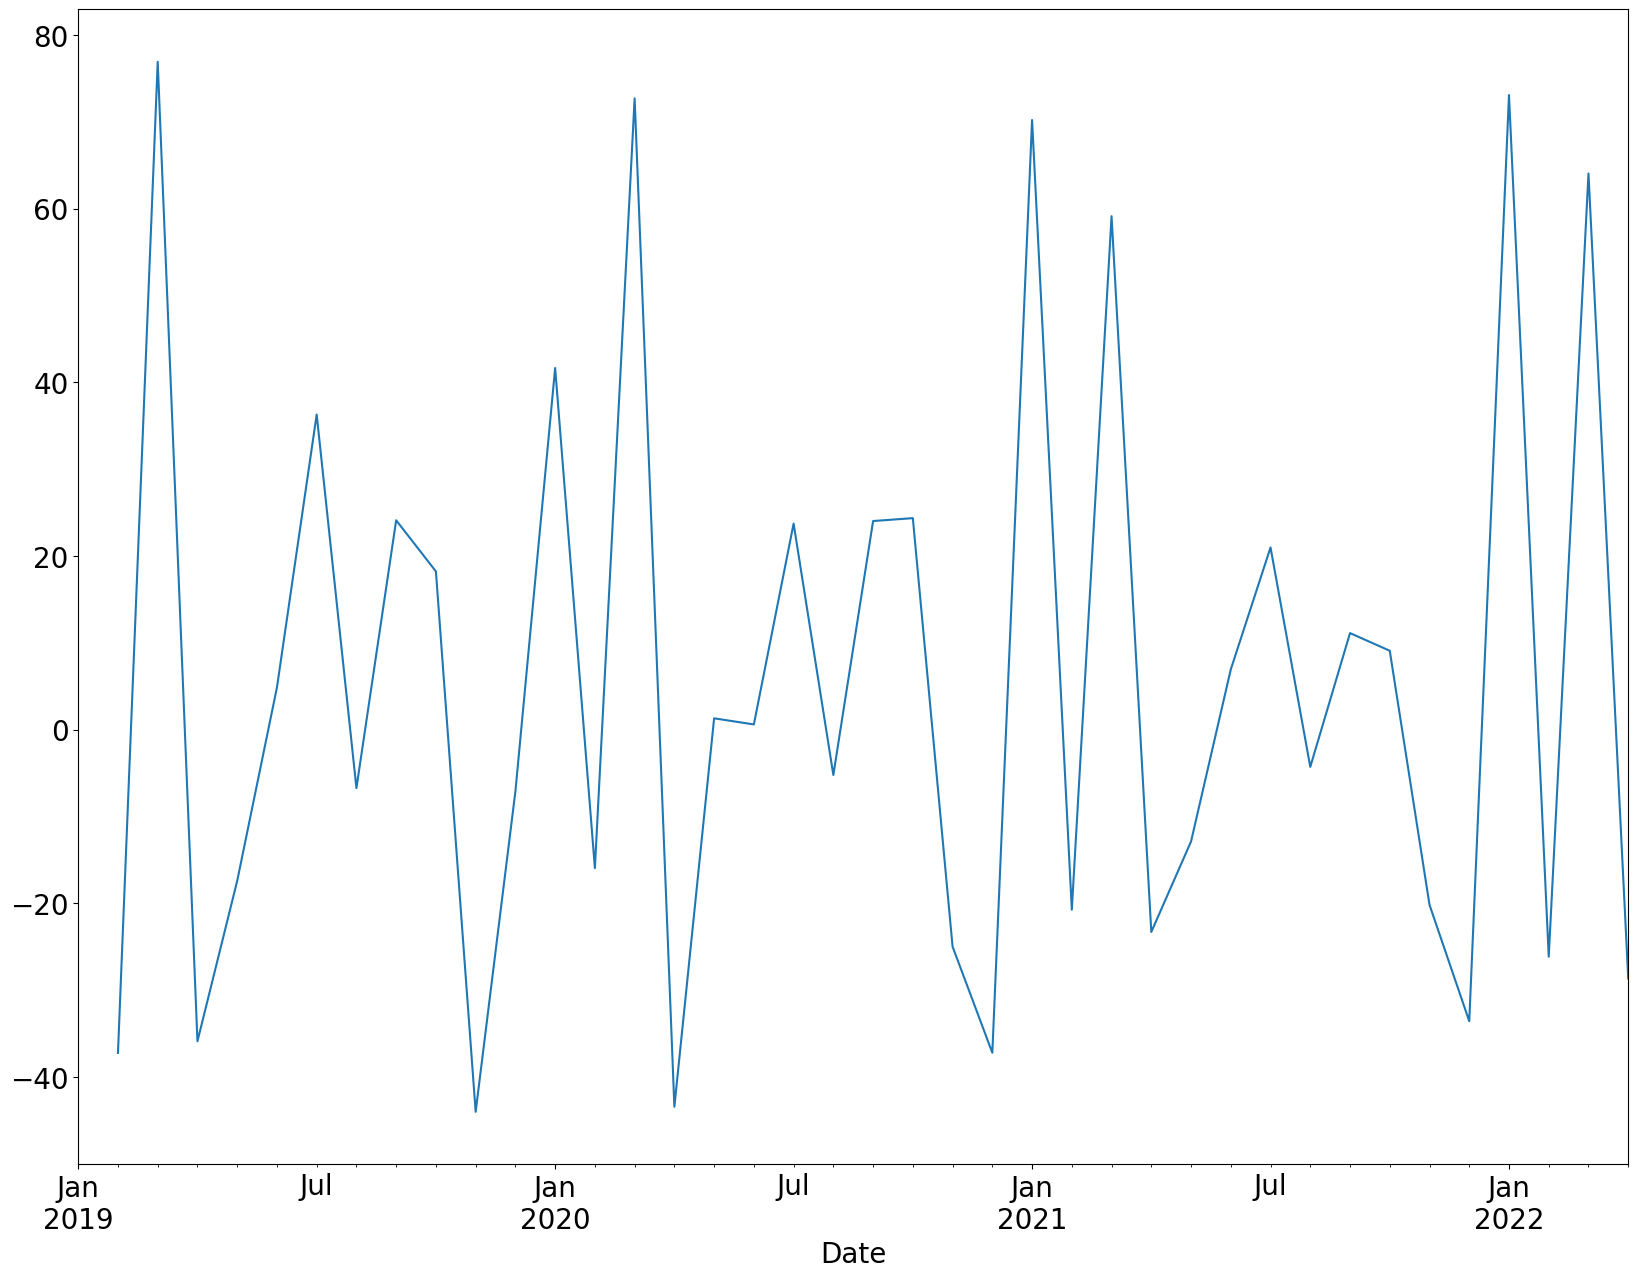

In [65]:
df_germany['Return'].plot()
plt.show()

In [27]:
result = sts.adfuller(df_germany['Return'][1:])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -5.500007743348371
n_lags: 10
p_value: 2.0815346300135427e-06
Critical Values :
1% , -3.6889256286443146
Critical Values :
5% , -2.9719894897959187
Critical Values :
10% , -2.6252957653061224


**Since p_value < 0.05 We reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Stationary**

### Auto Correlation Function

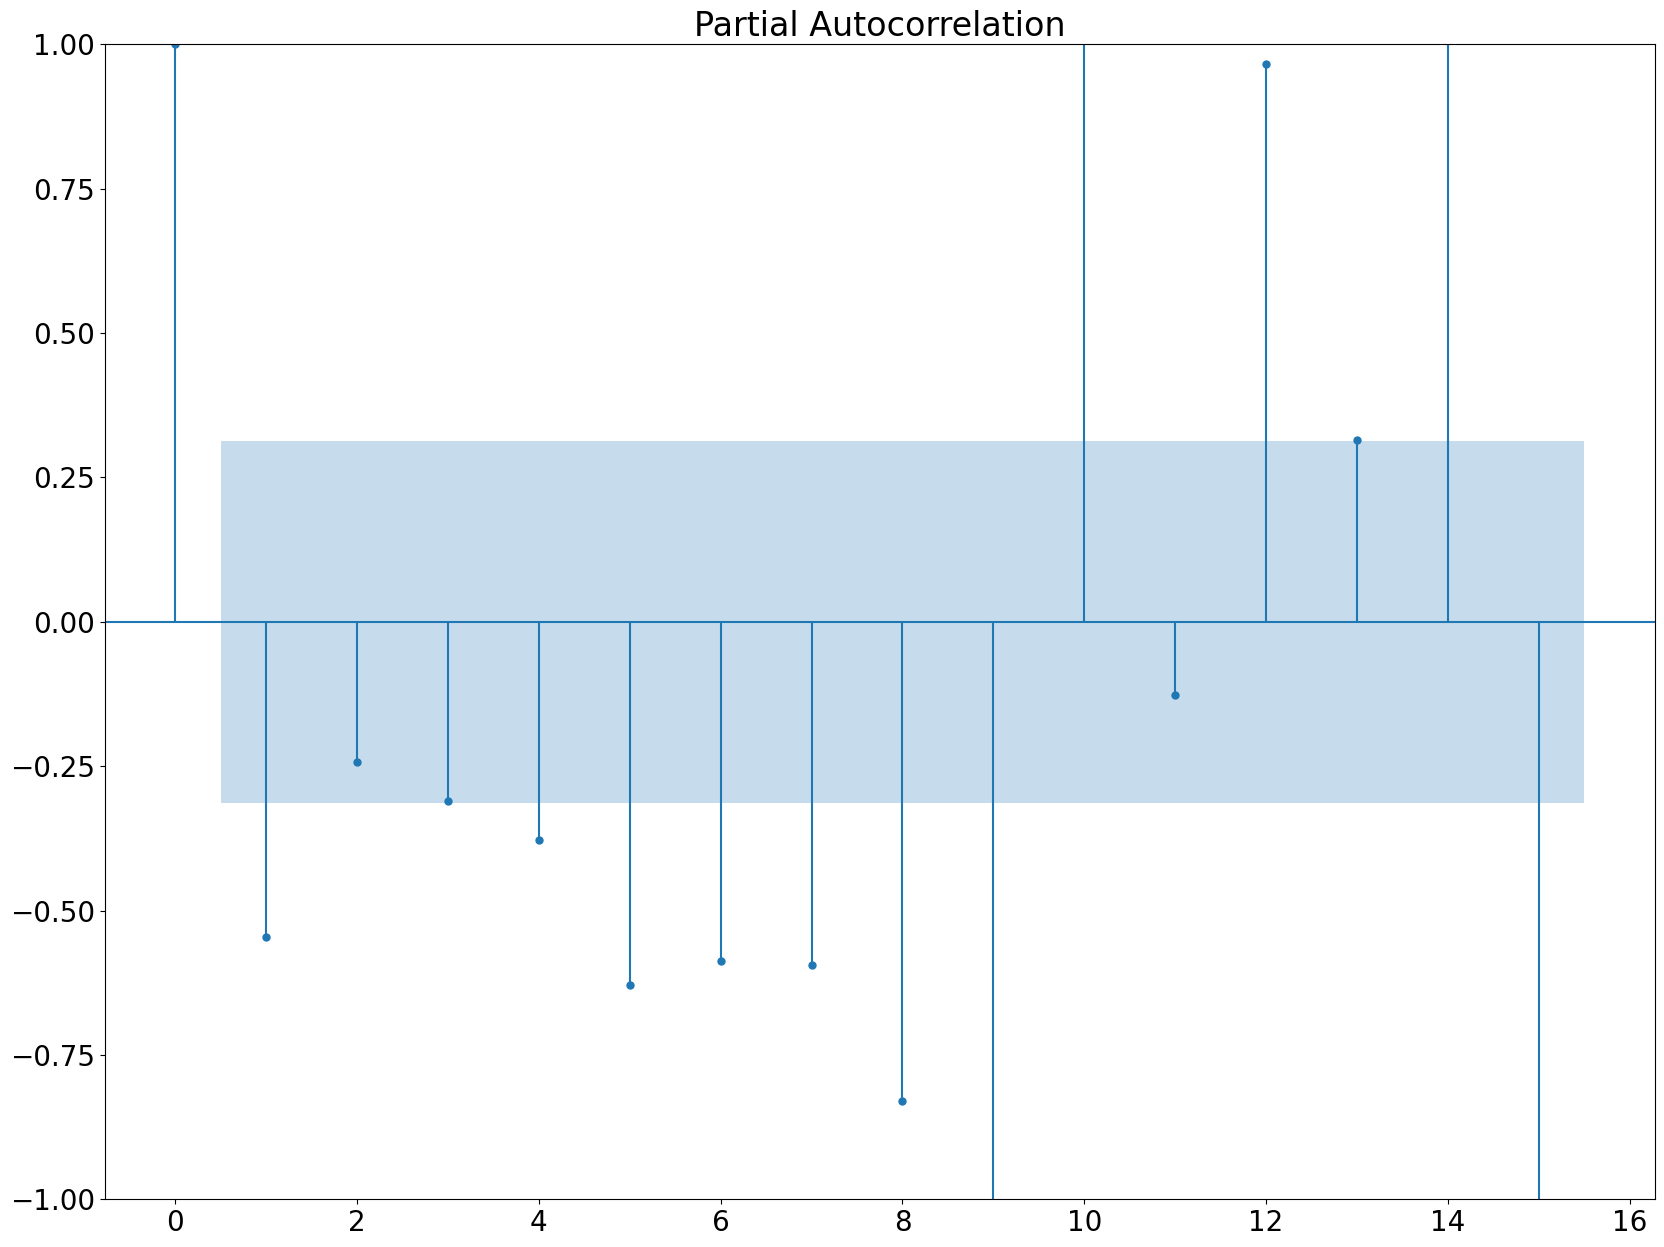

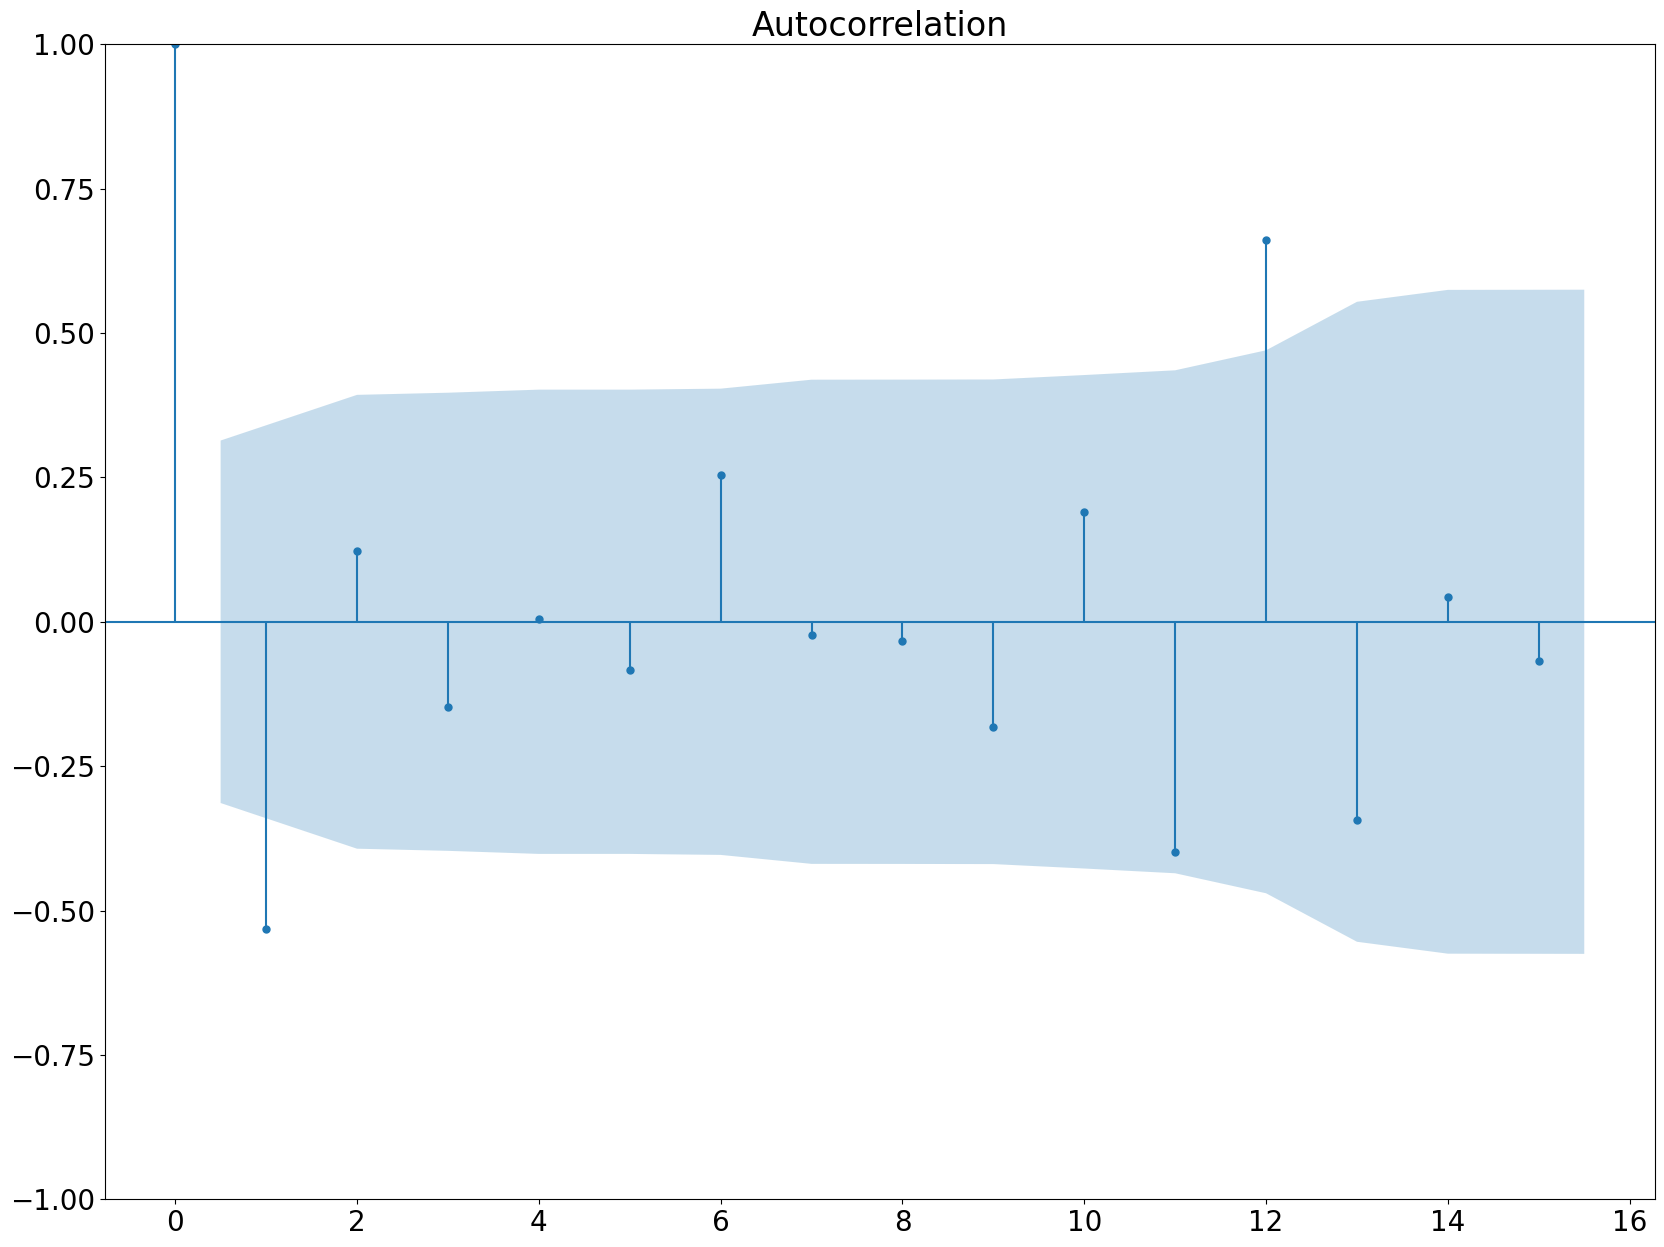

In [28]:
plot_pacf(df_germany['Return'][1:] ,  lags = 15)
plot_acf(df_germany['Return'][1:] ,  lags = 15)
plt.show()

**The possible pairs of orders for ARIMA model can be :- \
AR = [1,4,5,6,7,8,9,10,11,12] \
MA = [0,1]** 

### Finding The Suitable Model

In [46]:
for ar,ma in it.product([1,4,5,6,7,8,9,10,11,12],[0,1]):
    arima = ARIMA(df_germany['Return'][1:] , order = (ar,0,ma))
    results = arima.fit()
    print(f"ARIMA{ar ,0, ma} has LLF = {results.llf} and AIC = {results.aic}")

ARIMA(1, 0, 0) has LLF = -187.06878000262245 and AIC = 380.1375600052449
ARIMA(1, 0, 1) has LLF = -179.4098852441754 and AIC = 366.8197704883508
ARIMA(4, 0, 0) has LLF = -182.53618223437437 and AIC = 377.07236446874873
ARIMA(4, 0, 1) has LLF = -175.95024141097068 and AIC = 365.90048282194135
ARIMA(5, 0, 0) has LLF = -175.20848917644122 and AIC = 364.41697835288244
ARIMA(5, 0, 1) has LLF = -173.90023287147974 and AIC = 363.8004657429595
ARIMA(6, 0, 0) has LLF = -173.46849229752104 and AIC = 362.9369845950421
ARIMA(6, 0, 1) has LLF = -173.40147566529757 and AIC = 364.80295133059514
ARIMA(7, 0, 0) has LLF = -173.46814702831708 and AIC = 364.93629405663415
ARIMA(7, 0, 1) has LLF = -172.67130636527082 and AIC = 365.34261273054165
ARIMA(8, 0, 0) has LLF = -173.06992394335953 and AIC = 366.13984788671905
ARIMA(8, 0, 1) has LLF = -172.5126983239501 and AIC = 367.0253966479002
ARIMA(9, 0, 0) has LLF = -172.78901934668957 and AIC = 367.57803869337914
ARIMA(9, 0, 1) has LLF = -170.8082709997895 a

**After making some analysis let's choose ARIMA(12,0,1)**

In [47]:
arima_germany = ARIMA(df_germany['Return'][1:] , order = (12,0,1))
results_germany = arima_germany.fit()

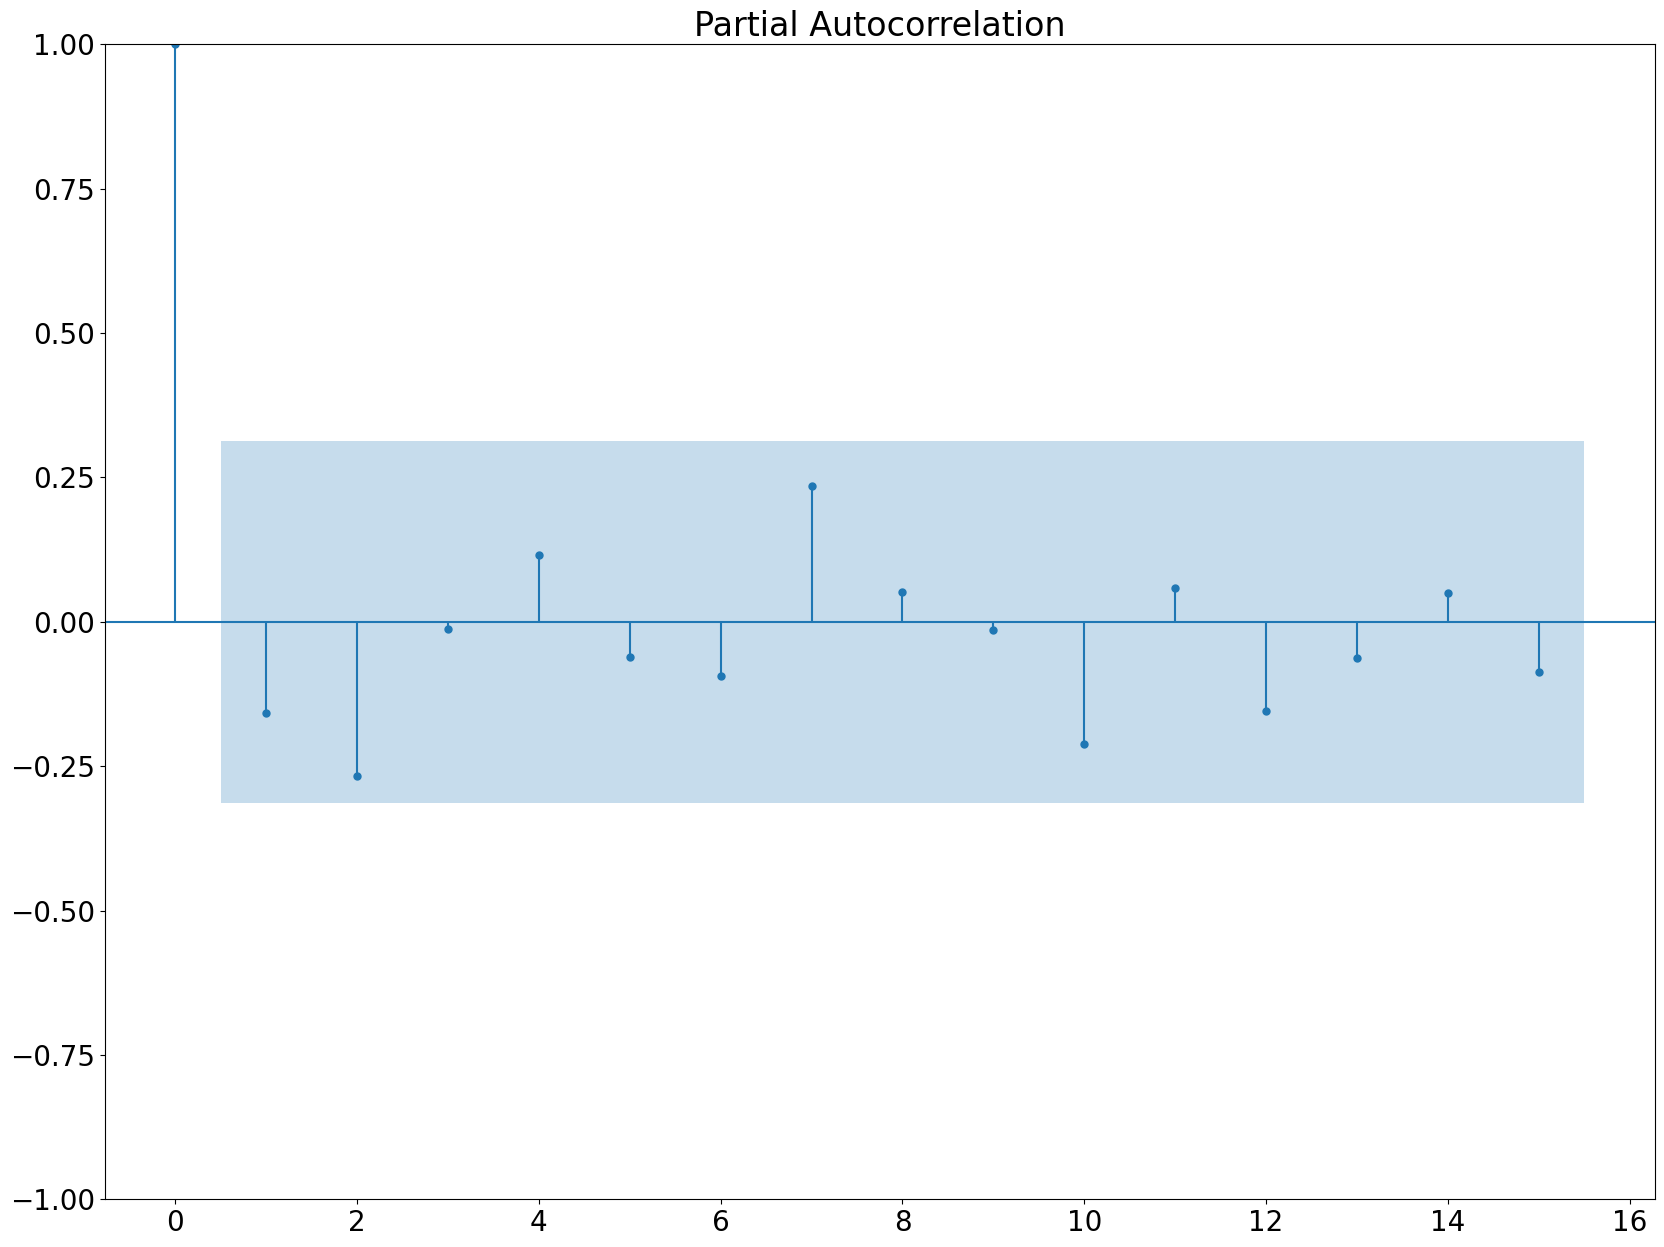

In [48]:
plot_pacf(results_germany.resid , lags = 15)
plt.show()

#we can ignore that 6 because even if we take ARIMA(6,0,0) it will be present

### Forecasting Future Values

In [49]:
# Lets forecast for next 15 months
returns = results_germany.forecast(steps = 15).values.tolist()

# Store the data values for calculating values from forecasted values
values = df_germany['Value'].values.tolist()
len(values)

40

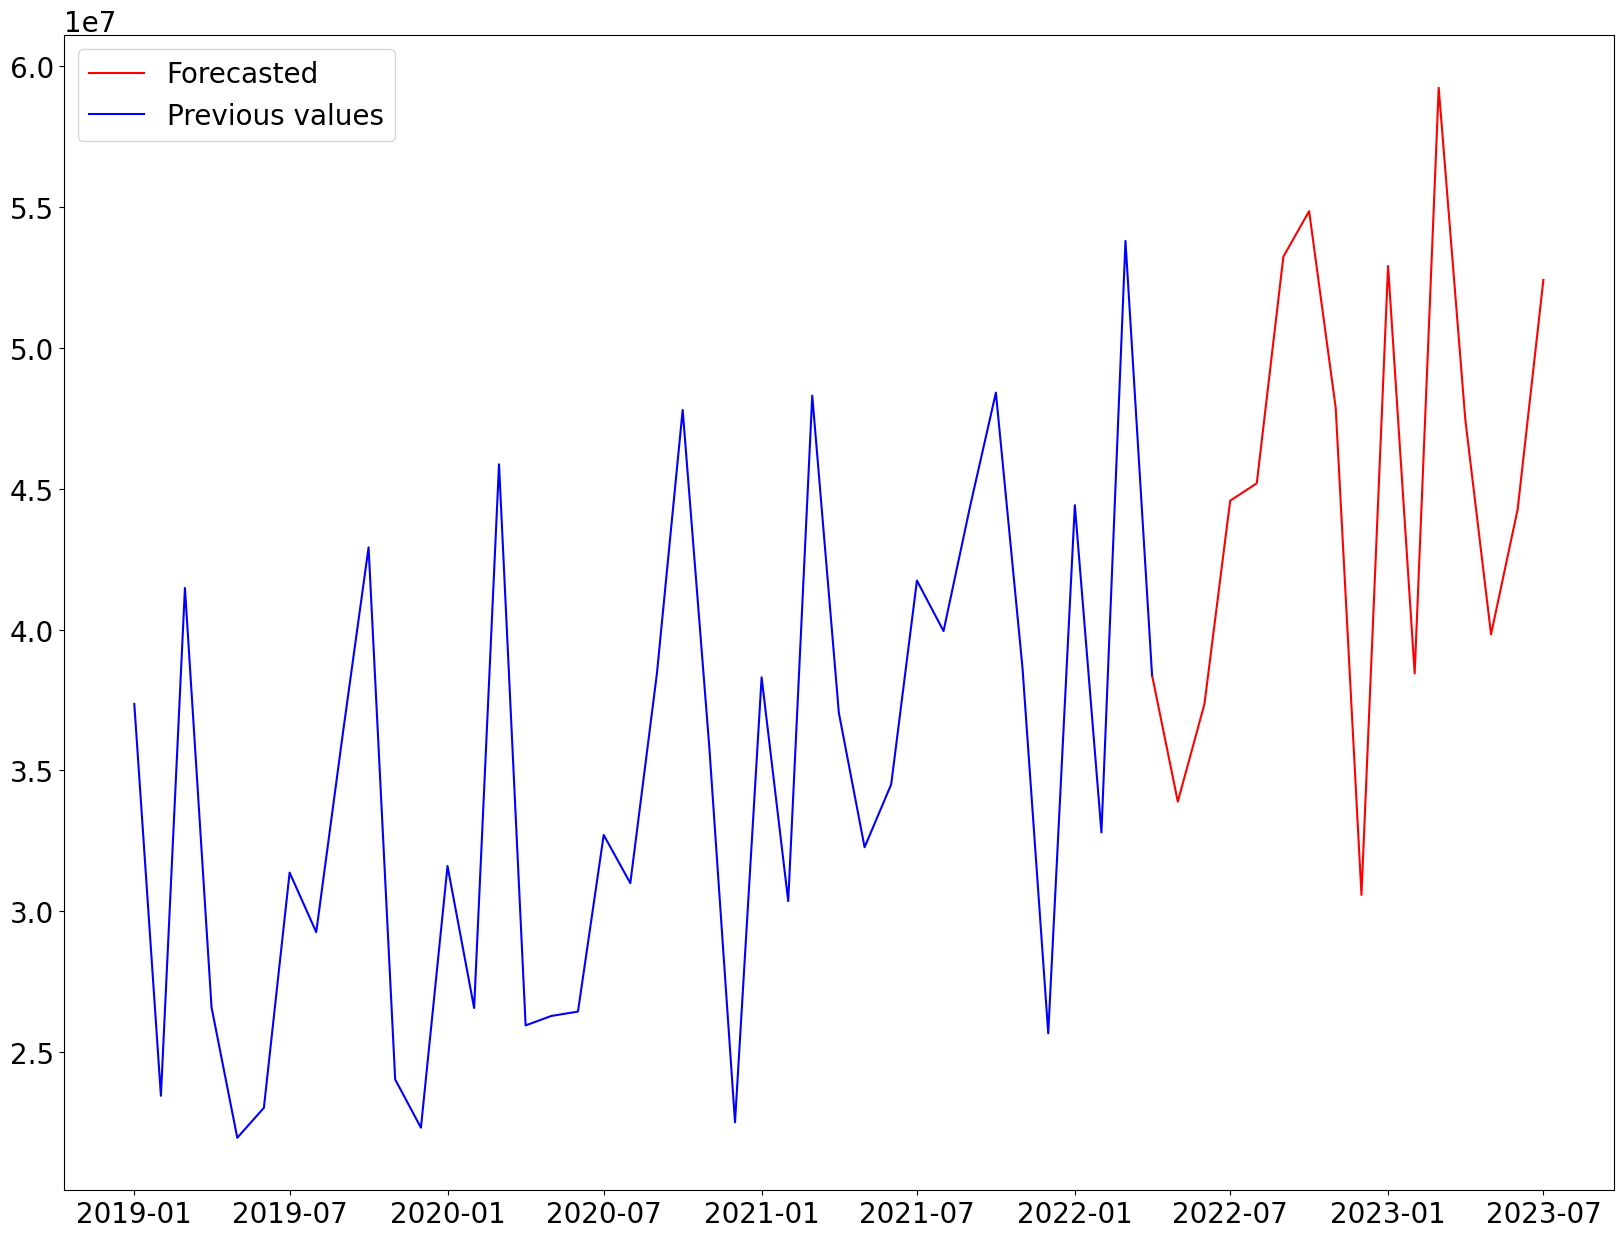

In [50]:
for ret in returns:
    ret = ret/100
    last = values[-1]
    res = (last*ret)+last
    values.append(round(res))
    
plt.plot(pd.DataFrame({'Date':dates , 'Value':values[39:]}).set_index('Date'), label = 'Forecasted' , color = 'red')
plt.plot(df_germany[['Value']] , label = 'Previous values' ,color = 'blue')
plt.legend()
plt.show()

In [51]:
# forecast_df['Germany'] = values[40:]

In [52]:
# joblib.dump(results_germany , 'Model_Germany.pkl')

# USA Country Analysis

### Data Preparation

In [73]:
df_usa=data[data.Country == 'USA'].drop('Country',axis = 1).set_index('Date').astype(int)
df_usa.head()

,Value
Date,
2019-01-01,27164329
2019-02-01,24954357
2019-03-01,25969580
2019-04-01,30632226
2019-05-01,32710665


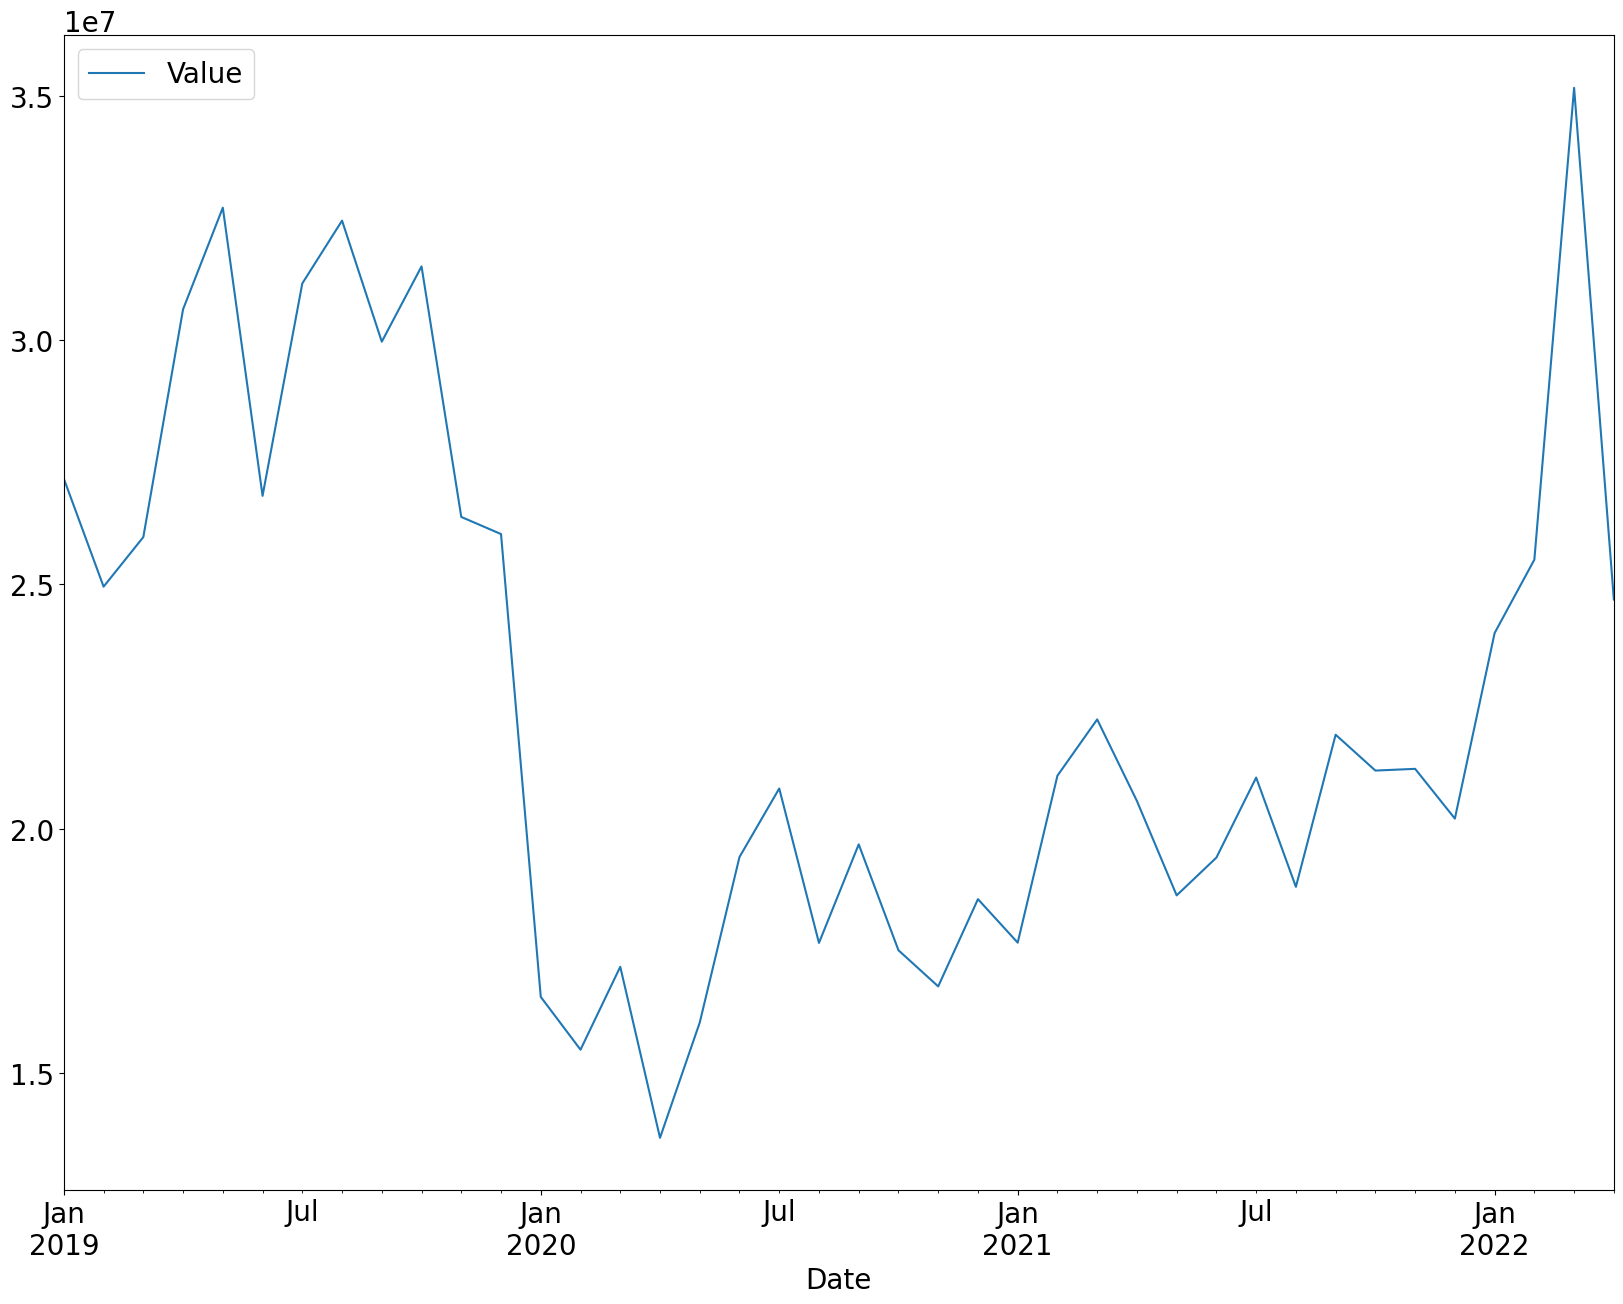

In [74]:
df_usa.plot()
plt.show()

<AxesSubplot:>

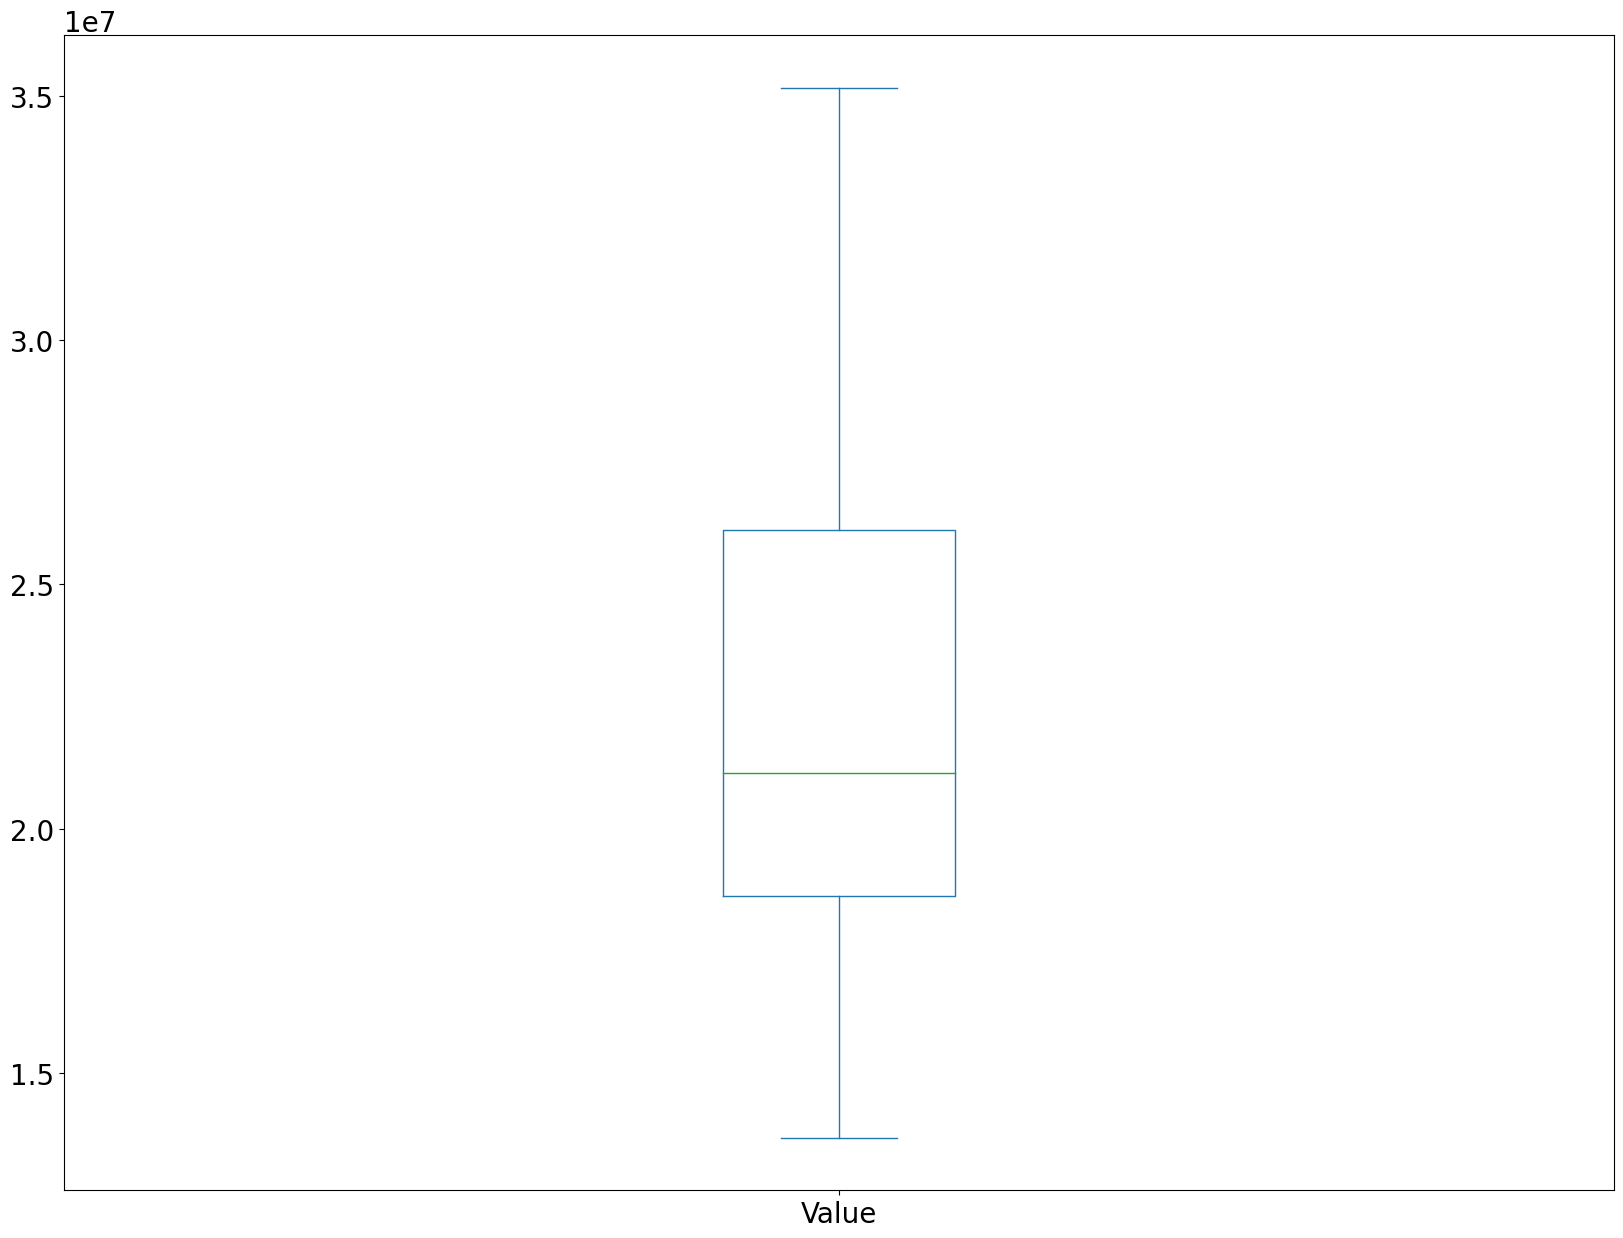

In [56]:
# Bounding the outlier

IQR(df_usa ,  'Value')
df_usa['Value'].plot(kind = 'box')

### Seasonal Decomposition Of Data

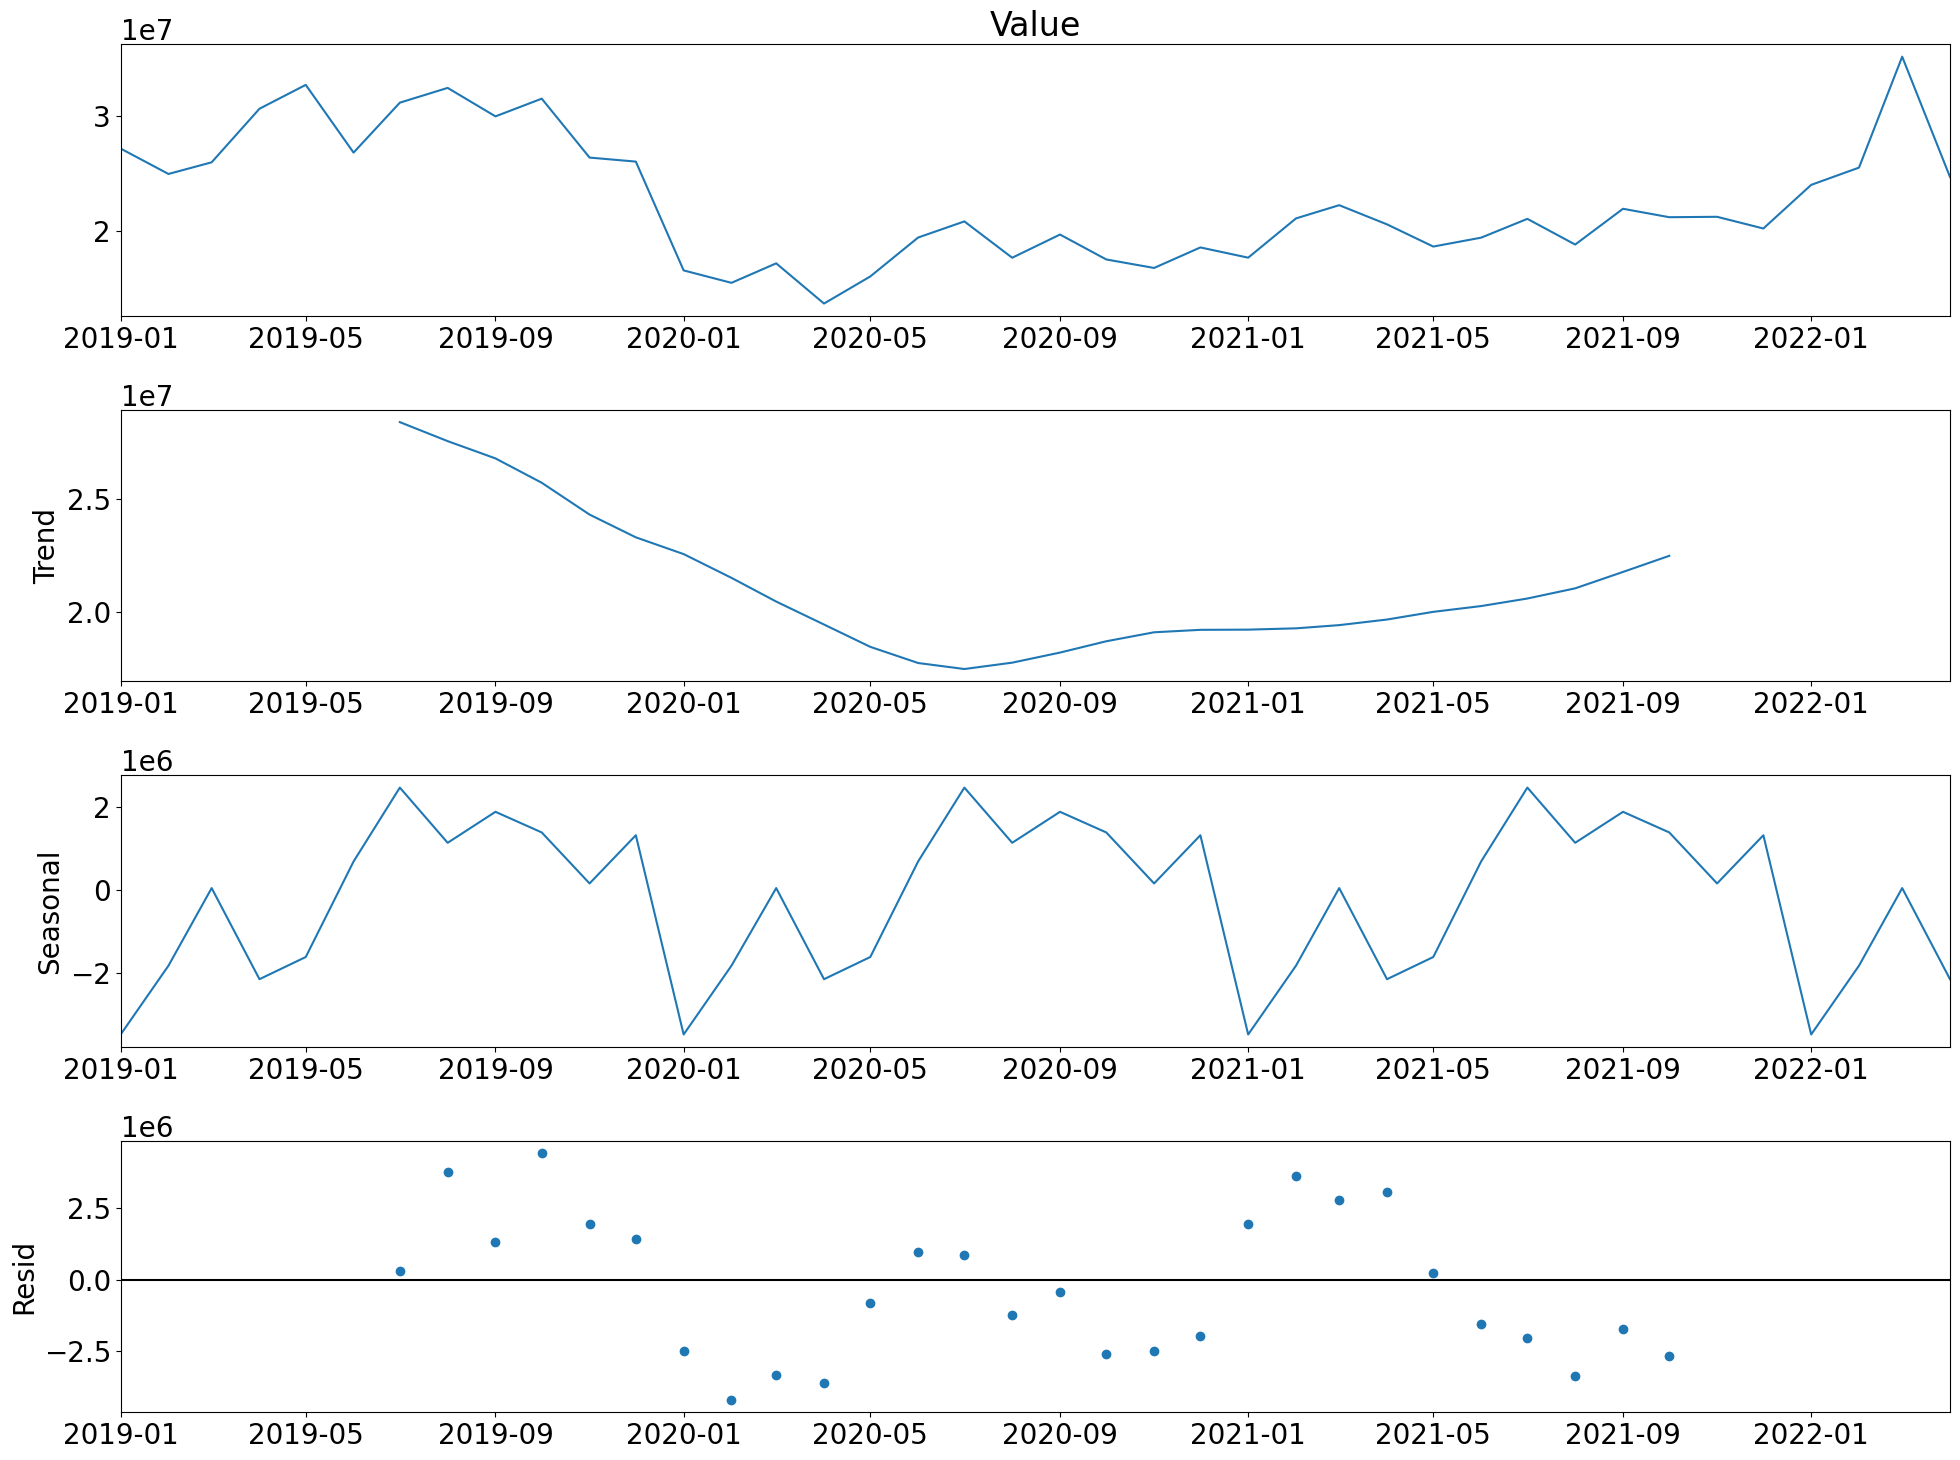

In [57]:

decomposition = seasonal_decompose(df_usa['Value'] , model = 'additive')
decomposition.plot()

plt.show()

### Check For Stationarity :-  A D-Fuller Test

In [58]:
result = sts.adfuller(df_usa['Value'])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -2.2523103517450207
n_lags: 0
p_value: 0.1878101659124256
Critical Values :
1% , -3.610399601308181
Critical Values :
5% , -2.939108945868946
Critical Values :
10% , -2.6080629651545038


**Since p_value > 0.05 We can't reject the Null Hypotheses that Data is Non-Stationary \
Therefore Data is Non-Stationary  \
Let's take the Difference of the values. \
Returns has no degree of similarity \
Since single level difference don't have any degree of similarity \
we will make two level difference**

In [59]:
df_usa['Diff_Value'] = df_usa['Value'].diff(2)
df_usa.head()

,Value,Diff_Value
Date,,
2019-01-01,27164329.0,NaN
2019-02-01,24954357.0,NaN
2019-03-01,25969580.0,-1194749.0
2019-04-01,30632226.0,5677869.0
2019-05-01,32710665.0,6741085.0


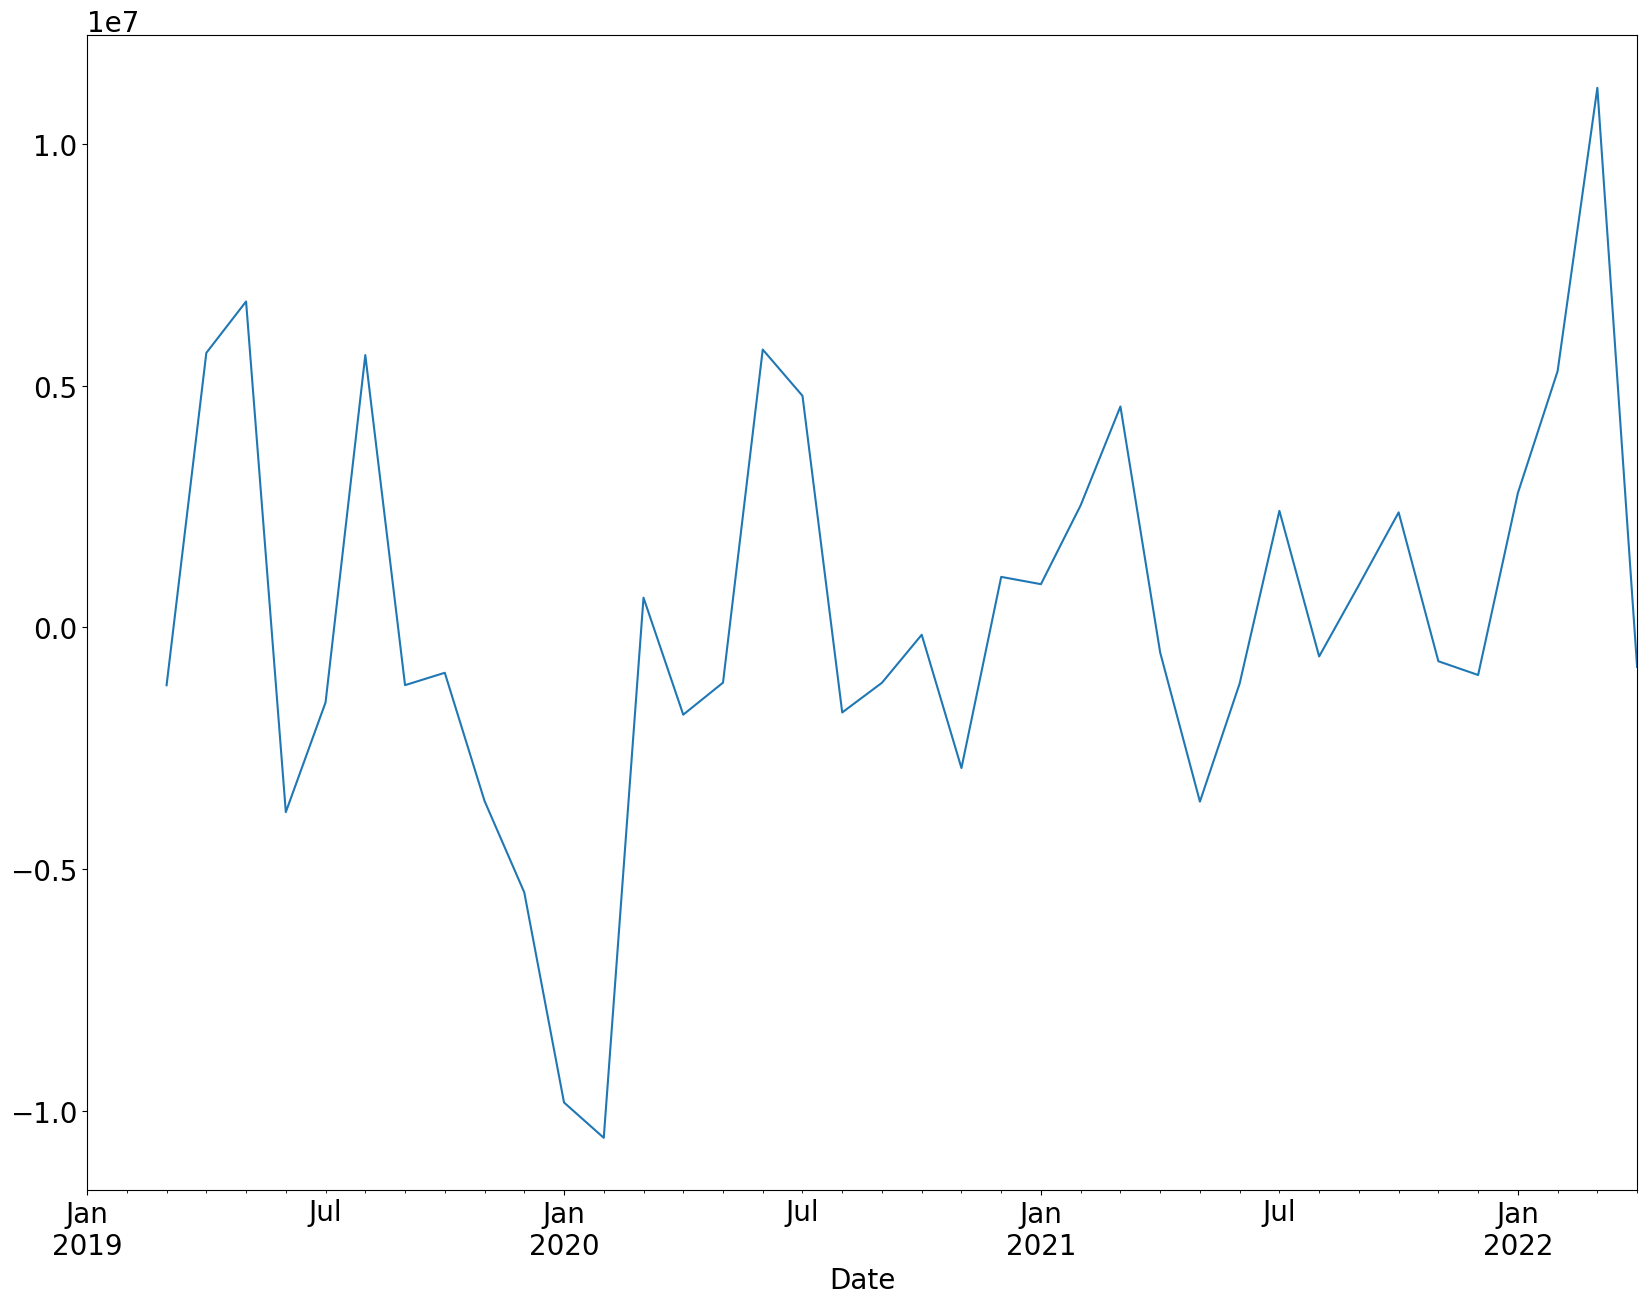

In [60]:
df_usa['Diff_Value'].plot()
plt.show()

In [61]:
result = sts.adfuller(df_usa['Diff_Value'][2:])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -3.939435181935666
n_lags: 0
p_value: 0.001763051285600992
Critical Values :
1% , -3.6209175221605827
Critical Values :
5% , -2.9435394610388332
Critical Values :
10% , -2.6104002410518627


**Since p_value < 0.05 We reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Stationary**

### Auto Correlation Function

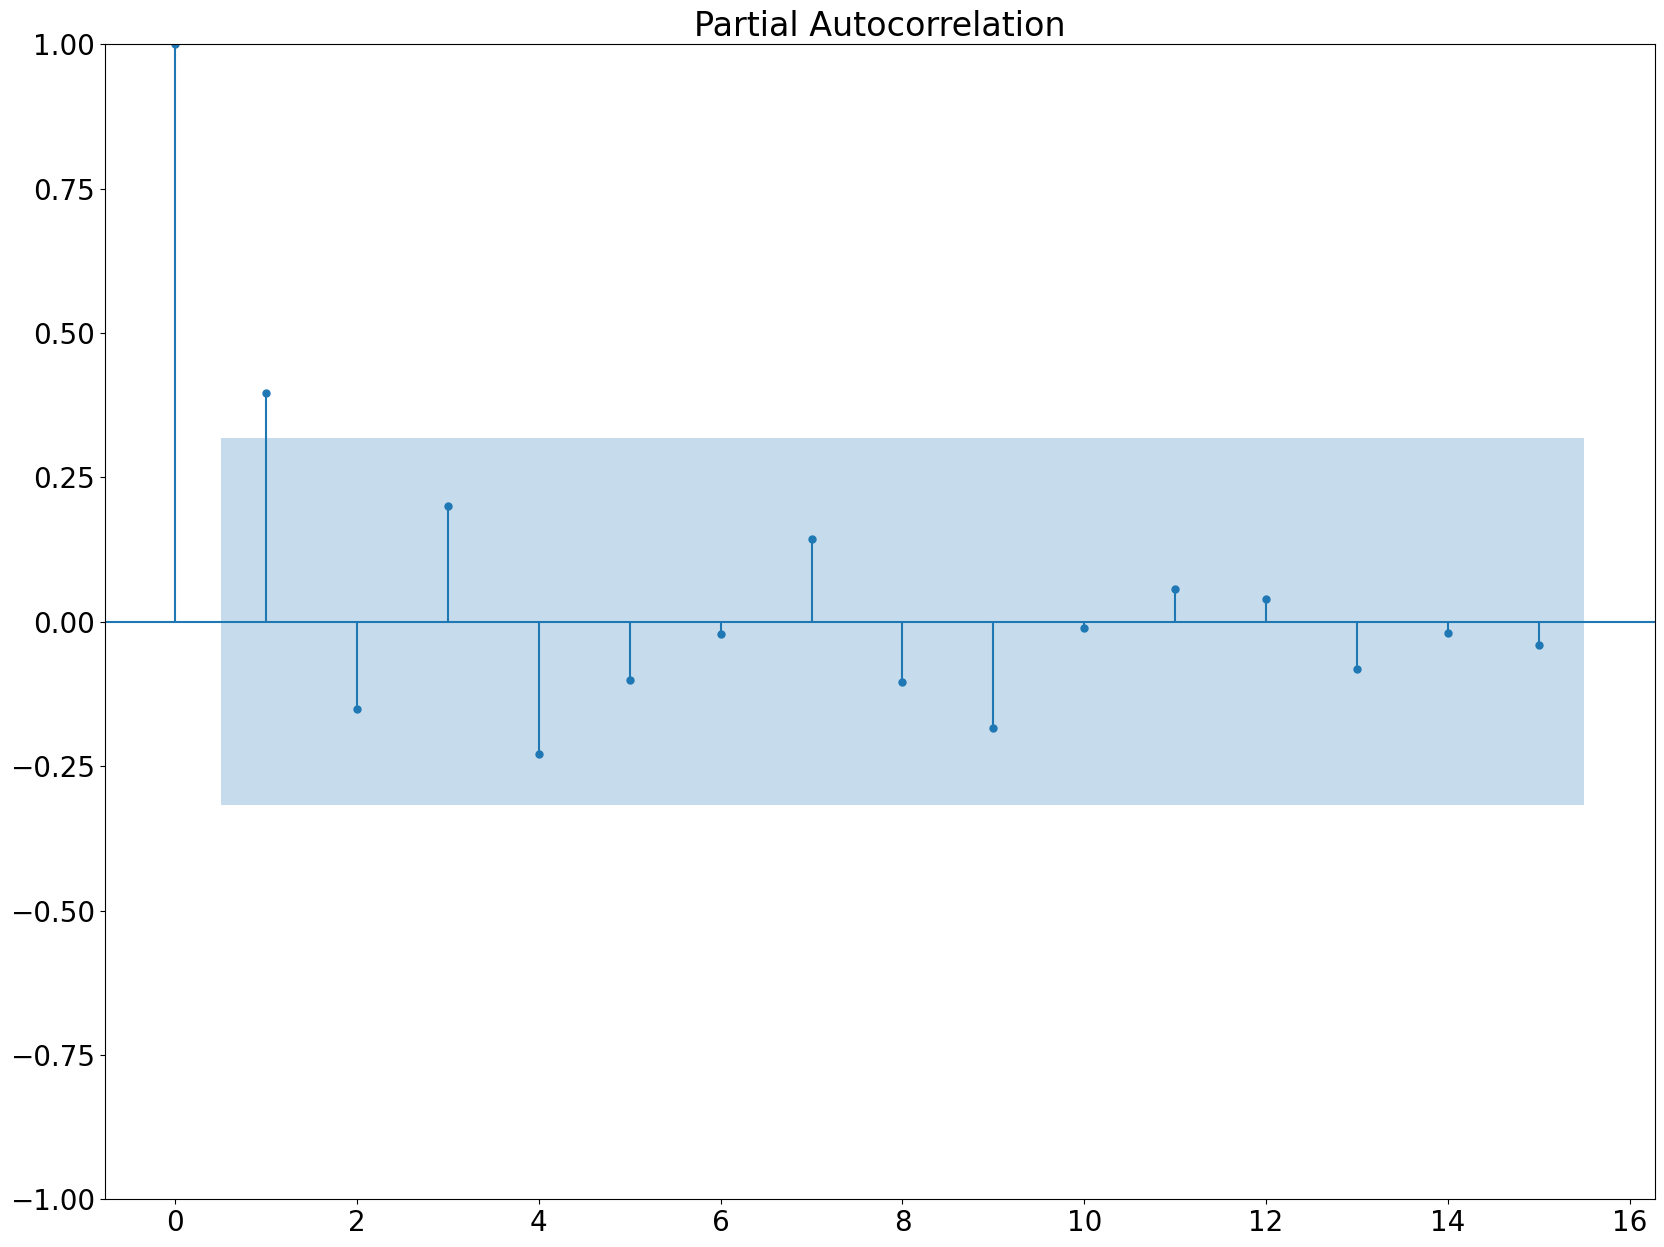

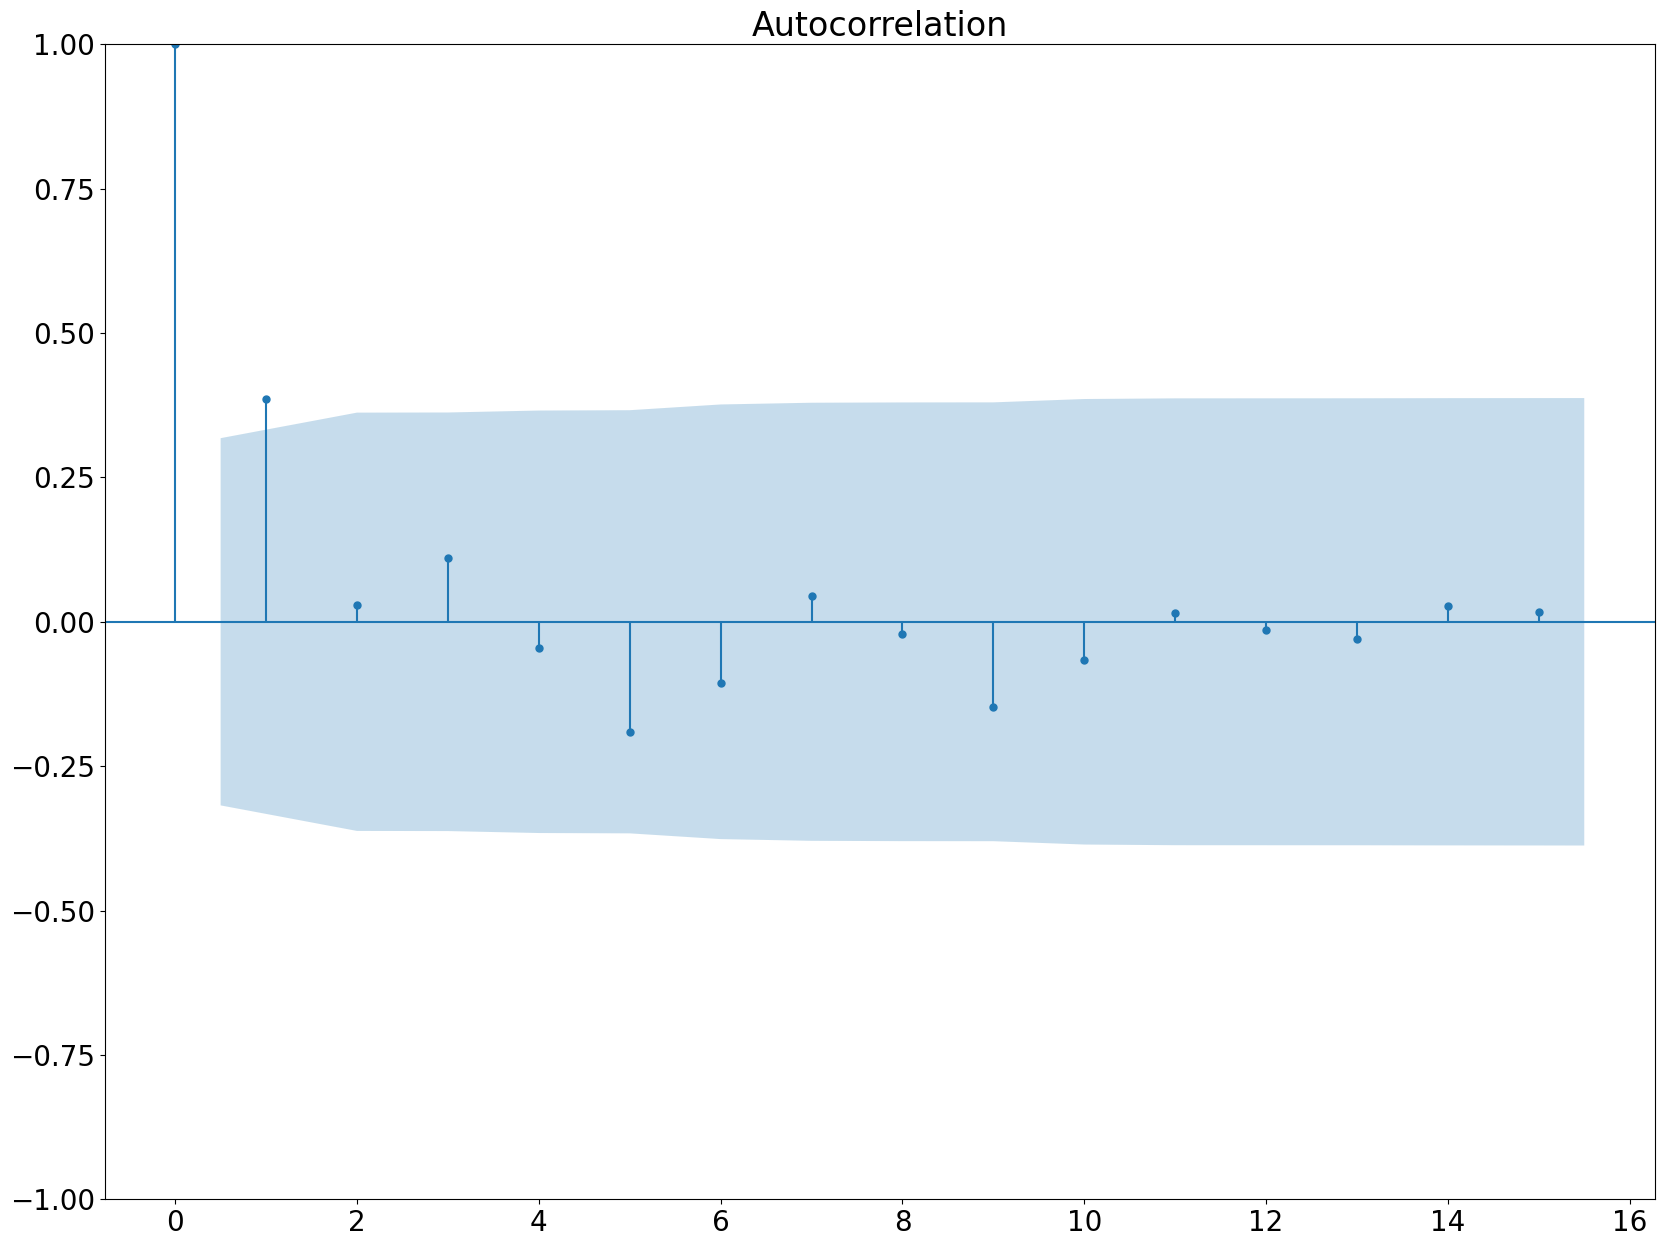

In [62]:
plot_pacf(df_usa['Diff_Value'][2:] ,  lags = 15)
plot_acf(df_usa['Diff_Value'][2:] ,  lags = 15)
plt.show()

**The possible pairs of orders for ARIMA model can be :- (1,0,0) , (0,0,1) , (1,0,1)** 

### Finding The Suitable Model

In [63]:
orders= [(1,0,0) , (0,0,1) , (1,0,1)]

for order in orders:
    ar,ma = order[0] , order[-1]
    arima = ARIMA(df_usa['Diff_Value'][2:] , order = (ar,0,ma))
    results = arima.fit()
    print(f'ARIMA{order} has LLF = {results.llf} and AIC = {results.aic}')

ARIMA(1, 0, 0) has LLF = -630.4951395027682 and AIC = 1266.9902790055364
ARIMA(0, 0, 1) has LLF = -628.6004715339824 and AIC = 1263.2009430679648
ARIMA(1, 0, 1) has LLF = -627.9866982944458 and AIC = 1263.9733965888915


**Let's choose ARIMA(1,0,1)**

In [68]:
arima_usa = ARIMA(df_usa['Diff_Value'][2:] , order = (1,0,1))
results_usa = arima_usa.fit()

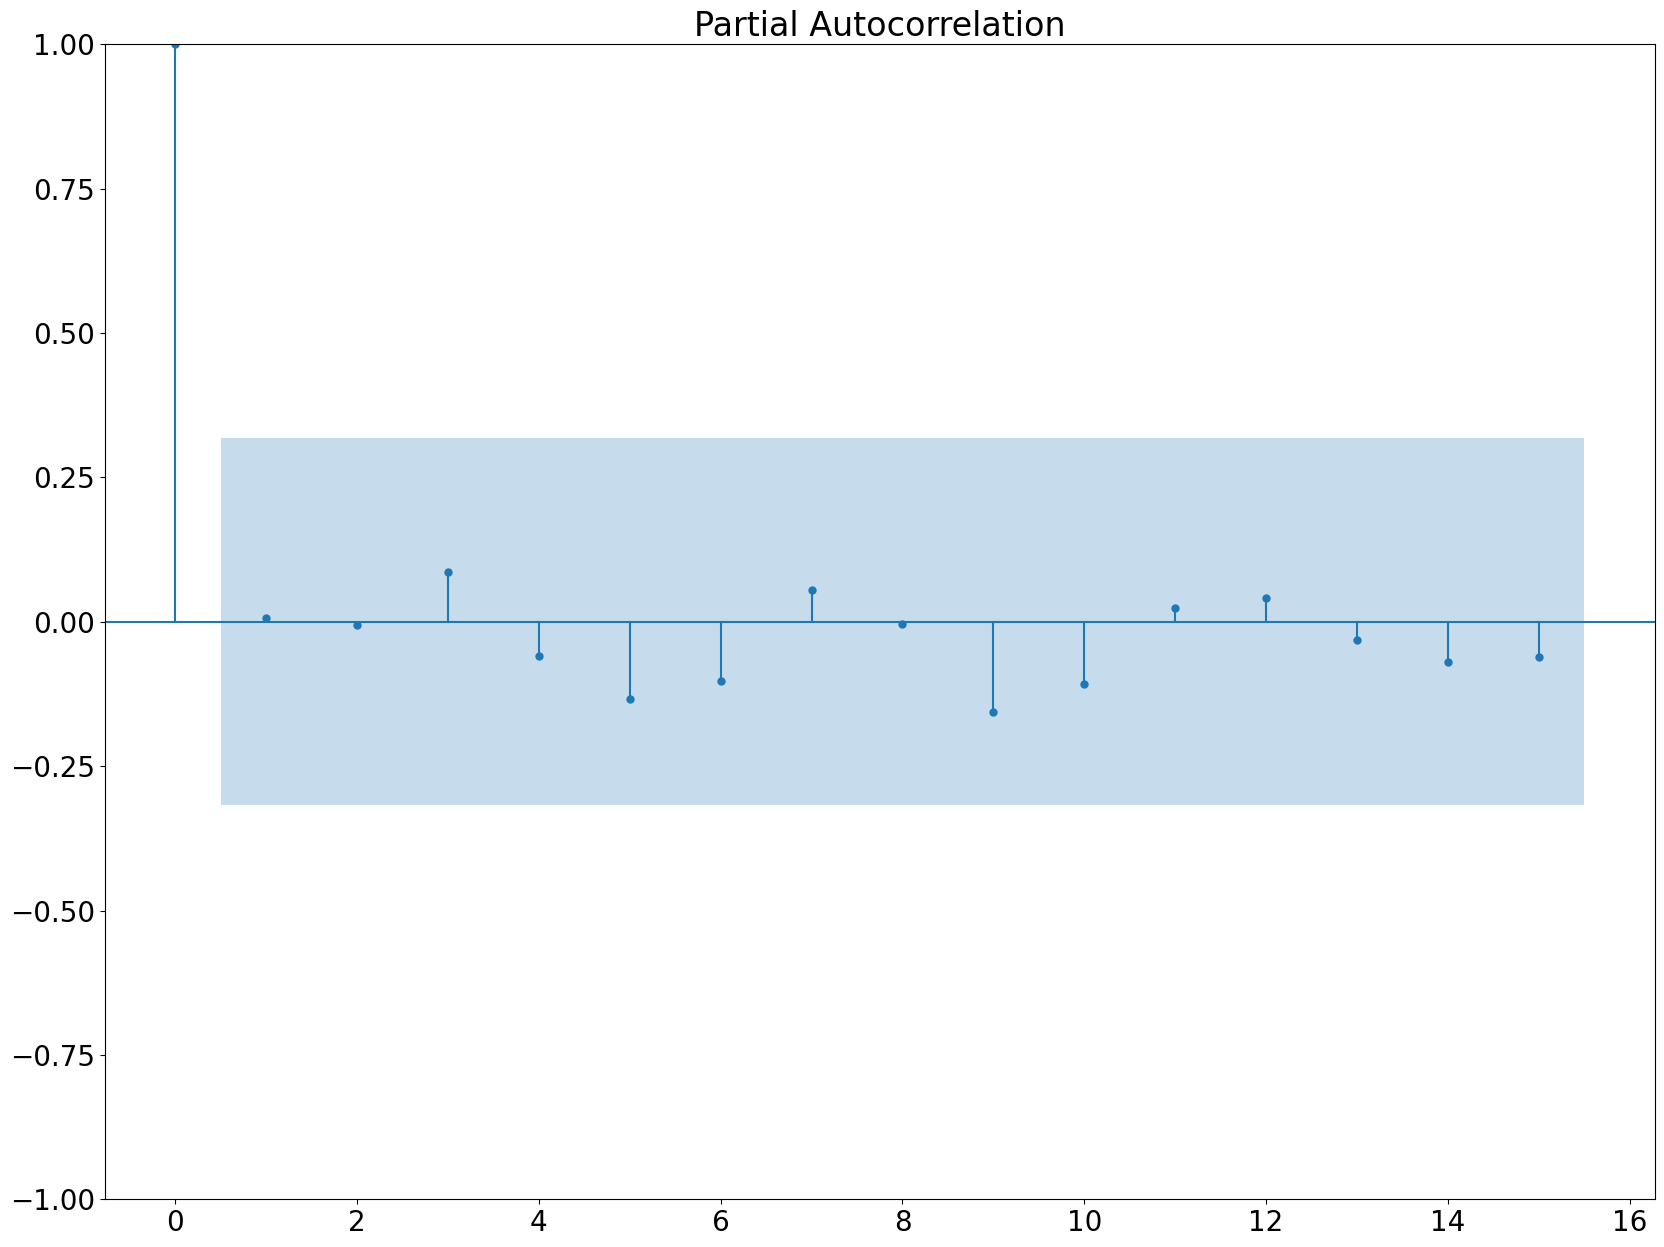

In [69]:
plot_pacf(results_usa.resid , lags = 15)
plt.show()

#we can proceed since there are no lags

### Forecasting Future Values

In [70]:
# Lets forecast for next 15 months
differences = results_usa.forecast(steps = 15).values.tolist()

# Store the data values for calculating values from forecast values
values = df_usa['Value'].values.tolist()
len(values)

40

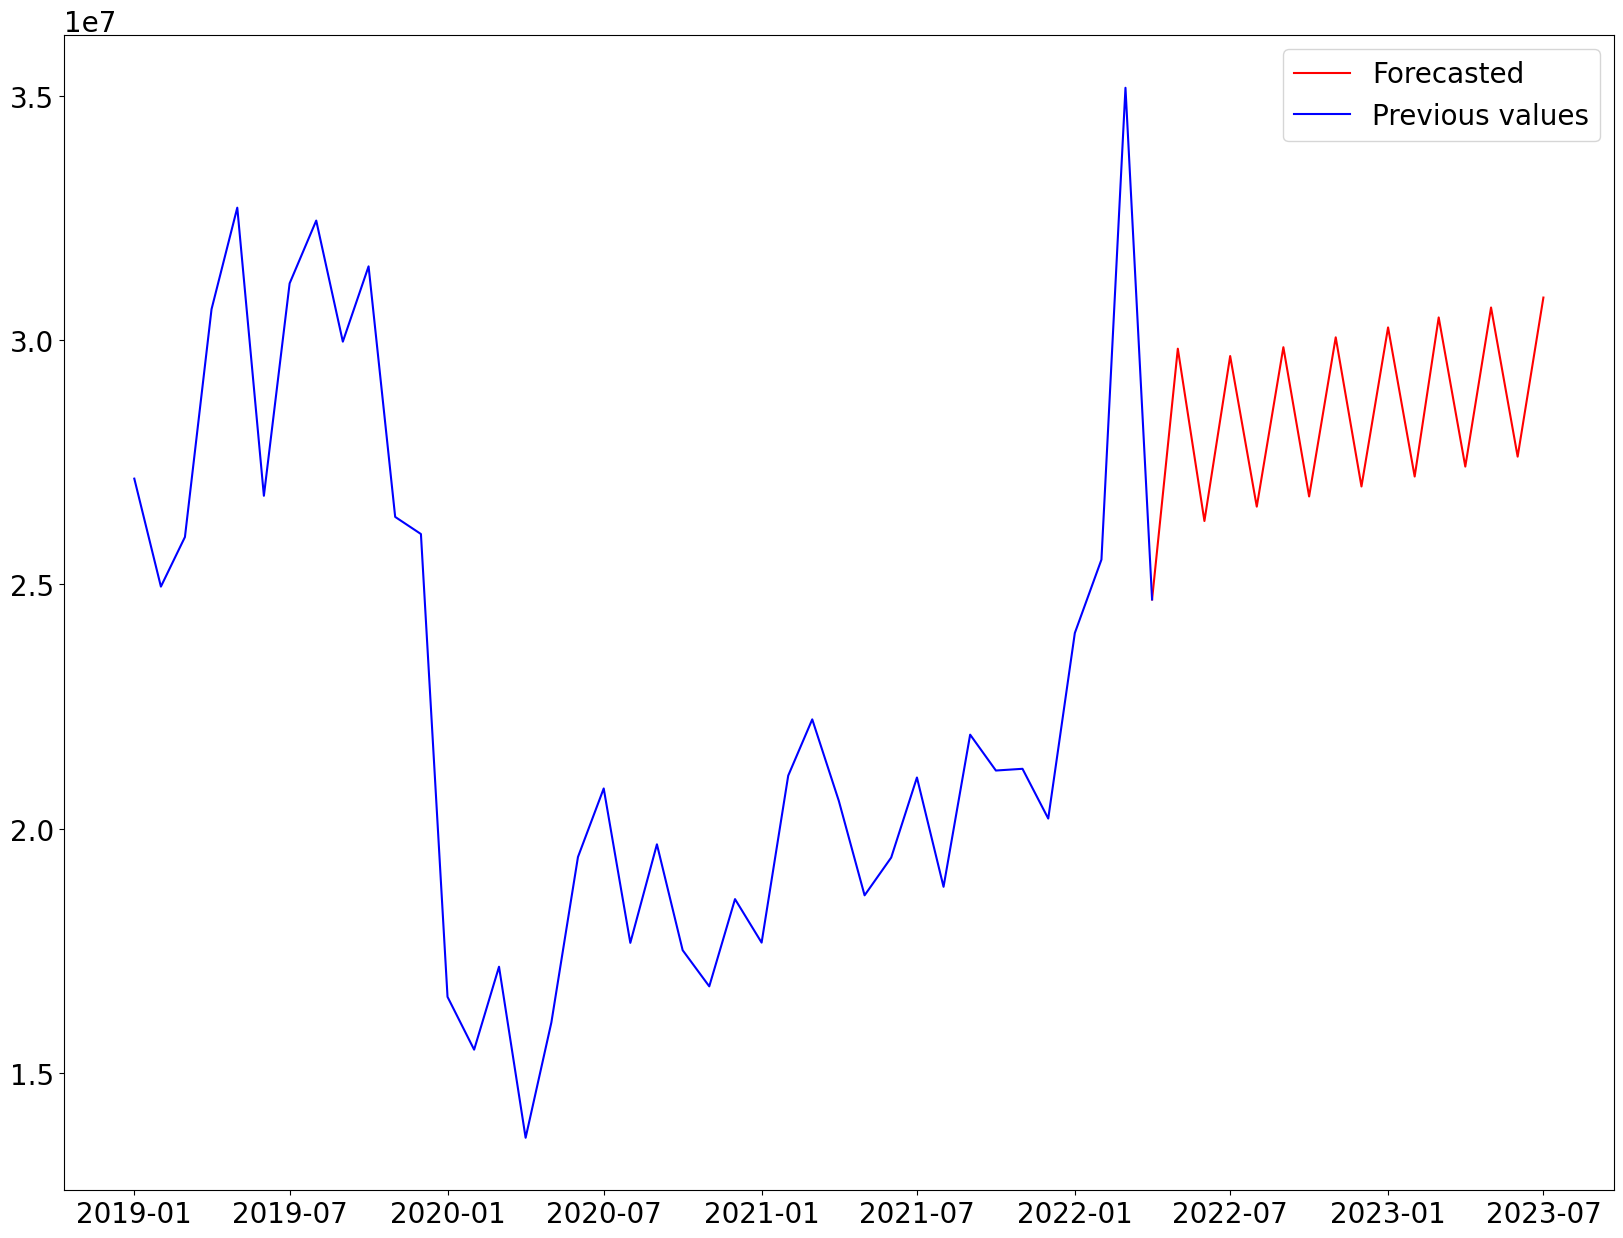

In [71]:
for diff in differences:
    val = diff + values[-2]
    values.append(round(val))
    
plt.plot(pd.DataFrame({'Date':dates , 'Value':values[39:]}).set_index('Date'), label = 'Forecasted' , color = 'red')
plt.plot(df_usa[['Value']] , label = 'Previous values' ,color = 'blue')
plt.legend()
plt.show()

In [72]:
# forecast_df['USA'] = values[40:]

In [67]:
# joblib.dump(results_usa , 'Model_USA.pkl')

# Italy Country Analysis

### Data Preparation

In [68]:
df_italy=data[data.Country == 'Italy'].drop('Country',axis = 1).set_index('Date').astype(int)
df_italy.head()

,Value
Date,
2019-01-01,3405980
2019-02-01,6455786
2019-03-01,4865427
2019-04-01,1503275
2019-05-01,2867990


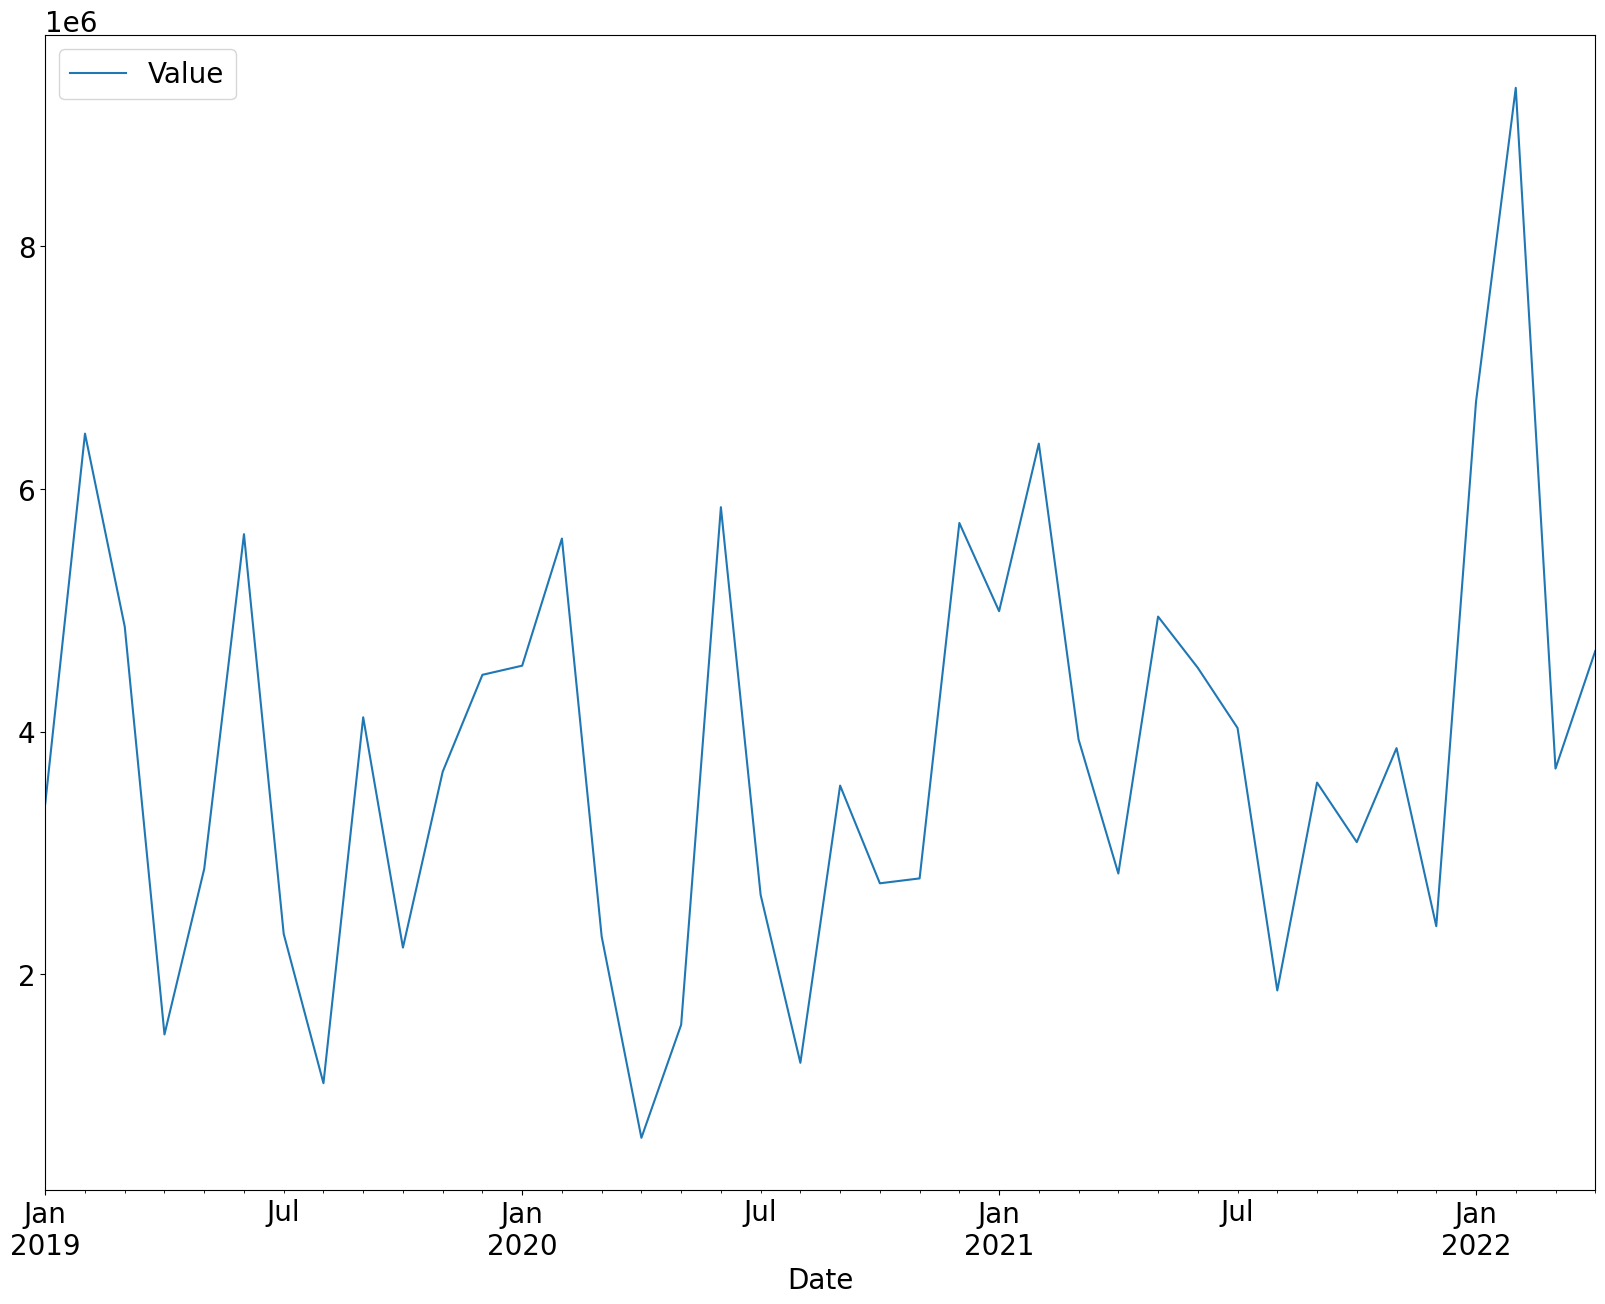

In [69]:
df_italy.plot()
plt.show()

<AxesSubplot:>

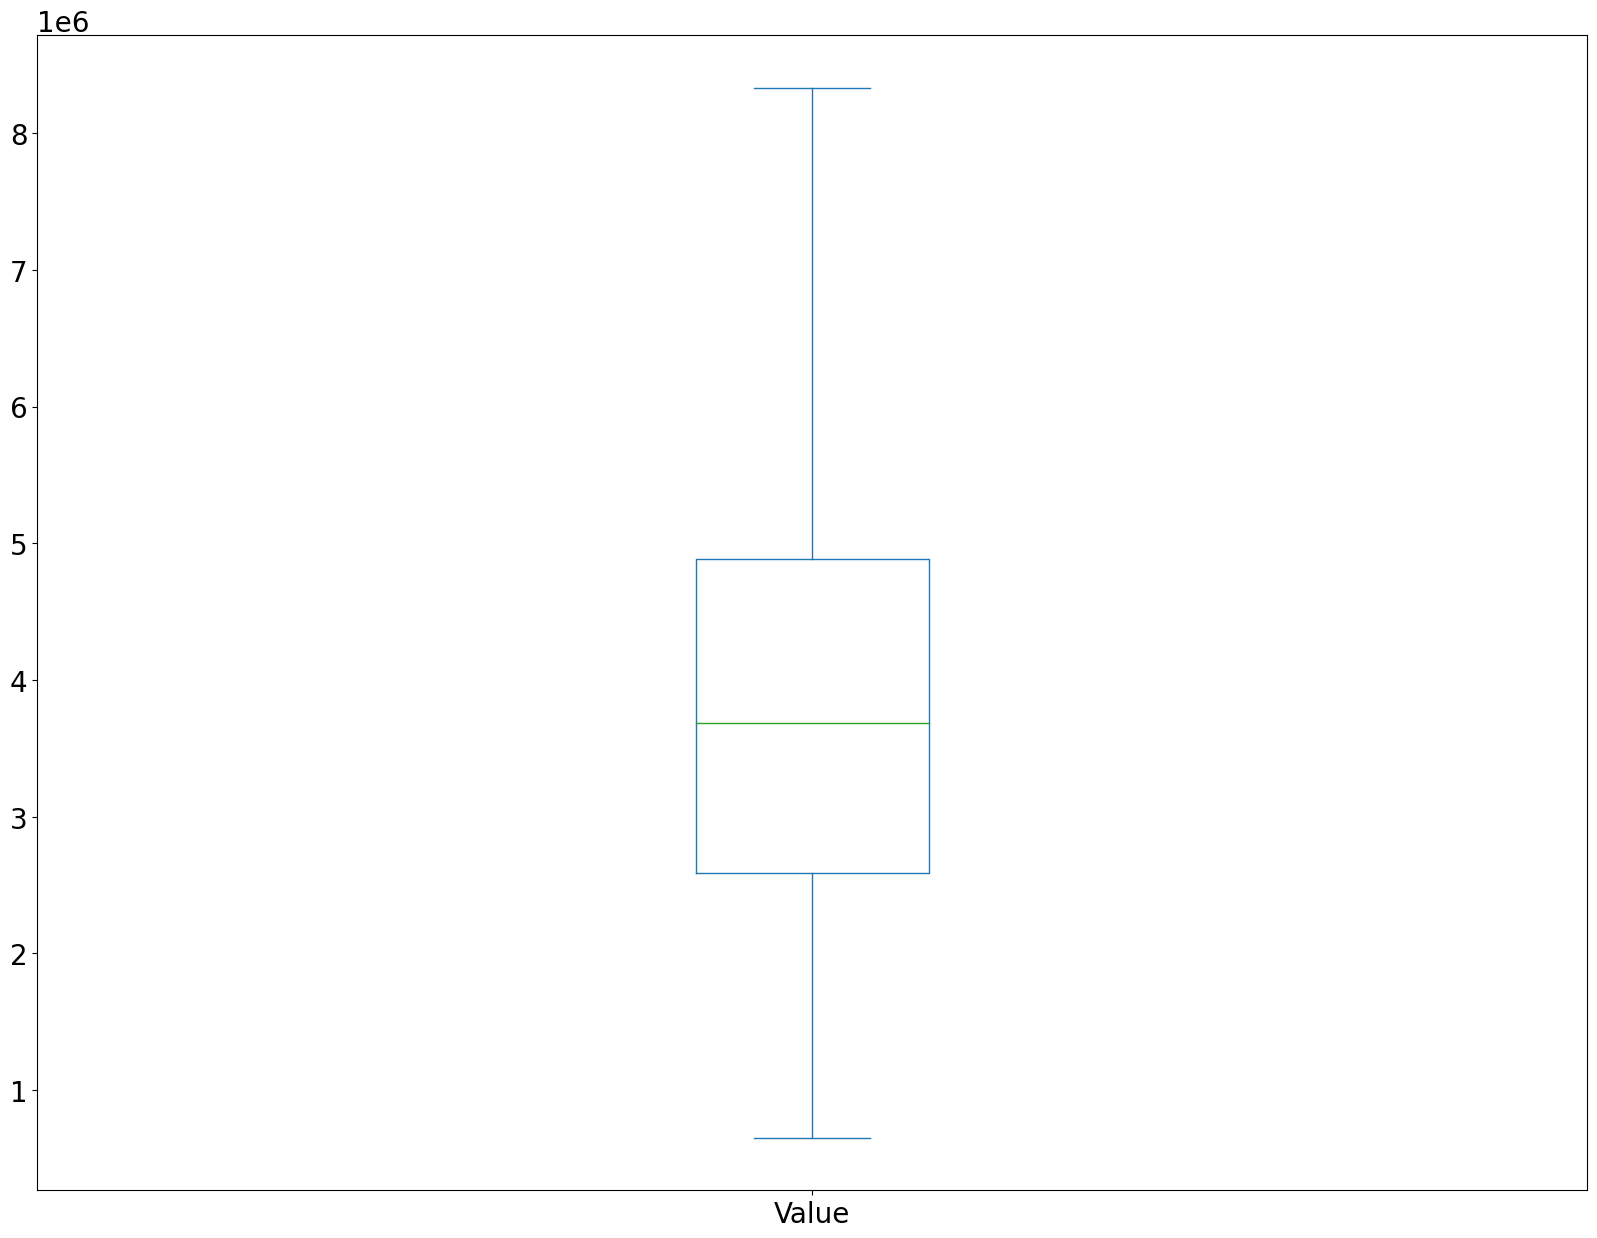

In [70]:
# Bounding the outlier

IQR(df_italy ,  'Value')
df_italy['Value'].plot(kind = 'box')

### Seasonal Decomposition Of Data

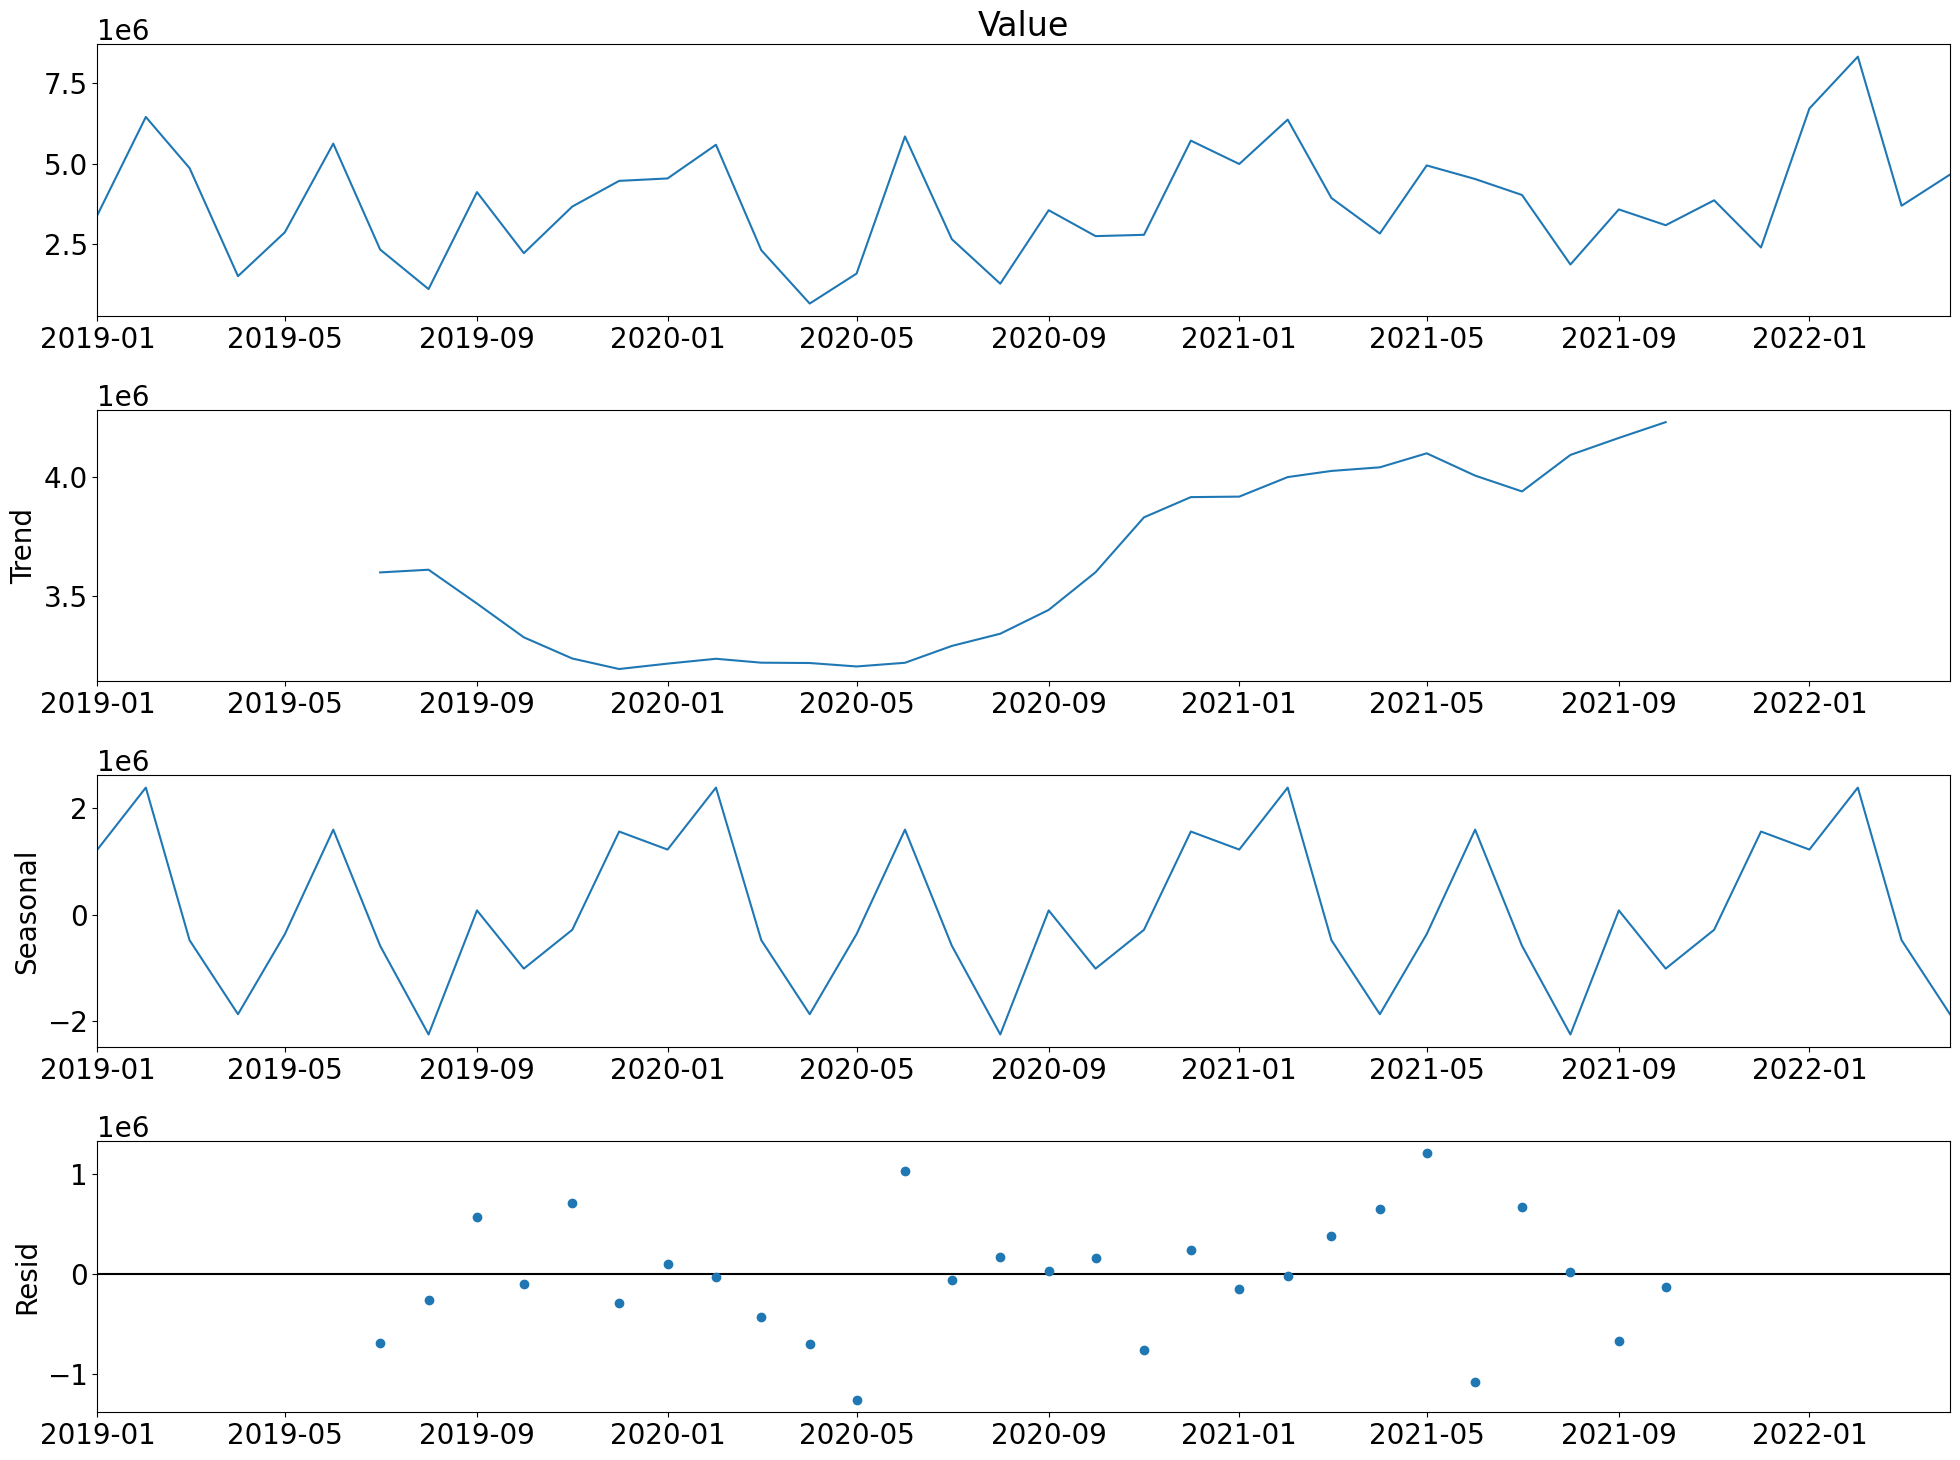

In [71]:
decomposition = seasonal_decompose(df_italy['Value'] , model = 'additive')
decomposition.plot()

plt.show()

### Check For Stationarity :-  A D-Fuller Test

In [72]:
result = sts.adfuller(df_italy['Value'])
print(f'ADF Statistic : {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p_value: {result[1]}')

for key , value in result[4].items():
    print('Critical Values :')
    print(f'{key} , {value}')    

ADF Statistic : -5.058461309851519
n_lags: 0
p_value: 1.6981338798126417e-05
Critical Values :
1% , -3.610399601308181
Critical Values :
5% , -2.939108945868946
Critical Values :
10% , -2.6080629651545038


**Since p_value < 0.05 We reject the Null Hypotheses that Data is Non-Stationary** \
**Therefore Data is Stationary**

### Auto Correlation Function

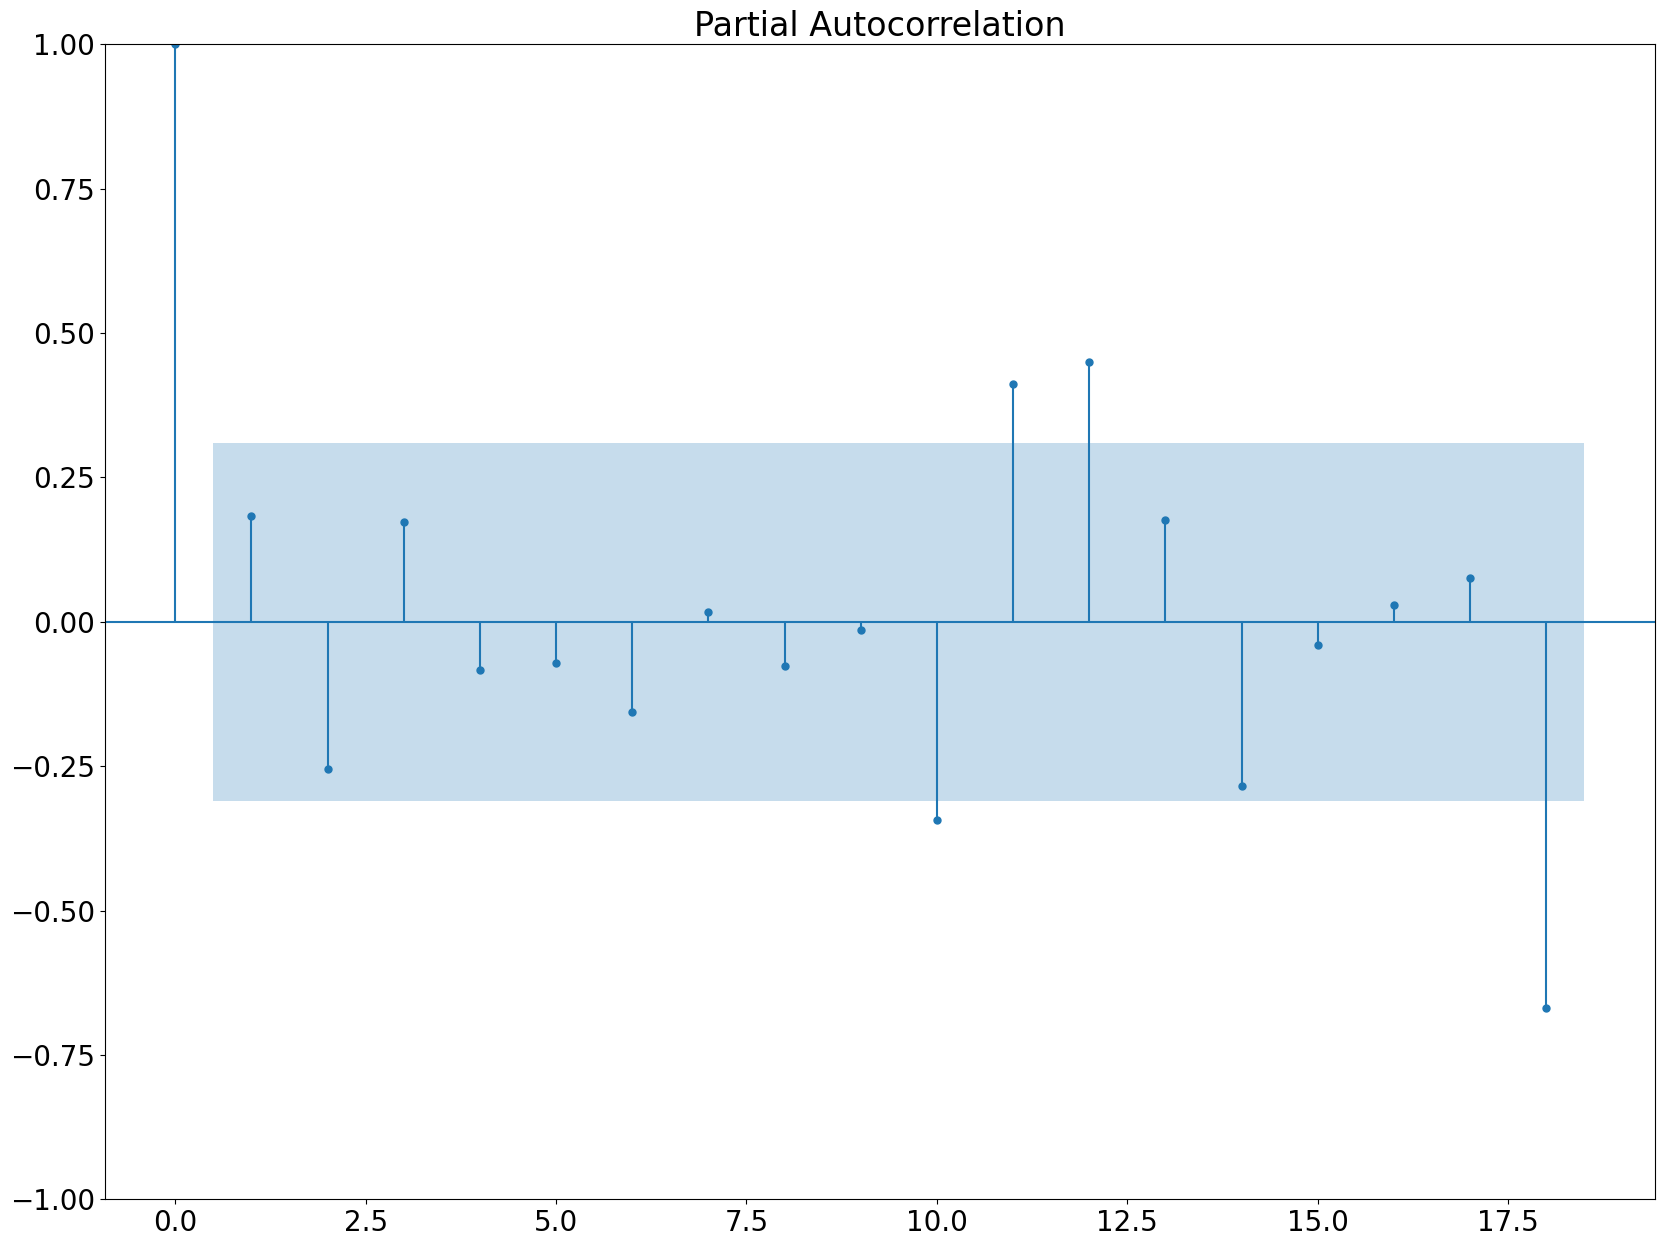

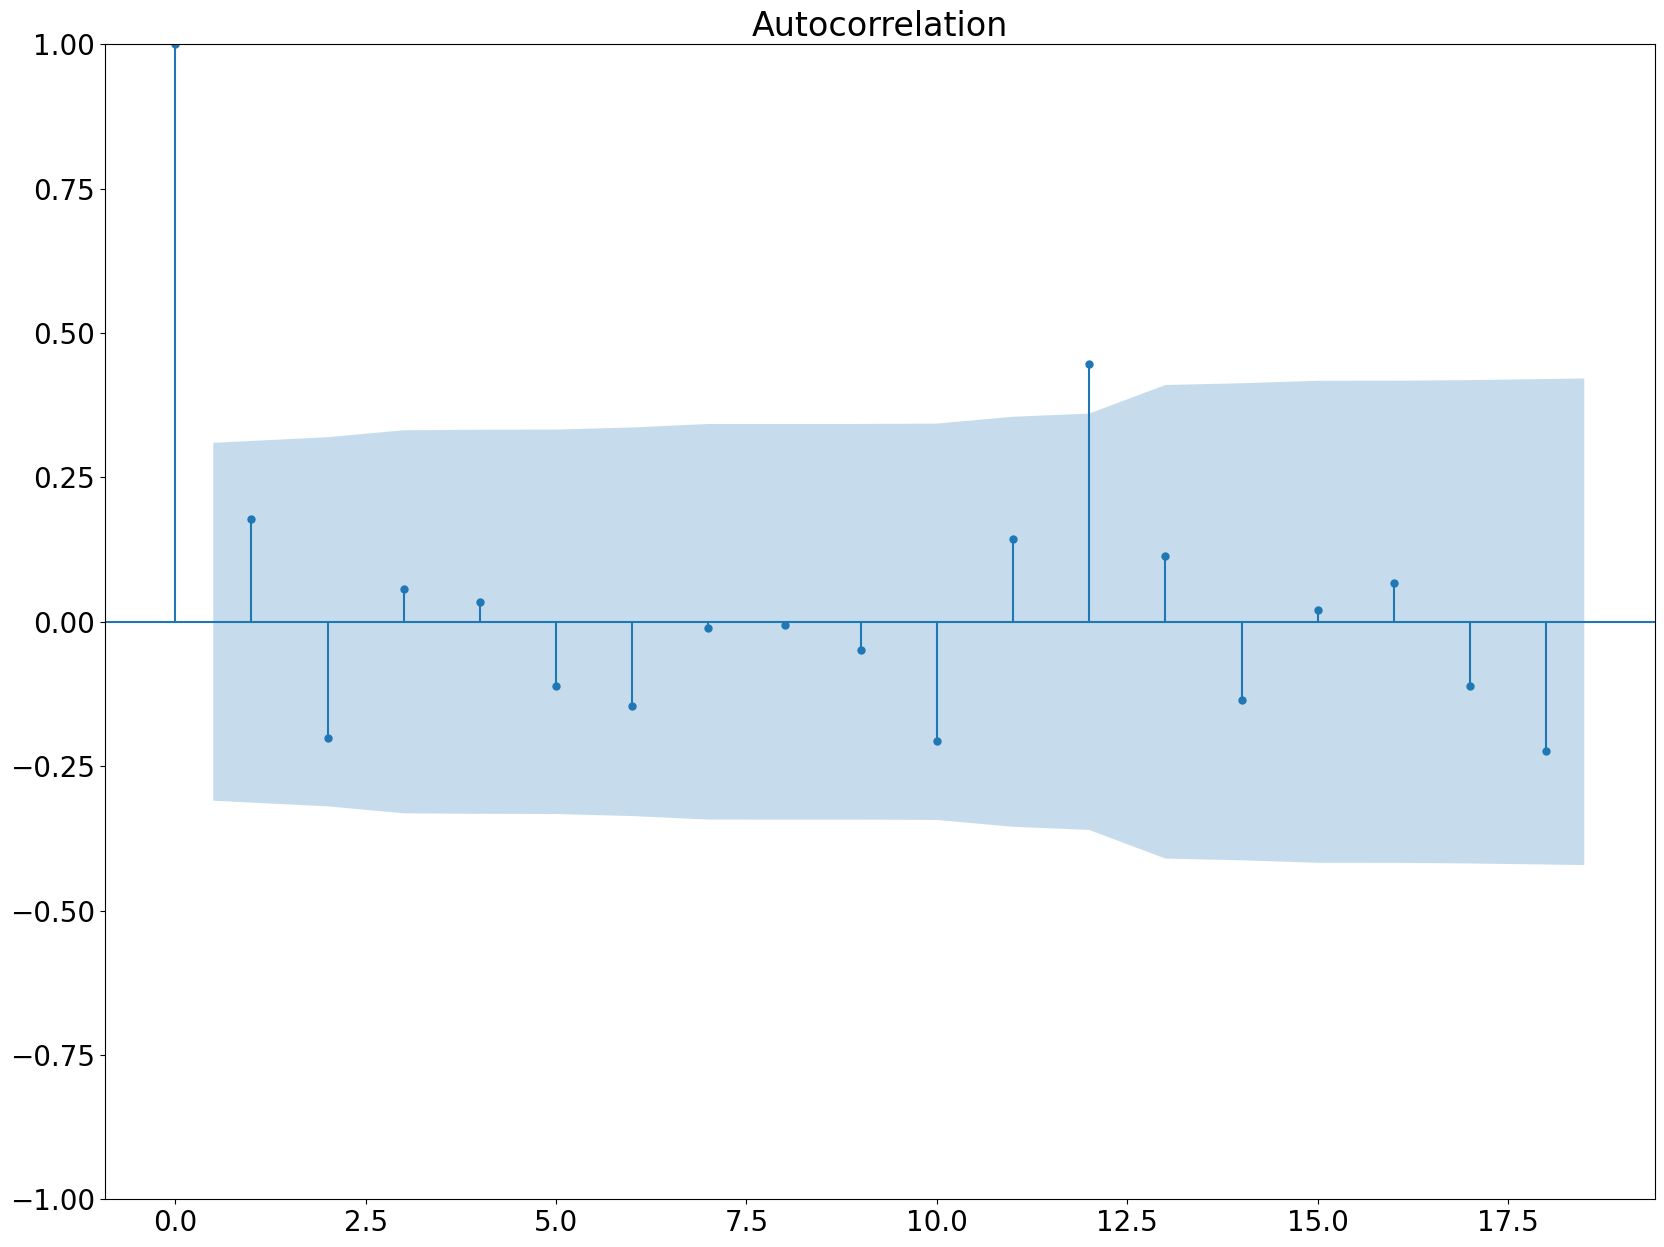

In [73]:
plot_pacf(df_italy['Value'] , lags = 18)
plot_acf(df_italy['Value'] , lags = 18)
plt.show()

**We can see that there is possible degree of similarity but it didn't gave better result.....Lets get the Difference values \
Return didn't give the better results**

### Differencing and Plotting ACF

In [74]:
# Returns won't give better results

In [75]:
df_italy['Diff_Value'] = df_italy['Value'].diff()[1:]
df_italy.head()

,Value,Diff_Value
Date,,
2019-01-01,3405980.0,NaN
2019-02-01,6455786.0,3049806.0
2019-03-01,4865427.0,-1590359.0
2019-04-01,1503275.0,-3362152.0
2019-05-01,2867990.0,1364715.0


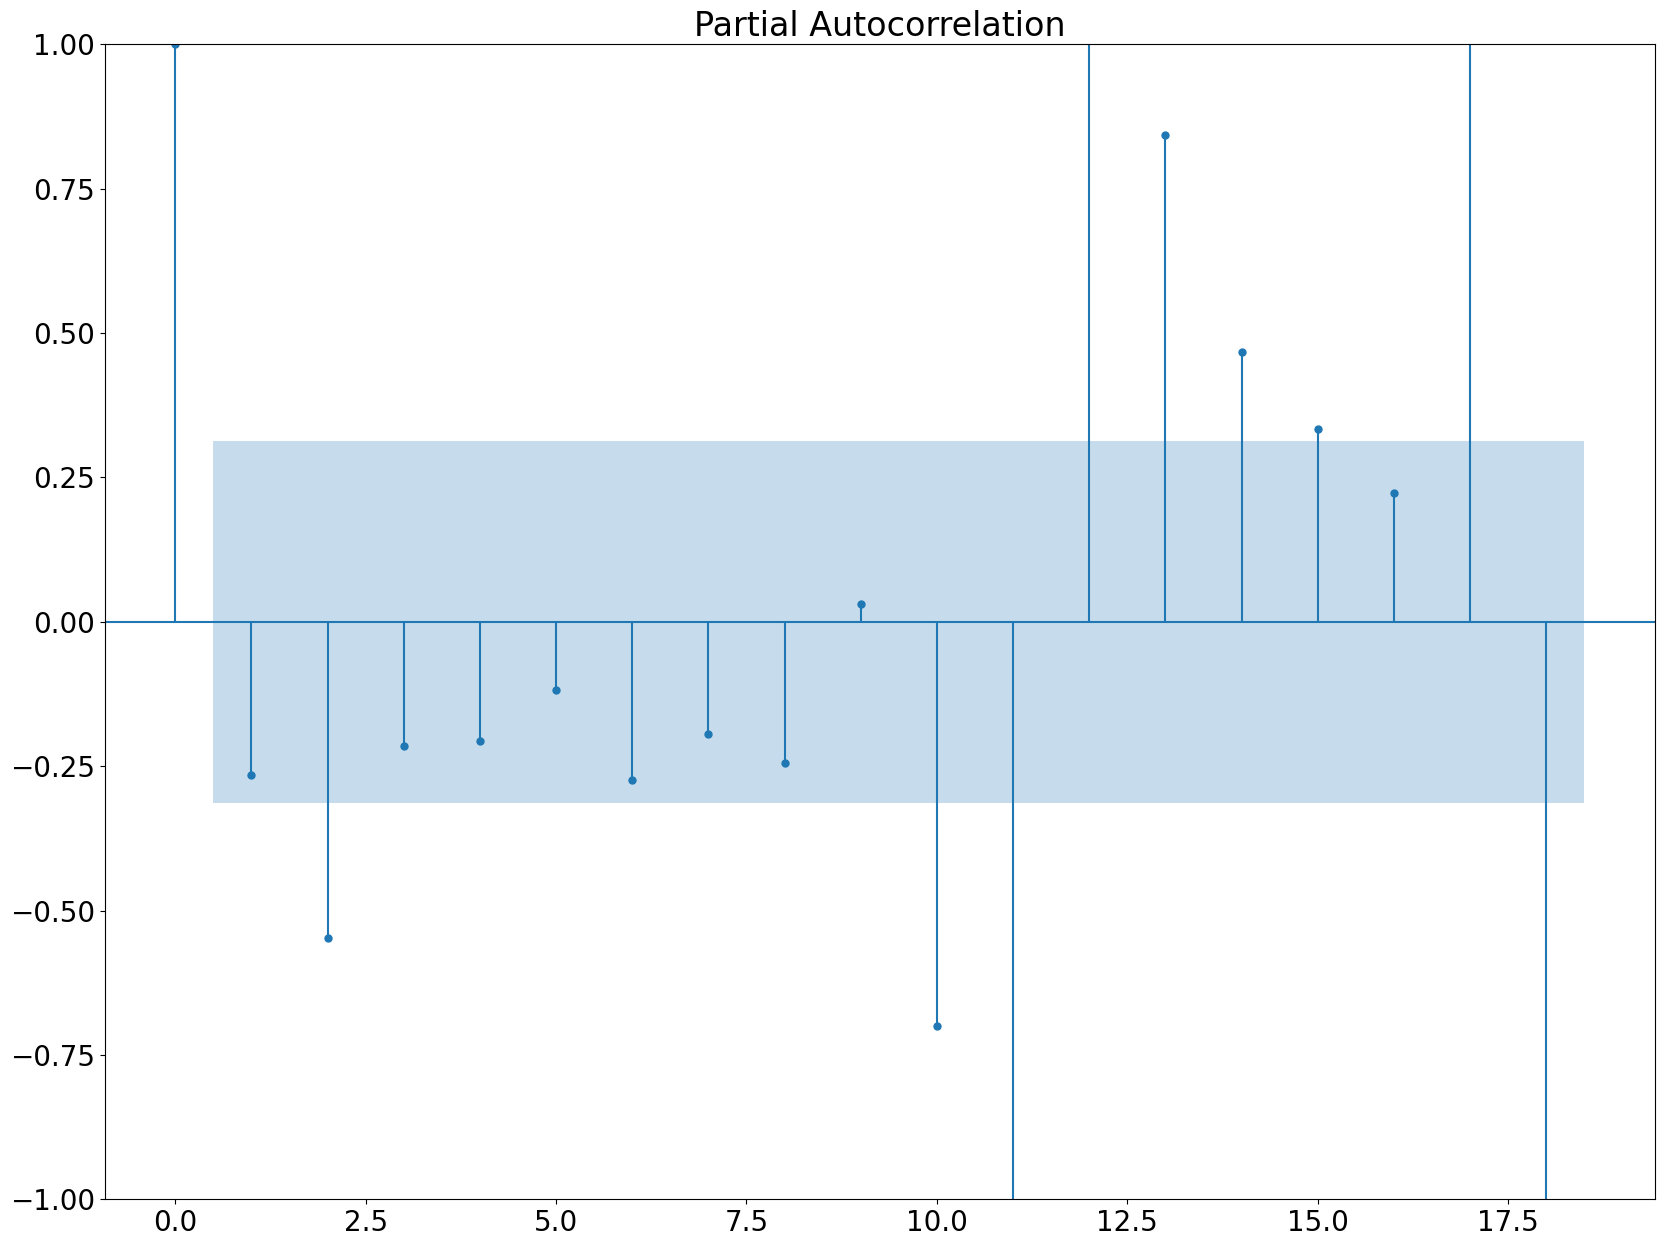

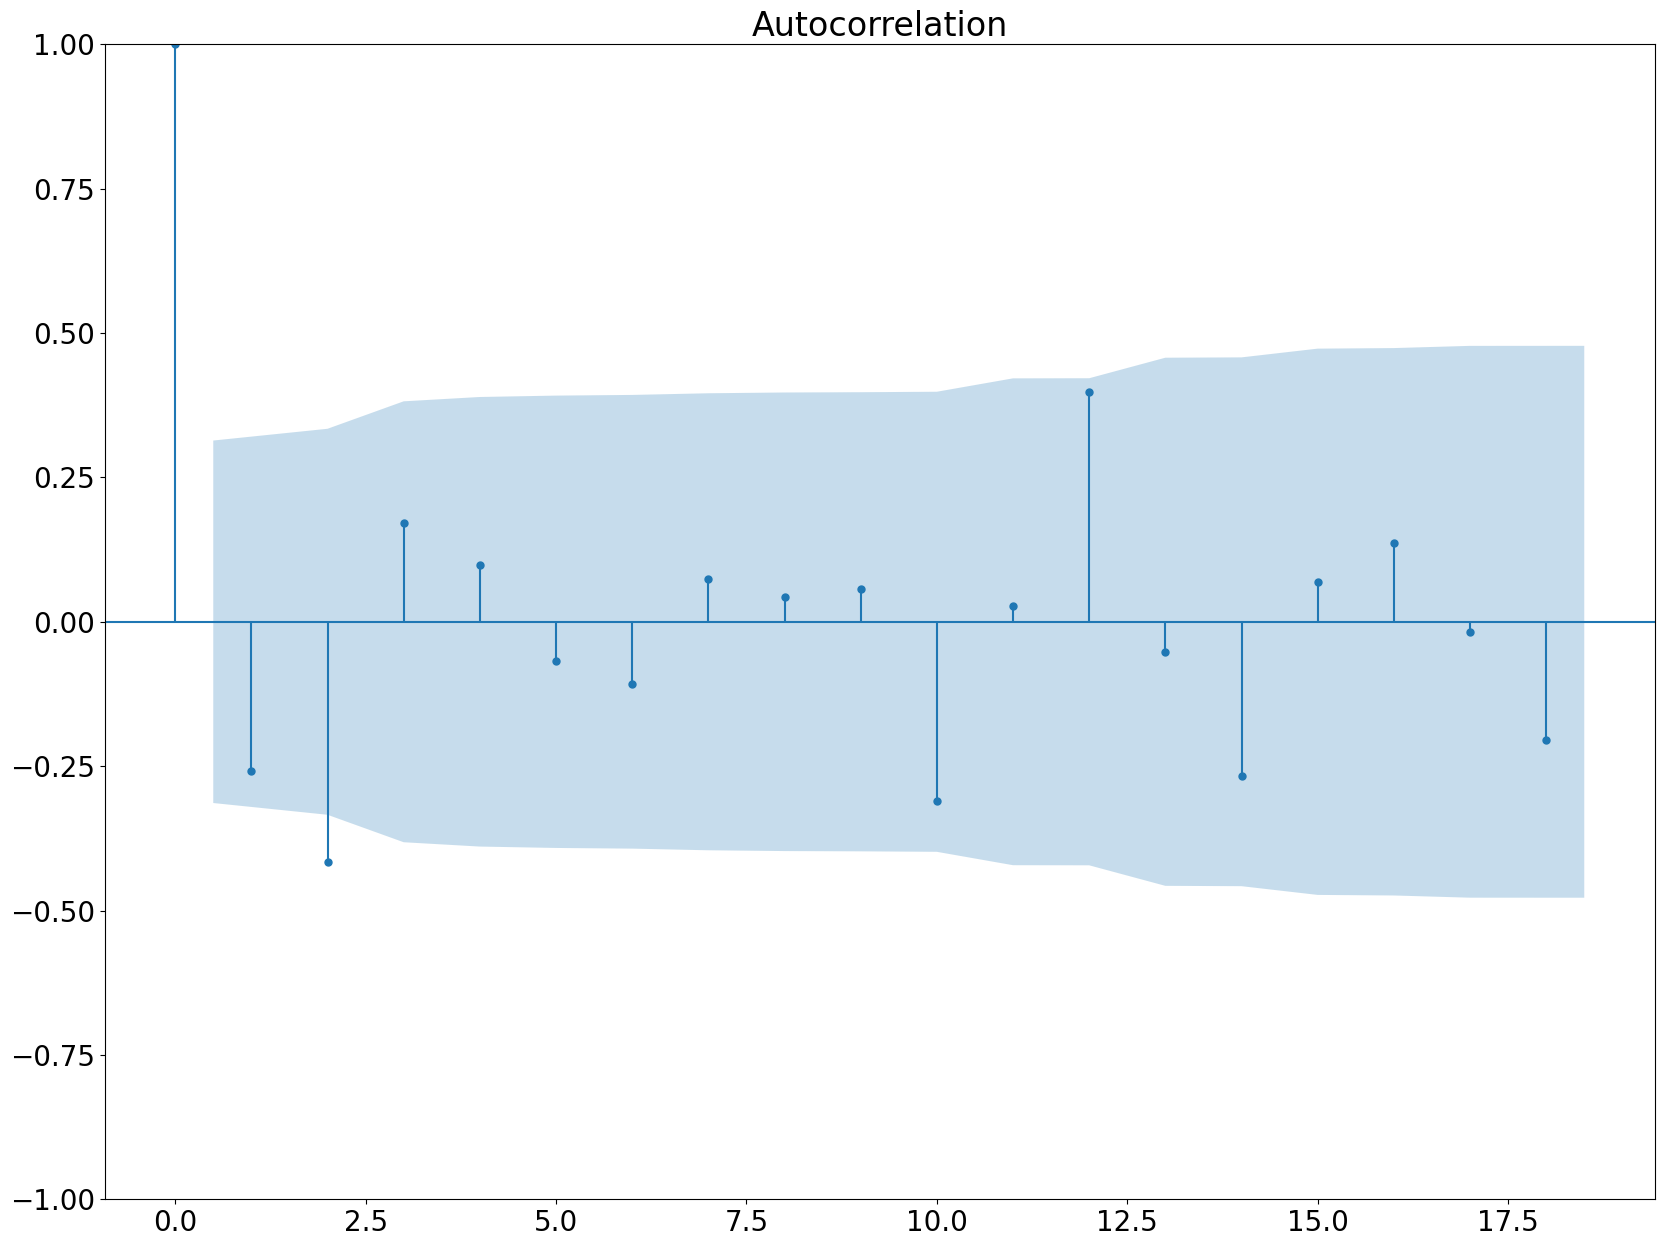

In [76]:
plot_pacf(df_italy['Diff_Value'][1:] , lags = 18)
plot_acf(df_italy['Diff_Value'][1:] , lags = 18)
plt.show()

**By see the pacf and acf plots we can have 3 pairs of orders for ARIMA model :- \
 (2,0,0) , (2,0,2) , (0,0,2) , (10,0,0) , (11,0,0) , (12,0,0) ,(12,0,2) , (10,0,2) , (11,0,2)**

#### Finding Seasonal Order

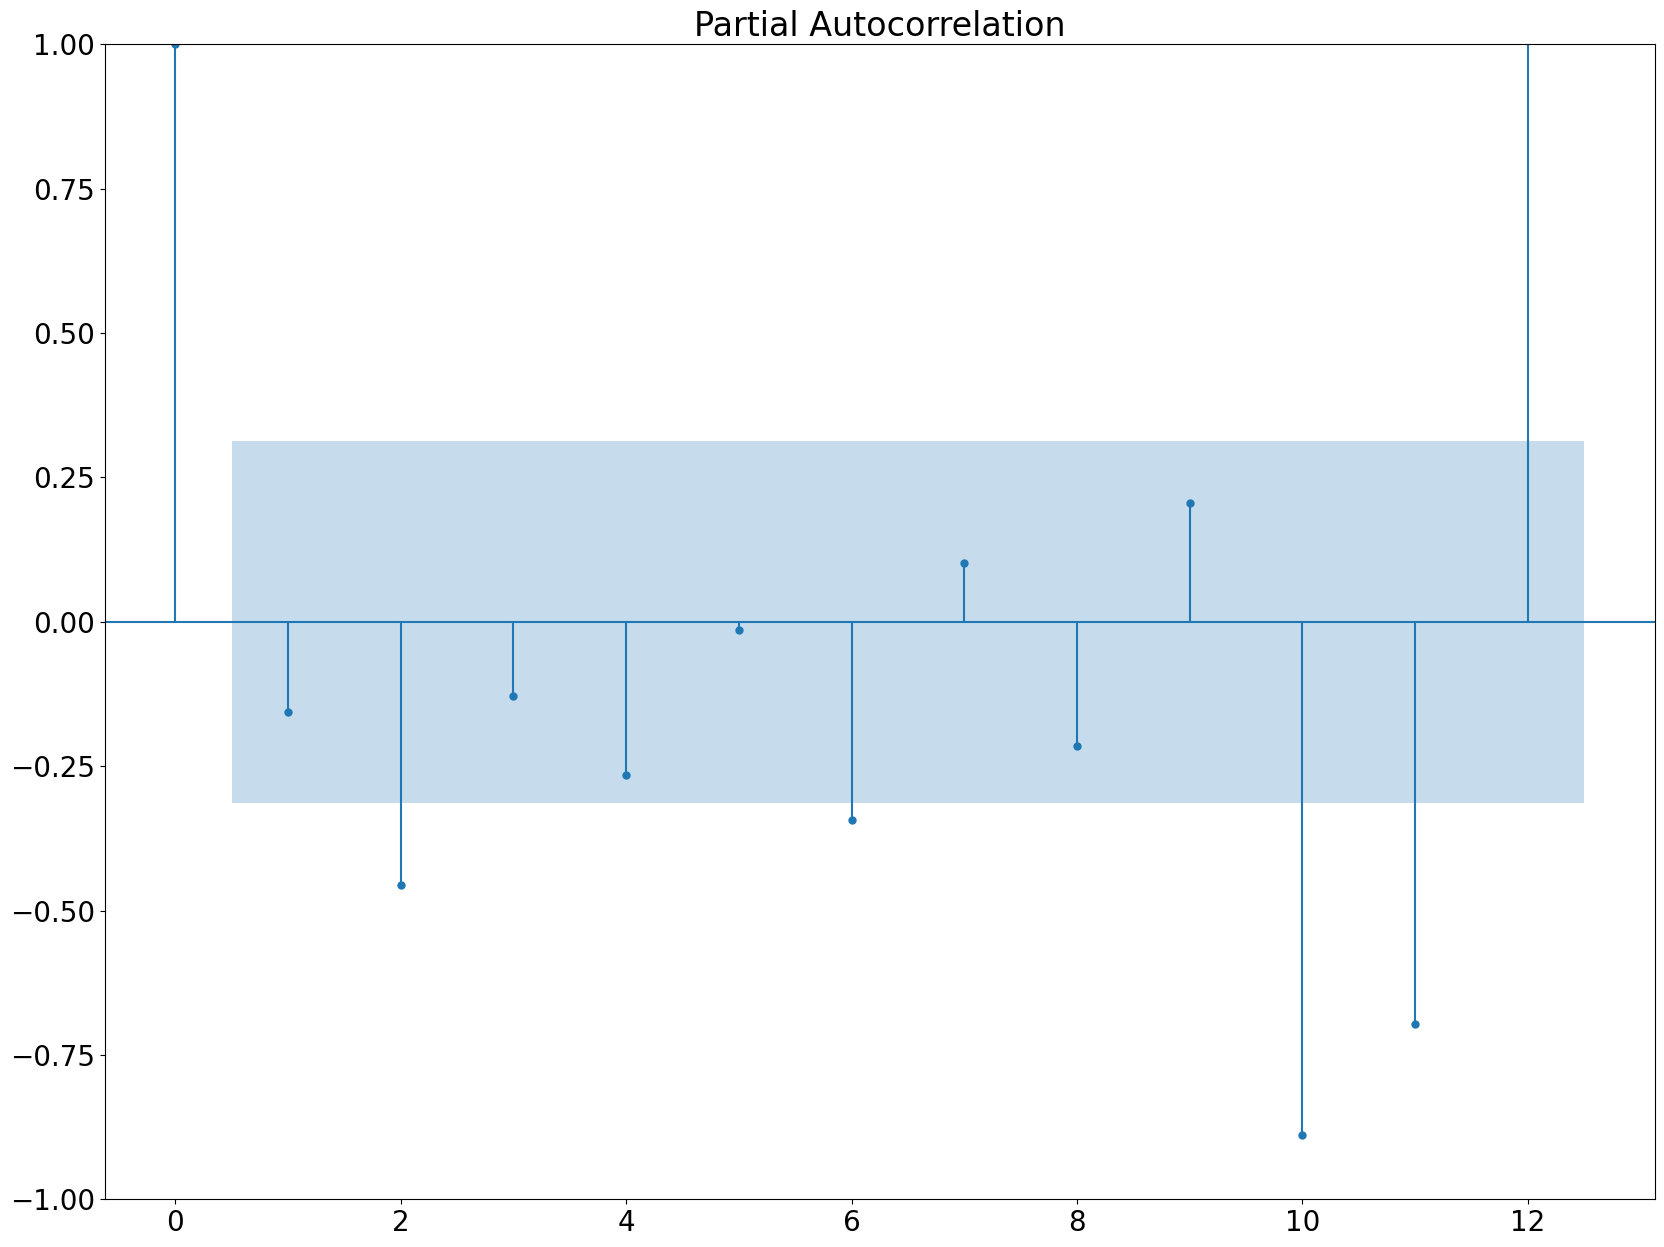

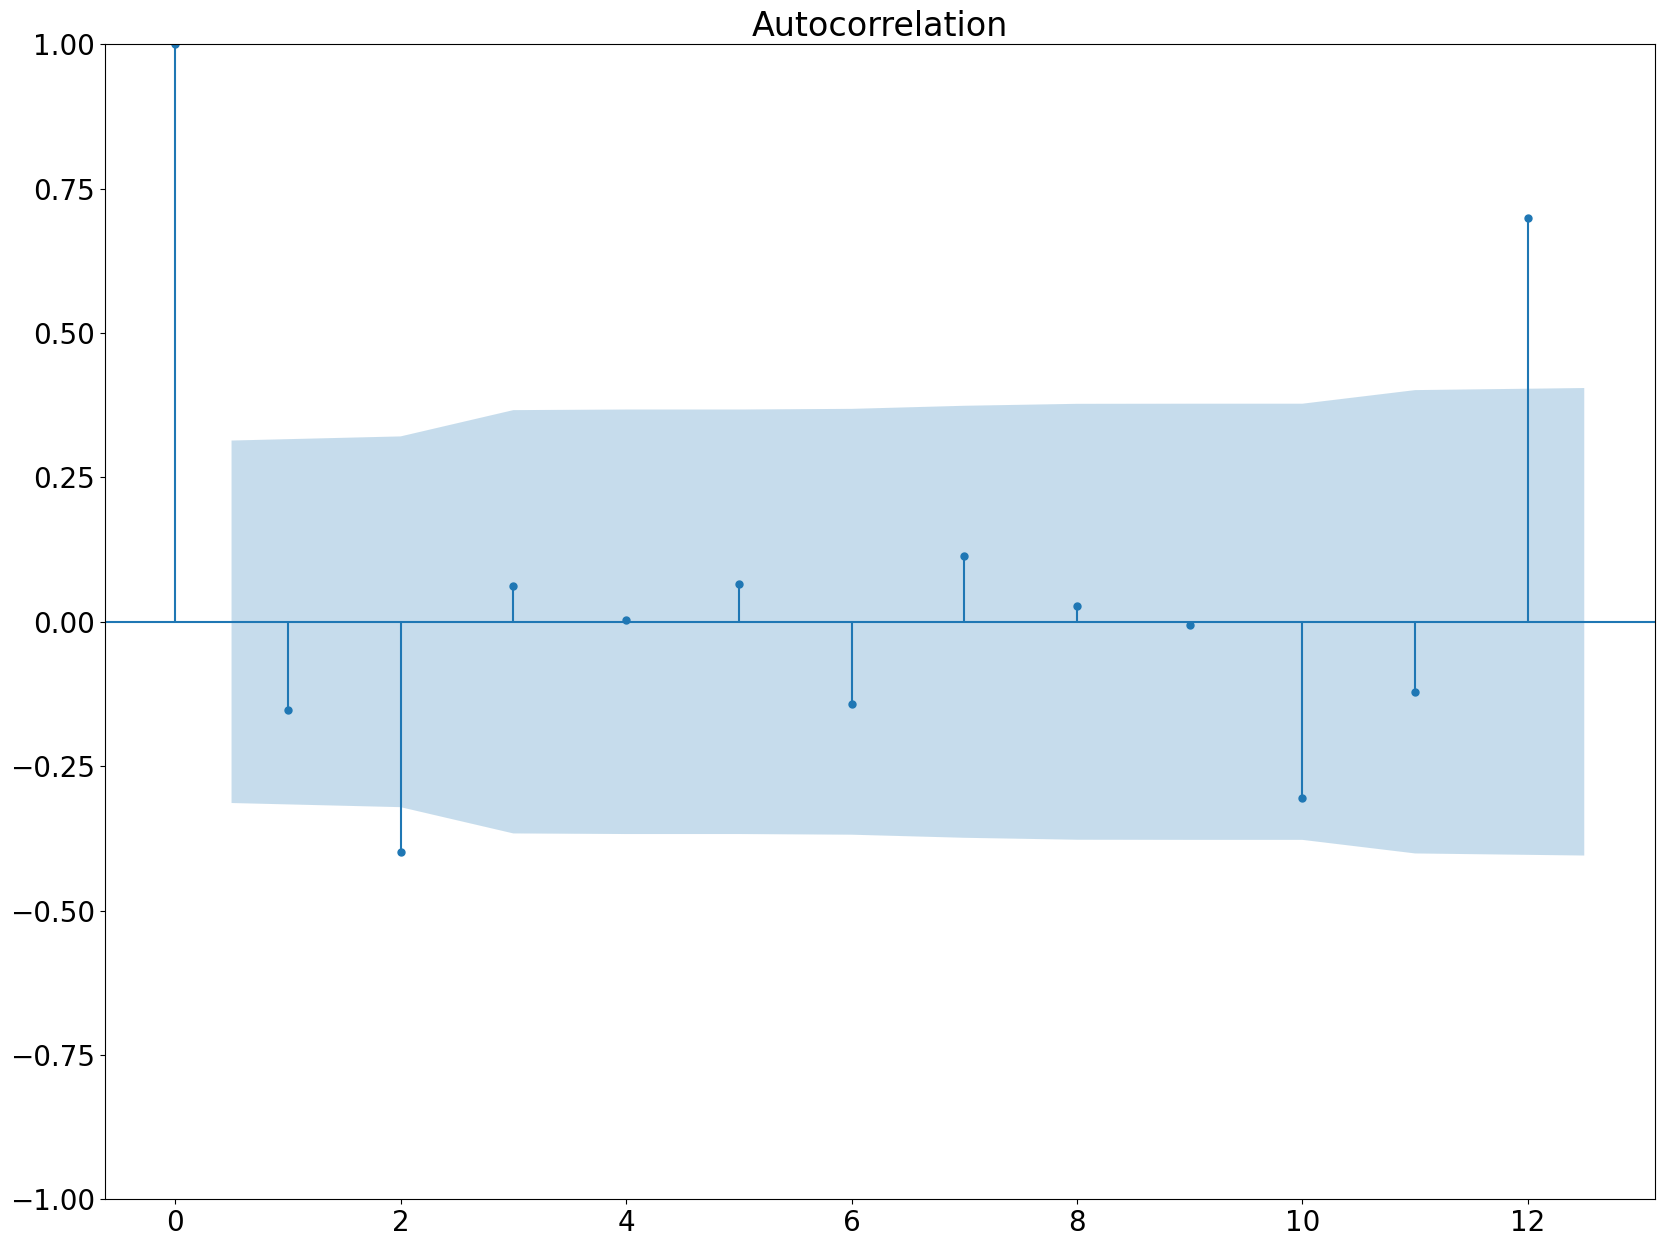

In [77]:
decomposition = seasonal_decompose(df_italy['Diff_Value'][1:] , model = 'additive')
seasonal_italy = decomposition.seasonal
plot_pacf(seasonal_italy ,  lags = 12)
plot_acf(seasonal_italy ,  lags = 12)
plt.show()

**Let's take P = 4 , Q = 2**

### Finding The Suitable Model

In [78]:
# Let's take some pair of orders along with one we got from auto arima
orders= [ (2,0,0) , (2,0,2) , (0,0,2) , (10,0,0) , (11,0,0) , (10,0,2) , (11,0,2)]

for order in orders:
    ar,ma = order[0] , order[-1]
    sarima = SARIMAX(df_italy['Diff_Value'][1:] , order = (ar,0,ma) , seasonal_order =(4,0,2,12))
    results = sarima.fit()
    print(f'ARIMA{order} has LLF = {results.llf} and AIC = {results.aic}')

ARIMA(2, 0, 0) has LLF = -611.9894279337465 and AIC = 1241.978855867493


LinAlgError: LU decomposition error.

**Let's choose ARIMA(11,0,0)**

In [ ]:
sarima_italy = SARIMAX(df_italy['Diff_Value'][1:] , order = (11,0,0)  , seasonal_order =(2,0,2,12))
results_italy = sarima_italy.fit()

In [ ]:
plot_pacf(results_italy.resid , lags = 15)
plt.show()

#we can proceed since there are no lags below 10

### Forecasting Future Values

In [ ]:
# Lets forecast for next 15 months
differences = results_italy.forecast(steps = 15).values.tolist()

# Store the data values for calculating values from forecasted values
values = df_italy['Value'].values.tolist()
len(values)

In [ ]:
for diff in differences:
    val = diff + values[-1]
    values.append(round(val))
    
plt.plot(pd.DataFrame({'Date':dates , 'Value':values[39:]}).set_index('Date'), label = 'Forecasted' , color = 'red')
plt.plot(df_italy[['Value']] , label = 'Previous values' ,color = 'blue')
plt.legend()
plt.show()

In [ ]:
# forecast_df['Italy'] = values[40:]

In [ ]:
# joblib.dump(results_italy , 'Model_Italy.pkl')

# Saving The Forecasted DataFrame

In [ ]:
forecast_df = forecast_df.reset_index().rename(columns = {'index':'Date'})
forecast_df.head()